# Analyze Boston City of Boston 


311 SERVICE REQUESTS
This data set includes all channels of engagement in which a service request is created.

Refer to this link to learn more about BOS:311: https://www.cityofboston.gov/311/

Refer to this link for the Boston 311 Open Data Source:  https://data.boston.gov/dataset/311-service-requests
THEME	City services

LOCATION	Boston (all)

CONTACT POINT	Boston 311

CONTACT POINT EMAIL	311supervisors@boston.gov

CONTACT POINT PHONE NUMBER	617-635-4500

LICENSE	Open Data Commons Public Domain Dedication and License (PDDL)

In [265]:
## Loading libraries for the Boston 311
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from itertools import chain
from scipy.stats import norm
import plotly
import missingno as msno
import plotly.graph_objs as go
import numpy as np
from sklearn.preprocessing import LabelEncoder 

## Plotting for geopanda 
import descartes 
import geopandas as gpd
from shapely.geometry import Point, Polygon
from IPython import display
%matplotlib inline

from scipy import stats
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Regression Models
# Models for the splitting the samples into train_test
from sklearn.model_selection import train_test_split
from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
## Loading the Boston 311 Dataset

df_raw = pd.read_csv("C:/Users/jlpar/Documents/Springboard Curriculum/Course/Course Material/Unit 15/Capstone II Datasets/boston311.csv")
type(df_raw)

pandas.core.frame.DataFrame

In [16]:
## Quick look a Boston 311 dataset
df_raw.head(5)

case_enquiry_id        open_dt       target_dt         closed_dt   ontime  \
0     1.010000e+11  7/1/2011 2:28  8/15/2011 2:28    8/1/2011 15:21   ONTIME   
1     1.010000e+11  7/1/2011 3:03  7/15/2011 3:03   7/22/2011 16:13  OVERDUE   
2     1.010000e+11  7/1/2011 3:12             NaN     7/1/2011 6:12   ONTIME   
3     1.010000e+11  7/1/2011 3:43             NaN     7/5/2011 9:16   ONTIME   
4     1.010000e+11  7/1/2011 5:35  8/15/2011 5:35  10/17/2011 12:33  OVERDUE   

  case_status                                     closure_reason  \
0      Closed  Case Closed Case Resolved No Sidewalk and poor...   
1      Closed               Case Closed Case Resolved completed    
2      Closed                         Case Closed Case Resolved    
3      Closed                            Case Closed Case Noted    
4      Closed          Case Closed Case Noted Duplicate request    

                                case_title                            subject  \
0  New Sign  Crosswalk or Pavement Marking  Transportation - Traffic Division   
1                     Street Light Outages            Public Works Department   
2                      Highway Maintenance            Public Works Department   
3                             Notification            Mayor's 24 Hour Hotline   
4  New Sign  Crosswalk or Pavement Marking  Transportation - Traffic Division   

                reason        ...        police_district  \
0      Signs & Signals        ...                     E5   
1        Street Lights        ...                    E18   
2  Highway Maintenance        ...                    C11   
3         Notification        ...                    E13   
4      Signs & Signals        ...                     D4   

                                   neighborhood  \
0                                  West Roxbury   
1                                     Hyde Park   
2                                    Dorchester   
3                                 Jamaica Plain   
4  Fenway / Kenmore / Audubon Circle / Longwood   

  neighborhood_services_district     ward precinct  \
0                             12  Ward 20     2017   
1                             10  Ward 18     1816   
2                              7  Ward 13     1309   
3                             11  Ward 10     1006   
4                             14  Ward 21     2102   

                      location_street_name location_zipcode latitude  \
0      INTERSECTION Corey St & Lagrange St              NaN  42.3003   
1                        235 Fairmount Ave           2136.0  42.2496   
2  INTERSECTION Dorchester Ave & Hallam St              NaN  42.3144   
3                           7 Edge Hill St           2130.0  42.3243   
4      INTERSECTION Arundel St & Beacon St              NaN  42.3471   

  longitude            source  
0  -71.1698      Self Service  
1  -71.1156      Self Service  
2  -71.0569  Constituent Call  
3  -71.1060  Constituent Call  
4  -71.1033      Self Service  

[5 rows x 29 columns]

In [17]:
## Reviewing the integers for the dataset
df_raw.describe()

case_enquiry_id  location_zipcode      latitude     longitude
count     1.048575e+06     806329.000000  1.048575e+06  1.048575e+06
mean      1.010015e+11       2127.368274  4.232830e+01 -7.108270e+01
std       9.452273e+05         18.454020  3.445641e-02  3.544502e-02
min       1.010000e+11       2026.000000  4.223020e+01 -7.118540e+01
25%       1.010010e+11       2120.000000  4.229910e+01 -7.110570e+01
50%       1.010010e+11       2126.000000  4.233640e+01 -7.107200e+01
75%       1.010020e+11       2131.000000  4.235940e+01 -7.105870e+01
max       1.010030e+11       2467.000000  4.239520e+01 -7.099490e+01

In [18]:
# looking for missing and unique data from the df_raw training dataset  
df_raw_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in df_raw.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_raw[c].unique()]
    tmp['values_count_incna'] = len(list(df_raw[c].unique()))
    tmp['values_count_nona'] = int(df_raw[c].nunique())
    tmp['num_miss'] = df_raw[c].isnull().sum()
    tmp['pct_miss'] = (df_raw[c].isnull().sum()/ len(df_raw)).round(3)*100
    df_raw_stats = df_raw_stats.append(tmp)

In [19]:
# Ascending sort on the attributes for each of the Variables
df_raw_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = True)

# And set the index to Column Names
df_raw_stats.set_index('column', inplace = True)
df_raw_stats 

values  \
column                                                                              
case_status                                                        [Closed, Open]   
ontime                                                     [ONTIME, OVERDUE, nan]   
case_enquiry_id                 [101000000000.0, 101001000000.0, 101002000000....   
source                          [Self Service, Constituent Call, Employee Gene...   
city_council_district                      [6, 5, 3, 8, 2, 7, 4, 1, 9,  , 0, nan]   
fire_district                        [nan, 12, 7, 9, 4, 6, 8, 1, 3, 11,  , 5, 10]   
subject                         [Transportation - Traffic Division, Public Wor...   
pwd_district                    [6, 8, 3, 10A, 7, 1C, 10B, 5, 9, 1A, 1B, 4, 2,...   
department                      [BTDT, PWDx, INFO, ISD, PARK, PROP, BWSC, DISB...   
neighborhood_services_district  [12, 10, 7, 11, 14, 6, 13, 5, 9, 8, 1, 2, 3, 1...   
police_district                 [E5, E18, C11, E13, D4, A1, B2, C6, B3, A7, A1...   
neighborhood                    [West Roxbury, Hyde Park, Dorchester, Jamaica ...   
location_zipcode                [nan, 2136.0, 2130.0, 2122.0, 2116.0, 2131.0, ...   
ward                            [Ward 20, Ward 18, Ward 13, Ward 10, Ward 21, ...   
reason                          [Signs & Signals, Street Lights, Highway Maint...   
queue                           [BTDT_Engineering_New Sign and Pavement Markin...   
type                            [New Sign  Crosswalk or Pavement Marking, Stre...   
precinct                        [2017, 1816, 1309, 1006, 2102, 1602, 1817, 501...   
latitude                        [42.3003, 42.2496, 42.3144, 42.3243, 42.3471, ...   
longitude                       [-71.1698, -71.1156, -71.0569, -71.10600000000...   
case_title                      [New Sign  Crosswalk or Pavement Marking, Stre...   
closedphoto                     [nan, https://cityworker.cityofboston.gov:8443...   
location_street_name            [INTERSECTION Corey St & Lagrange St, 235 Fair...   
location                        [INTERSECTION of Corey St & Lagrange St  West ...   
submittedphoto                  [nan,  https://cityworker.cityofboston.gov:844...   
target_dt                       [8/15/2011 2:28, 7/15/2011 3:03, nan, 8/15/201...   
closure_reason                  [Case Closed Case Resolved No Sidewalk and poo...   
closed_dt                       [8/1/2011 15:21, 7/22/2011 16:13, 7/1/2011 6:1...   
open_dt                         [7/1/2011 2:28, 7/1/2011 3:03, 7/1/2011 3:12, ...   

                               values_count_incna values_count_nona num_miss  \
column                                                                         
case_status                                     2                 2        0   
ontime                                          3                 2      562   
case_enquiry_id                                 4                 4        0   
source                                          7                 7        0   
city_council_district                          12                11      168   
fire_district                                  13                12     2516   
subject                                        14                14        0   
pwd_district                                   15                14      635   
department                                     16                16        0   
neighborhood_services_district                 18                17      167   
police_district                                25                24      437   
neighborhood                                   25                24     1086   
location_zipcode                               40                39   242246   
ward                                           47                46      154   
reason                                         54                54        0   
queue                                         185               185        0   

In [20]:
# Total missing values for each feature from the df_raw
print(df_raw.isnull().sum())

case_enquiry_id                        0
open_dt                                0
target_dt                         201286
closed_dt                          82105
ontime                               562
case_status                            0
closure_reason                         0
case_title                           362
subject                                0
reason                                 0
type                                   0
queue                                  0
department                             0
submittedphoto                    828771
closedphoto                       922640
location                               0
fire_district                       2516
pwd_district                         635
city_council_district                168
police_district                      437
neighborhood                        1086
neighborhood_services_district       167
ward                                 154
precinct                             709
location_street_

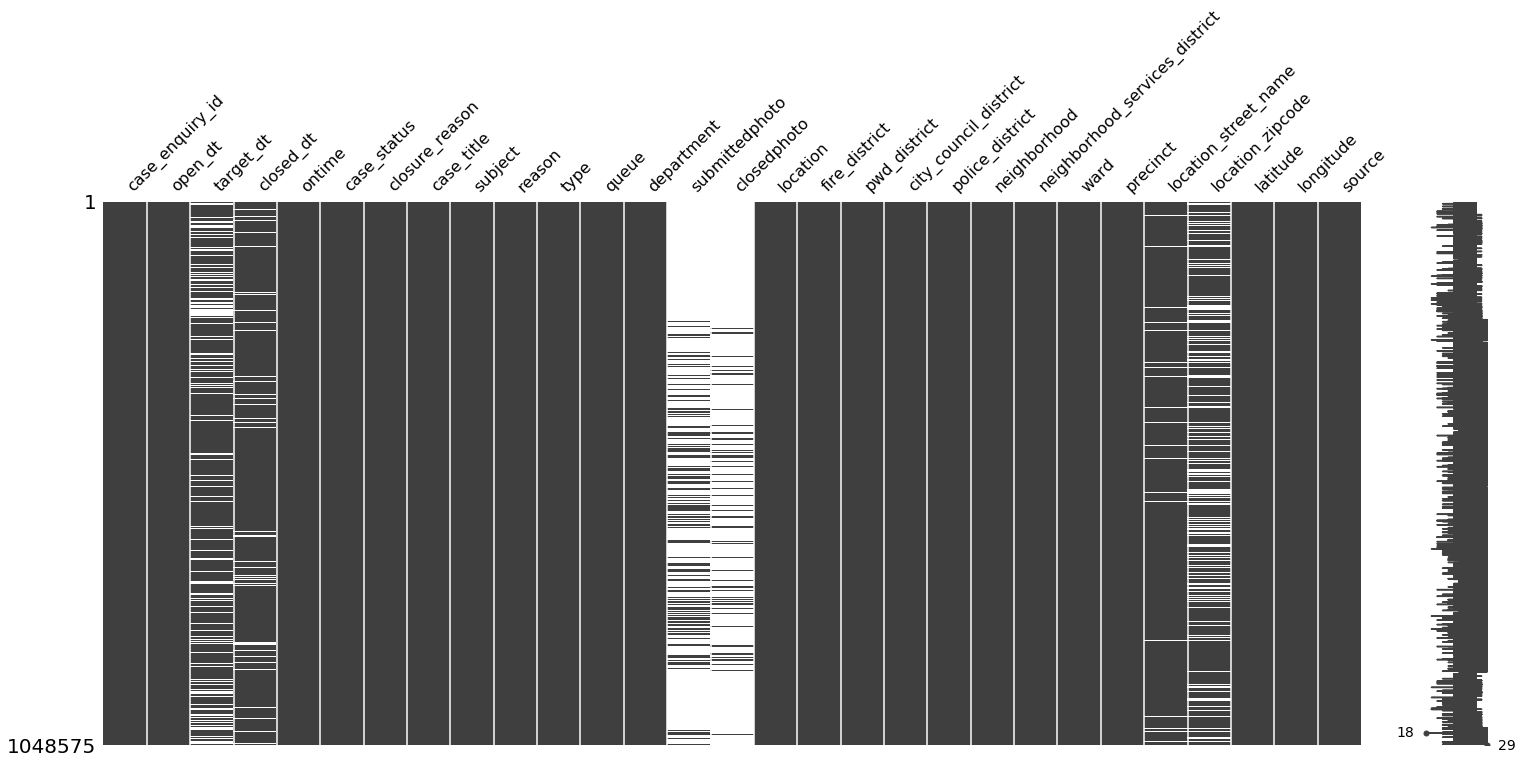

In [21]:
## Missing Value Matrix displaying the distribution of the missing values for Boston 311
msno.matrix(df_raw)

In [22]:
## Looking at the columns or attributes for the df_raw
df_raw.columns

Index(['case_enquiry_id', 'open_dt', 'target_dt', 'closed_dt', 'ontime',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submittedphoto', 'closedphoto',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'source'],
      dtype='object')

In [23]:
## Looking at the time open_dt variable
df_raw.open_dt.describe()

count            1048575
unique            794736
top       7/6/2011 11:14
freq                  60
Name: open_dt, dtype: object

In [24]:
## Describe statement for all attributes of the df_raw df. 
df_raw.describe(include='all')

case_enquiry_id         open_dt       target_dt       closed_dt  \
count      1.048575e+06         1048575          847289          966470   
unique              NaN          794736          459306          611769   
top                 NaN  7/6/2011 11:14  2/13/2013 8:30  2/14/2013 6:46   
freq                NaN              60           12777             353   
mean       1.010015e+11             NaN             NaN             NaN   
std        9.452273e+05             NaN             NaN             NaN   
min        1.010000e+11             NaN             NaN             NaN   
25%        1.010010e+11             NaN             NaN             NaN   
50%        1.010010e+11             NaN             NaN             NaN   
75%        1.010020e+11             NaN             NaN             NaN   
max        1.010030e+11             NaN             NaN             NaN   

         ontime case_status closure_reason                   case_title  \
count   1048013     1048575        1048575                      1048213   
unique        2           2         608375                        11800   
top      ONTIME      Closed                 Schedule a Bulk Item Pickup   
freq     840854      966470          81929                        88214   
mean        NaN         NaN            NaN                          NaN   
std         NaN         NaN            NaN                          NaN   
min         NaN         NaN            NaN                          NaN   
25%         NaN         NaN            NaN                          NaN   
50%         NaN         NaN            NaN                          NaN   
75%         NaN         NaN            NaN                          NaN   
max         NaN         NaN            NaN                          NaN   

                        subject      reason        ...        police_district  \
count                   1048575     1048575        ...                1048138   
unique                       14          54        ...                     24   
top     Public Works Department  Sanitation        ...                     D4   
freq                     634084      168356        ...                 130433   
mean                        NaN         NaN        ...                    NaN   
std                         NaN         NaN        ...                    NaN   
min                         NaN         NaN        ...                    NaN   
25%                         NaN         NaN        ...                    NaN   
50%                         NaN         NaN        ...                    NaN   
75%                         NaN         NaN        ...                    NaN   
max                         NaN         NaN        ...                    NaN   

       neighborhood neighborhood_services_district     ward precinct  \
count       1047489                        1048408  1048421  1047866   
unique           24                             17       46      255   
top      Dorchester                             13  Ward 18            
freq         155864                         106978    76097    33606   
mean            NaN                            NaN      NaN      NaN   
std             NaN                            NaN      NaN      NaN   
min             NaN                            NaN      NaN      NaN   
25%             NaN                            NaN      NaN      NaN   
50%             NaN                            NaN      NaN      NaN   
75%             NaN                            NaN      NaN      NaN   
max             NaN                            NaN      NaN      NaN   

       location_street_name location_zipcode      latitude     longitude  \
count               1017935    806329.000000  1.048575e+06  1.048575e+06   
unique               128883              NaN           NaN           NaN   
top         1 City Hall Plz              NaN           NaN           NaN   
freq                   3000              NaN           NaN      

In [25]:
## Converting the open_dt attribute to a timestamp for analysis
df_raw2=df_raw

df_raw2['open_dt'] = pd.to_datetime (df_raw2['open_dt'])
df_raw2

case_enquiry_id             open_dt        target_dt  \
0           1.010000e+11 2011-07-01 02:28:00   8/15/2011 2:28   
1           1.010000e+11 2011-07-01 03:03:00   7/15/2011 3:03   
2           1.010000e+11 2011-07-01 03:12:00              NaN   
3           1.010000e+11 2011-07-01 03:43:00              NaN   
4           1.010000e+11 2011-07-01 05:35:00   8/15/2011 5:35   
5           1.010000e+11 2011-07-01 06:44:00    7/4/2011 6:44   
6           1.010000e+11 2011-07-01 07:14:00    7/5/2011 7:14   
7           1.010000e+11 2011-07-01 07:16:00   7/31/2011 7:16   
8           1.010000e+11 2011-07-01 07:28:00    7/5/2011 7:28   
9           1.010000e+11 2011-07-01 07:31:00    7/5/2011 7:31   
10          1.010000e+11 2011-07-01 07:34:00   7/29/2011 7:34   
11          1.010000e+11 2011-07-01 07:37:00    7/5/2011 7:37   
12          1.010000e+11 2011-07-01 07:44:00    7/4/2011 7:44   
13          1.010000e+11 2011-07-01 08:03:00              NaN   
14          1.010000e+11 2011-07-01 08:03:00              NaN   
15          1.010000e+11 2011-07-01 08:03:00              NaN   
16          1.010000e+11 2011-07-01 08:04:00              NaN   
17          1.010000e+11 2011-07-01 08:04:00              NaN   
18          1.010000e+11 2011-07-01 08:04:00              NaN   
19          1.010000e+11 2011-07-01 08:04:00              NaN   
20          1.010000e+11 2011-07-01 08:05:00              NaN   
21          1.010000e+11 2011-07-01 08:05:00              NaN   
22          1.010000e+11 2011-07-01 08:05:00              NaN   
23          1.010000e+11 2011-07-01 08:05:00              NaN   
24          1.010000e+11 2011-07-01 08:06:00              NaN   
25          1.010000e+11 2011-07-01 08:07:00              NaN   
26          1.010000e+11 2011-07-01 08:07:00              NaN   
27          1.010000e+11 2011-07-01 08:07:00              NaN   
28          1.010000e+11 2011-07-01 08:07:00    7/5/2011 8:07   
29          1.010000e+11 2011-07-01 08:08:00              NaN   
...                  ...                 ...              ...   
1048545     1.010010e+11 2015-01-20 11:57:00  1/22/2015 11:57   
1048546     1.010010e+11 2015-01-20 12:01:00   2/3/2015 12:01   
1048547     1.010010e+11 2015-01-20 12:01:00  1/22/2015 12:01   
1048548     1.010010e+11 2015-01-20 12:04:00              NaN   
1048549     1.010010e+11 2015-01-20 12:05:00              NaN   
1048550     1.010010e+11 2015-01-20 12:07:00  1/22/2015 12:07   
1048551     1.010010e+11 2015-01-20 12:08:00  1/21/2015 12:08   
1048552     1.010010e+11 2015-01-20 12:12:00   2/3/2015 12:12   
1048553     1.010010e+11 2015-01-20 12:13:00  1/22/2015 12:13   
1048554     1.010010e+11 2015-01-20 12:14:00   3/6/2015 12:14   
1048555     1.010010e+11 2015-01-20 12:17:00              NaN   
1048556     1.010010e+11 2015-01-20 12:18:00  1/22/2015 12:18   
1048557     1.010010e+11 2015-01-20 12:21:00              NaN   
1048558     1.010010e+11 2015-01-20 12:22:00  1/22/2015 12:22   
1048559     1.010010e+11 2015-01-20 12:23:00  1/22/2015 12:23   
1048560     1.010010e+11 2015-01-20 12:24:00  1/22/2015 12:24   
1048561     1.010010e+11 2015-01-20 12:31:00  1/22/2015 12:31   
1048562     1.010010e+11 2015-01-20 12:32:00              NaN   
1048563     1.010010e+11 2015-01-20 12:39:00  1/22/2015 12:39   
1048564     1.010010e+11 2015-01-20 12:41:00  1/22/2015 12:41   
1048565     1.010010e+11 2015-01-20 12:41:00  2/18/2015 12:41   
1048566     1.010010e+11 2015-01-20 12:41:00  1/22/2015 12:41   
1048567     1.010010e+11 2015-01-20 12:44:00  1/22/2015 12:44   
1048568     1.010010e+11 2015-01-20 12:45:00              NaN   
1048569     1.010010e+11 2015-01-20 12:50:00  1/22/2015 12:50   
1048570     1.010010e+11 2015-01-20 12:53:00              NaN   
1048571     1.010010e+11 2015-01-20 12:55:00              NaN   
1048572     1.010010e+11 2015-01-20 13:20:00              NaN   
1048573     1.010010e+11 2015-01-20 13:24:00  1/22/2015 13:24   
1048574     1.010010e+11 2015-01-20 13:24:00

In [26]:
## Converting the target_dt attribute to a timestamp for analysis
df_raw2['target_dt'] = pd.to_datetime (df_raw2['target_dt'])
df_raw2

case_enquiry_id             open_dt           target_dt  \
0           1.010000e+11 2011-07-01 02:28:00 2011-08-15 02:28:00   
1           1.010000e+11 2011-07-01 03:03:00 2011-07-15 03:03:00   
2           1.010000e+11 2011-07-01 03:12:00                 NaT   
3           1.010000e+11 2011-07-01 03:43:00                 NaT   
4           1.010000e+11 2011-07-01 05:35:00 2011-08-15 05:35:00   
5           1.010000e+11 2011-07-01 06:44:00 2011-07-04 06:44:00   
6           1.010000e+11 2011-07-01 07:14:00 2011-07-05 07:14:00   
7           1.010000e+11 2011-07-01 07:16:00 2011-07-31 07:16:00   
8           1.010000e+11 2011-07-01 07:28:00 2011-07-05 07:28:00   
9           1.010000e+11 2011-07-01 07:31:00 2011-07-05 07:31:00   
10          1.010000e+11 2011-07-01 07:34:00 2011-07-29 07:34:00   
11          1.010000e+11 2011-07-01 07:37:00 2011-07-05 07:37:00   
12          1.010000e+11 2011-07-01 07:44:00 2011-07-04 07:44:00   
13          1.010000e+11 2011-07-01 08:03:00                 NaT   
14          1.010000e+11 2011-07-01 08:03:00                 NaT   
15          1.010000e+11 2011-07-01 08:03:00                 NaT   
16          1.010000e+11 2011-07-01 08:04:00                 NaT   
17          1.010000e+11 2011-07-01 08:04:00                 NaT   
18          1.010000e+11 2011-07-01 08:04:00                 NaT   
19          1.010000e+11 2011-07-01 08:04:00                 NaT   
20          1.010000e+11 2011-07-01 08:05:00                 NaT   
21          1.010000e+11 2011-07-01 08:05:00                 NaT   
22          1.010000e+11 2011-07-01 08:05:00                 NaT   
23          1.010000e+11 2011-07-01 08:05:00                 NaT   
24          1.010000e+11 2011-07-01 08:06:00                 NaT   
25          1.010000e+11 2011-07-01 08:07:00                 NaT   
26          1.010000e+11 2011-07-01 08:07:00                 NaT   
27          1.010000e+11 2011-07-01 08:07:00                 NaT   
28          1.010000e+11 2011-07-01 08:07:00 2011-07-05 08:07:00   
29          1.010000e+11 2011-07-01 08:08:00                 NaT   
...                  ...                 ...                 ...   
1048545     1.010010e+11 2015-01-20 11:57:00 2015-01-22 11:57:00   
1048546     1.010010e+11 2015-01-20 12:01:00 2015-02-03 12:01:00   
1048547     1.010010e+11 2015-01-20 12:01:00 2015-01-22 12:01:00   
1048548     1.010010e+11 2015-01-20 12:04:00                 NaT   
1048549     1.010010e+11 2015-01-20 12:05:00                 NaT   
1048550     1.010010e+11 2015-01-20 12:07:00 2015-01-22 12:07:00   
1048551     1.010010e+11 2015-01-20 12:08:00 2015-01-21 12:08:00   
1048552     1.010010e+11 2015-01-20 12:12:00 2015-02-03 12:12:00   
1048553     1.010010e+11 2015-01-20 12:13:00 2015-01-22 12:13:00   
1048554     1.010010e+11 2015-01-20 12:14:00 2015-03-06 12:14:00   
1048555     1.010010e+11 2015-01-20 12:17:00                 NaT   
1048556     1.010010e+11 2015-01-20 12:18:00 2015-01-22 12:18:00   
1048557     1.010010e+11 2015-01-20 12:21:00                 NaT   
1048558     1.010010e+11 2015-01-20 12:22:00 2015-01-22 12:22:00   
1048559     1.010010e+11 2015-01-20 12:23:00 2015-01-22 12:23:00   
1048560     1.010010e+11 2015-01-20 12:24:00 2015-01-22 12:24:00   
1048561     1.010010e+11 2015-01-20 12:31:00 2015-01-22 12:31:00   
1048562     1.010010e+11 2015-01-20 12:32:00                 NaT   
1048563     1.010010e+11 2015-01-20 12:39:00 2015-01-22 12:39:00   
1048564     1.010010e+11 2015-01-20 12:41:00 2015-01-22 12:41:00   
1048565     1.010010e+11 2015-01-20 12:41:00 2015-02-18 12:41:00   
1048566     1.010010e+11 2015-01-20 12:41:00 2015-01-22 12:41:00   
1048567     1.010010e+11 2015-01-20 12:44:00 2015-01-22 12:44:00   
1048568     1.010010e+11 2015-01-20 12:45:00                 NaT   
1048569     1.010010e+11 2015-01-20 12:50:00 2015-01-22 12:50:00   
1048570     1.010010e+11 2015-01-20 12:53:00                 NaT   
1048571     1.010010e+11 2015-01-20 12:55:00                 NaT 

In [27]:
## Converting the closed_dt attribute to a timestamp for analysis
df_raw2['closed_dt'] = pd.to_datetime (df_raw2['closed_dt'])
df_raw2

case_enquiry_id             open_dt           target_dt  \
0           1.010000e+11 2011-07-01 02:28:00 2011-08-15 02:28:00   
1           1.010000e+11 2011-07-01 03:03:00 2011-07-15 03:03:00   
2           1.010000e+11 2011-07-01 03:12:00                 NaT   
3           1.010000e+11 2011-07-01 03:43:00                 NaT   
4           1.010000e+11 2011-07-01 05:35:00 2011-08-15 05:35:00   
5           1.010000e+11 2011-07-01 06:44:00 2011-07-04 06:44:00   
6           1.010000e+11 2011-07-01 07:14:00 2011-07-05 07:14:00   
7           1.010000e+11 2011-07-01 07:16:00 2011-07-31 07:16:00   
8           1.010000e+11 2011-07-01 07:28:00 2011-07-05 07:28:00   
9           1.010000e+11 2011-07-01 07:31:00 2011-07-05 07:31:00   
10          1.010000e+11 2011-07-01 07:34:00 2011-07-29 07:34:00   
11          1.010000e+11 2011-07-01 07:37:00 2011-07-05 07:37:00   
12          1.010000e+11 2011-07-01 07:44:00 2011-07-04 07:44:00   
13          1.010000e+11 2011-07-01 08:03:00                 NaT   
14          1.010000e+11 2011-07-01 08:03:00                 NaT   
15          1.010000e+11 2011-07-01 08:03:00                 NaT   
16          1.010000e+11 2011-07-01 08:04:00                 NaT   
17          1.010000e+11 2011-07-01 08:04:00                 NaT   
18          1.010000e+11 2011-07-01 08:04:00                 NaT   
19          1.010000e+11 2011-07-01 08:04:00                 NaT   
20          1.010000e+11 2011-07-01 08:05:00                 NaT   
21          1.010000e+11 2011-07-01 08:05:00                 NaT   
22          1.010000e+11 2011-07-01 08:05:00                 NaT   
23          1.010000e+11 2011-07-01 08:05:00                 NaT   
24          1.010000e+11 2011-07-01 08:06:00                 NaT   
25          1.010000e+11 2011-07-01 08:07:00                 NaT   
26          1.010000e+11 2011-07-01 08:07:00                 NaT   
27          1.010000e+11 2011-07-01 08:07:00                 NaT   
28          1.010000e+11 2011-07-01 08:07:00 2011-07-05 08:07:00   
29          1.010000e+11 2011-07-01 08:08:00                 NaT   
...                  ...                 ...                 ...   
1048545     1.010010e+11 2015-01-20 11:57:00 2015-01-22 11:57:00   
1048546     1.010010e+11 2015-01-20 12:01:00 2015-02-03 12:01:00   
1048547     1.010010e+11 2015-01-20 12:01:00 2015-01-22 12:01:00   
1048548     1.010010e+11 2015-01-20 12:04:00                 NaT   
1048549     1.010010e+11 2015-01-20 12:05:00                 NaT   
1048550     1.010010e+11 2015-01-20 12:07:00 2015-01-22 12:07:00   
1048551     1.010010e+11 2015-01-20 12:08:00 2015-01-21 12:08:00   
1048552     1.010010e+11 2015-01-20 12:12:00 2015-02-03 12:12:00   
1048553     1.010010e+11 2015-01-20 12:13:00 2015-01-22 12:13:00   
1048554     1.010010e+11 2015-01-20 12:14:00 2015-03-06 12:14:00   
1048555     1.010010e+11 2015-01-20 12:17:00                 NaT   
1048556     1.010010e+11 2015-01-20 12:18:00 2015-01-22 12:18:00   
1048557     1.010010e+11 2015-01-20 12:21:00                 NaT   
1048558     1.010010e+11 2015-01-20 12:22:00 2015-01-22 12:22:00   
1048559     1.010010e+11 2015-01-20 12:23:00 2015-01-22 12:23:00   
1048560     1.010010e+11 2015-01-20 12:24:00 2015-01-22 12:24:00   
1048561     1.010010e+11 2015-01-20 12:31:00 2015-01-22 12:31:00   
1048562     1.010010e+11 2015-01-20 12:32:00                 NaT   
1048563     1.010010e+11 2015-01-20 12:39:00 2015-01-22 12:39:00   
1048564     1.010010e+11 2015-01-20 12:41:00 2015-01-22 12:41:00   
1048565     1.010010e+11 2015-01-20 12:41:00 2015-02-18 12:41:00   
1048566     1.010010e+11 2015-01-20 12:41:00 2015-01-22 12:41:00   
1048567     1.010010e+11 2015-01-20 12:44:00 2015-01-22 12:44:00   
1048568     1.010010e+11 2015-01-20 12:45:00                 NaT   
1048569     1.010010e+11 2015-01-20 12:50:00 2015-01-22 12:50:00   
1048570     1.010010e+11 2015-01-20 12:53:00                 NaT   
1048571     1.010010e+11 2015-01-20 12:55:00                 NaT 

In [28]:
## Filtering all data for dates greator than October 1 of 2017 for 3 year analysis 
df_raw2=df_raw[df_raw['open_dt'] >= '10/1/2017']
df_raw2.count()

case_enquiry_id                   267375
open_dt                           267375
target_dt                         233767
closed_dt                         235385
ontime                            267374
case_status                       267375
closure_reason                    267375
case_title                        267348
subject                           267375
reason                            267375
type                              267375
queue                             267375
department                        267375
submittedphoto                    106705
closedphoto                        61962
location                          267375
fire_district                     266728
pwd_district                      267222
city_council_district             267341
police_district                   267227
neighborhood                      267045
neighborhood_services_district    267343
ward                              267374
precinct                          267150
location_street_

In [29]:
## Data check for the three year data set
df_raw2.head()

case_enquiry_id             open_dt           target_dt closed_dt  \
592709     1.010020e+11 2017-12-13 21:25:00                 NaT       NaT   
593771     1.010020e+11 2017-10-10 14:15:00 2017-10-24 14:15:00       NaT   
593828     1.010020e+11 2017-10-27 22:11:00 2017-11-14 08:30:00       NaT   
594133     1.010020e+11 2017-11-18 20:54:00                 NaT       NaT   
594213     1.010020e+11 2017-12-13 21:26:00 2017-12-29 08:30:00       NaT   

         ontime case_status closure_reason        case_title  \
592709   ONTIME        Open                      Animal Lost   
593771  OVERDUE        Open                   Other: Comment   
593828  OVERDUE        Open                  BTDT: Complaint   
594133   ONTIME        Open                     Animal Found   
594213  OVERDUE        Open                 Other: Complaint   

                        subject                       reason  \
592709           Animal Control                Animal Issues   
593771  Mayor's 24 Hour Hotline  Employee & General Comments   
593828  Mayor's 24 Hour Hotline  Employee & General Comments   
594133           Animal Control                Animal Issues   
594213  Mayor's 24 Hour Hotline  Employee & General Comments   

              ...        police_district        neighborhood  \
592709        ...                    C11          Dorchester   
593771        ...                                              
593828        ...                                              
594133        ...                    D14  Allston / Brighton   
594213        ...                                              

       neighborhood_services_district     ward precinct location_street_name  \
592709                              7  Ward 16     1606         609 Adams St   
593771                                                                   NaN   
593828                                                                   NaN   
594133                             15  Ward 22     2203        28 Shepard St   
594213                                                                   NaN   

       location_zipcode latitude longitude            source  
592709           2124.0  42.2890  -71.0558  Constituent Call  
593771              NaN  42.3594  -71.0587  Constituent Call  
593828              NaN  42.3594  -71.0587  Constituent Call  
594133           2135.0  42.3468  -71.1503  Constituent Call  
594213              NaN  42.3594  -71.0587  Constituent Call  

[5 rows x 29 columns]

In [30]:
# looking for missing and unique data from the 3 year df_raw training dataset  
df_raw2_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in df_raw2.columns:
    tmp['column'] = [c]
    tmp['values'] = [df_raw2[c].unique()]
    tmp['values_count_incna'] = len(list(df_raw2[c].unique()))
    tmp['values_count_nona'] = int(df_raw2[c].nunique())
    tmp['num_miss'] = df_raw2[c].isnull().sum()
    tmp['pct_miss'] = (df_raw2[c].isnull().sum()/ len(df_raw2)).round(3)*100
    df_raw2_stats = df_raw2_stats.append(tmp)

In [31]:
# Ascending sort on the Number of Distinct Categories for each categorical Variables
df_raw2_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = True)

# And set the index to Column Names
df_raw2_stats.set_index('column', inplace = True)
df_raw2_stats 

values  \
column                                                                              
case_enquiry_id                                  [101002000000.0, 101003000000.0]   
case_status                                                        [Open, Closed]   
ontime                                                     [ONTIME, OVERDUE, nan]   
source                          [Constituent Call, Employee Generated, Self Se...   
subject                         [Animal Control, Mayor's 24 Hour Hotline, Insp...   
fire_district                           [8,  , 11, 4, 9, 1, 3, 7, 12, 6, nan, 10]   
city_council_district                      [3,  , 9, 2, 5, 8, 7, 1, 4, 6, 0, nan]   
police_district                 [C11,  , D14, D4, E5, E18, B2, A7, A1, B3, E13...   
pwd_district                    [7,  , 4, 1C, 6, 8, 2, 9, 1B, 3, 10A, 10B, 1A,...   
department                      [ANML, INFO, ISD, PWDx, BWSC, PROP, BTDT, PARK...   
neighborhood_services_district  [7,  , 15, 4, 6, 10, 14, 13, 1, 9, 8, 3, 12, 1...   
neighborhood                    [Dorchester,  , Allston / Brighton, South End,...   
location_zipcode                [2124.0, nan, 2135.0, 2118.0, 2116.0, 2131.0, ...   
reason                          [Animal Issues, Employee & General Comments, B...   
ward                            [Ward 16,  , Ward 22, Ward 3, Ward 4, Ward 20,...   
type                            [Animal Lost, General Comments For a Program o...   
queue                           [ANML02_LostFound, INFO_General Comments Compl...   
precinct                        [1606,  , 2203, 307, 401, 2001, 508, 2108, 180...   
latitude                        [42.288999999999994, 42.3594, 42.3468, 42.3414...   
longitude                       [-71.0558, -71.0587, -71.1503, -71.07, -71.075...   
case_title                      [Animal Lost, Other: Comment, BTDT: Complaint,...   
closedphoto                     [nan, https://cityworker.cityofboston.gov:8443...   
location_street_name            [609 Adams St, nan, 28 Shepard St, 1387 Washin...   
location                        [609 Adams St  Dorchester  MA  02124,  , 28 Sh...   
submittedphoto                  [nan, https://311.boston.gov/media/boston/repo...   
target_dt                       [NaT, 2017-10-24T14:15:00.000000000, 2017-11-1...   
closed_dt                       [NaT, 2017-10-21T12:04:00.000000000, 2017-12-2...   
open_dt                         [2017-12-13T21:25:00.000000000, 2017-10-10T14:...   
closure_reason                  [ , Case Closed. Closed date : 2017-10-21 12:0...   

                               values_count_incna values_count_nona num_miss  \
column                                                                         
case_enquiry_id                                 2                 2        0   
case_status                                     2                 2        0   
ontime                                          3                 2        1   
source                                          7                 7        0   
subject                                        11                11        0   
fire_district                                  12                11      647   
city_council_district                          12                11       34   
police_district                                14                13      148   
pwd_district                                   15                14      153   
department                                     15                15        0   
neighborhood_services_district                 18                17       32   
neighborhood                                   25                24      330   
location_zipcode                               36                35    63998   
reason                                         46                46        0   
ward                                           47                46        1   
type                                          175               175        0   

In [32]:
# Importing and running pandas profile statement on the 3 year data set
import pandas_profiling
pandas_profiling.ProfileReport(df_raw2)

In [33]:
## Converting the raw_df to the df1 file for analysis
df1=df_raw2

In [34]:
################################################ Dropping Select NAN

In [35]:
## Checking to see what values are missing and were dropped from df_raw 
df1.dropna(subset=['ontime'], inplace=True)
df1.count()

case_enquiry_id                   267374
open_dt                           267374
target_dt                         233766
closed_dt                         235384
ontime                            267374
case_status                       267374
closure_reason                    267374
case_title                        267347
subject                           267374
reason                            267374
type                              267374
queue                             267374
department                        267374
submittedphoto                    106705
closedphoto                        61962
location                          267374
fire_district                     266727
pwd_district                      267221
city_council_district             267340
police_district                   267226
neighborhood                      267044
neighborhood_services_district    267342
ward                              267373
precinct                          267149
location_street_

In [36]:
## Checking to see what values are missing and were dropped from df_raw for city_council_district
df1.dropna(subset=['city_council_district'], inplace=True)
df1.count()

case_enquiry_id                   267340
open_dt                           267340
target_dt                         233740
closed_dt                         235357
ontime                            267340
case_status                       267340
closure_reason                    267340
case_title                        267313
subject                           267340
reason                            267340
type                              267340
queue                             267340
department                        267340
submittedphoto                    106692
closedphoto                        61957
location                          267340
fire_district                     266724
pwd_district                      267210
city_council_district             267340
police_district                   267215
neighborhood                      267015
neighborhood_services_district    267339
ward                              267339
precinct                          267146
location_street_

In [37]:
## Checking to see what values are missing and were dropped from df_raw for neighborhood_services_district
df1.dropna(subset=['neighborhood_services_district'], inplace=True)
df1.count()

case_enquiry_id                   267339
open_dt                           267339
target_dt                         233739
closed_dt                         235356
ontime                            267339
case_status                       267339
closure_reason                    267339
case_title                        267312
subject                           267339
reason                            267339
type                              267339
queue                             267339
department                        267339
submittedphoto                    106692
closedphoto                        61956
location                          267339
fire_district                     266723
pwd_district                      267209
city_council_district             267339
police_district                   267214
neighborhood                      267014
neighborhood_services_district    267339
ward                              267339
precinct                          267145
location_street_

In [38]:
## Checking to see what values are missing and were dropped from df_raw for ward
df1.dropna(subset=['ward'], inplace=True)
df1.count()

case_enquiry_id                   267339
open_dt                           267339
target_dt                         233739
closed_dt                         235356
ontime                            267339
case_status                       267339
closure_reason                    267339
case_title                        267312
subject                           267339
reason                            267339
type                              267339
queue                             267339
department                        267339
submittedphoto                    106692
closedphoto                        61956
location                          267339
fire_district                     266723
pwd_district                      267209
city_council_district             267339
police_district                   267214
neighborhood                      267014
neighborhood_services_district    267339
ward                              267339
precinct                          267145
location_street_

In [39]:
## ## Checking to see what values are missing and were dropped from df_raw for case_title 
df1.dropna(subset=['case_title'], inplace=True)
df1.count()

case_enquiry_id                   267312
open_dt                           267312
target_dt                         233712
closed_dt                         235329
ontime                            267312
case_status                       267312
closure_reason                    267312
case_title                        267312
subject                           267312
reason                            267312
type                              267312
queue                             267312
department                        267312
submittedphoto                    106692
closedphoto                        61956
location                          267312
fire_district                     266697
pwd_district                      267182
city_council_district             267312
police_district                   267187
neighborhood                      266987
neighborhood_services_district    267312
ward                              267312
precinct                          267118
location_street_

In [40]:
# looking for missing and unique data from the raw training dataset  
df1_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in df_raw2.columns:
    tmp['column'] = [c]
    tmp['values'] = [df1[c].unique()]
    tmp['values_count_incna'] = len(list(df1[c].unique()))
    tmp['values_count_nona'] = int(df1[c].nunique())
    tmp['num_miss'] = df1[c].isnull().sum()
    tmp['pct_miss'] = (df1[c].isnull().sum()/ len(df1)).round(3)*100
    df1_stats = df1_stats.append(tmp)

In [41]:
# Ascending sort on the Numboer of Distinct Categories for each categorical Variables
df1_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = True)

# And set the index to Column Names
df1_stats.set_index('column', inplace = True)
df1_stats 

values  \
column                                                                              
case_enquiry_id                                  [101002000000.0, 101003000000.0]   
case_status                                                        [Open, Closed]   
ontime                                                          [ONTIME, OVERDUE]   
source                          [Constituent Call, Employee Generated, Self Se...   
city_council_district                           [3,  , 9, 2, 5, 8, 7, 1, 4, 6, 0]   
subject                         [Animal Control, Mayor's 24 Hour Hotline, Insp...   
fire_district                           [8,  , 11, 4, 9, 1, 3, 7, 12, 6, nan, 10]   
police_district                 [C11,  , D14, D4, E5, E18, B2, A7, A1, B3, E13...   
pwd_district                    [7,  , 4, 1C, 6, 8, 2, 9, 1B, 3, 10A, 10B, 1A,...   
department                      [ANML, INFO, ISD, PWDx, BWSC, PROP, BTDT, PARK...   
neighborhood_services_district  [7,  , 15, 4, 6, 10, 14, 13, 1, 9, 8, 3, 12, 1...   
neighborhood                    [Dorchester,  , Allston / Brighton, South End,...   
location_zipcode                [2124.0, nan, 2135.0, 2118.0, 2116.0, 2131.0, ...   
ward                            [Ward 16,  , Ward 22, Ward 3, Ward 4, Ward 20,...   
reason                          [Animal Issues, Employee & General Comments, B...   
type                            [Animal Lost, General Comments For a Program o...   
queue                           [ANML02_LostFound, INFO_General Comments Compl...   
precinct                        [1606,  , 2203, 307, 401, 2001, 508, 2108, 180...   
latitude                        [42.288999999999994, 42.3594, 42.3468, 42.3414...   
longitude                       [-71.0558, -71.0587, -71.1503, -71.07, -71.075...   
case_title                      [Animal Lost, Other: Comment, BTDT: Complaint,...   
closedphoto                     [nan, https://cityworker.cityofboston.gov:8443...   
location_street_name            [609 Adams St, nan, 28 Shepard St, 1387 Washin...   
location                        [609 Adams St  Dorchester  MA  02124,  , 28 Sh...   
submittedphoto                  [nan, https://311.boston.gov/media/boston/repo...   
target_dt                       [NaT, 2017-10-24T14:15:00.000000000, 2017-11-1...   
closed_dt                       [NaT, 2017-10-21T12:04:00.000000000, 2017-12-2...   
open_dt                         [2017-12-13T21:25:00.000000000, 2017-10-10T14:...   
closure_reason                  [ , Case Closed. Closed date : 2017-10-21 12:0...   

                               values_count_incna values_count_nona num_miss  \
column                                                                         
case_enquiry_id                                 2                 2        0   
case_status                                     2                 2        0   
ontime                                          2                 2        0   
source                                          7                 7        0   
city_council_district                          11                11        0   
subject                                        11                11        0   
fire_district                                  12                11      615   
police_district                                14                13      125   
pwd_district                                   15                14      130   
department                                     15                15        0   
neighborhood_services_district                 17                17        0   
neighborhood                                   25                24      325   
location_zipcode                               36                35    63980   
ward                                           46                46        0   
reason                                         46                46        0   
type                                          175               175        0   

In [42]:
## Creating the dataset that will be used for the analysis of 311 boston 
df1=df_raw2[['ontime', 'source', 'city_council_district', 'fire_district', 'subject', 'pwd_district', 'department',
       'neighborhood_services_district','police_district','type','precinct','latitude', 'longitude', 'ward', 'neighborhood',
        'reason','submittedphoto', 'closed_dt', 'open_dt','target_dt']]

df1.columns

Index(['ontime', 'source', 'city_council_district', 'fire_district', 'subject',
       'pwd_district', 'department', 'neighborhood_services_district',
       'police_district', 'type', 'precinct', 'latitude', 'longitude', 'ward',
       'neighborhood', 'reason', 'submittedphoto', 'closed_dt', 'open_dt',
       'target_dt'],
      dtype='object')

In [43]:
################################### Data Wrangling Section for boston 311  ####################################

In [44]:
# Creating another column for the new binned ontime_t variable for analysis 
df1["ontime_t"]=df1["ontime"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type   ...    latitude  longitude     ward  \
592709             C11  Animal Lost   ...      42.289   -71.0558  Ward 16   

       neighborhood         reason submittedphoto closed_dt  \
592709   Dorchester  Animal Issues            NaN       NaT   

                   open_dt target_dt ontime_t  
592709 2017-12-13 21:25:00       NaT   ONTIME  

[1 rows x 21 columns]

In [45]:
## Establising the new bin values for a binary target variable 
df1.ontime_t[df1.ontime == "ONTIME"] = 0
df1.ontime_t[df1.ontime == "OVERDUE"] = 1

In [46]:
## Creating a Bar Chart and Inferential Statistics for any individual attribute
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=df1, palette=palette)
    plt.show()

count     267312
unique         2
top            0
freq      217605
Name: ontime_t, dtype: int64
mode:  0    0
dtype: object
0    217605
1     49707
Name: ontime_t, dtype: int64


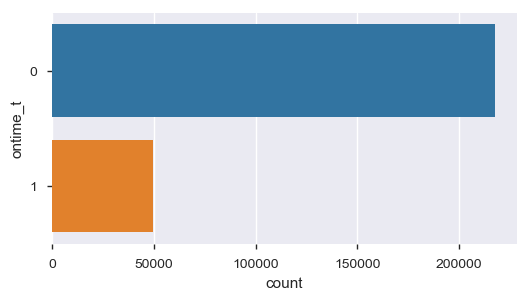

In [47]:
# Target Variable ontime_t 
count, ax = plt.subplots(figsize=(6,3))
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(df1, y = 'ontime_t', palette=c_palette)
plt.show()

In [48]:
# Creating another column for the new binned attribute source_t
df1["source_t"]=df1["source"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type        ...        longitude     ward  \
592709             C11  Animal Lost        ...         -71.0558  Ward 16   

        neighborhood         reason submittedphoto closed_dt  \
592709    Dorchester  Animal Issues            NaN       NaT   

                   open_dt target_dt ontime_t          source_t  
592709 2017-12-13 21:25:00       NaT        0  Constituent Call  

[1 rows x 22 columns]

In [49]:
## Viewing the unique values for the source
df1.source.unique()

array(['Constituent Call', 'Employee Generated', 'Self Service',
       'Citizens Connect App', 'City Worker App', 'Twitter',
       'Maximo Integration'], dtype=object)

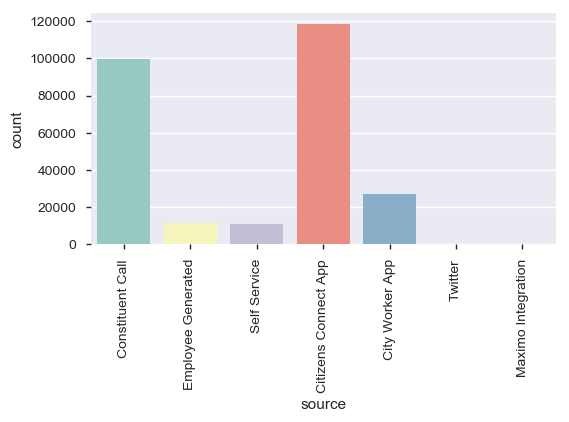

In [50]:
## SNS Countplot for the source variable
count, ax = plt.subplots(figsize=(6,3))
g=sns.countplot(x="source", data=df1, palette="Set3")
for item in g.get_xticklabels():
    item.set_rotation(90)

In [51]:
## Binnng the source_t into seven numerical bins
df1.source_t[df1.source == "Citizens Connect App"] = 1
df1.source_t[df1.source == "City Worker App"] = 2
df1.source_t[df1.source == "Constituent Call"] = 3
df1.source_t[df1.source == "Employee Generated"] = 4
df1.source_t[df1.source == "Maximo Integration"] = 5
df1.source_t[df1.source == "Self Service"] = 6
df1.source_t[df1.source == "Twitter"] = 7

df1.head(3)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                                       
593828  OVERDUE  Constituent Call                                       

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline                    INFO   
593828  Mayor's 24 Hour Hotline                    INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                                                  
593828                                                  

                                            type   ...    longitude     ward  \
592709                               Animal Lost   ...     -71.0558  Ward 16   
593771  General Comments For a Program or Policy   ...     -71.0587            
593828  General Comments For a Program or Policy   ...     -71.0587            

        neighborhood                       reason submittedphoto closed_dt  \
592709    Dorchester                Animal Issues            NaN       NaT   
593771                Employee & General Comments            NaN       NaT   
593828                Employee & General Comments            NaN       NaT   

                   open_dt           target_dt ontime_t source_t  
592709 2017-12-13 21:25:00                 NaT        0        3  
593771 2017-10-10 14:15:00 2017-10-24 14:15:00        1        3  
593828 2017-10-27 22:11:00 2017-11-14 08:30:00        1        3  

[3 rows x 22 columns]

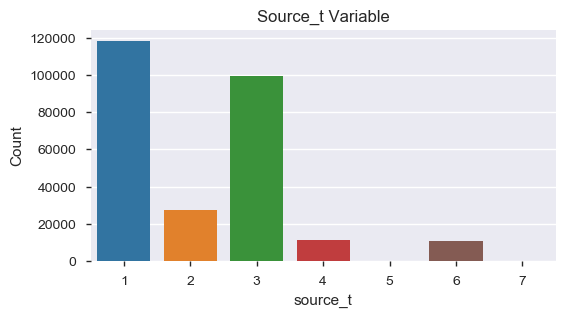

In [52]:
# Printing the Bar and Count Plot for Source_t Variable 
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('source_t', data=df1)
ax.set_title('Source_t Variable')
ax.set_xlabel('source_t')
ax.set_ylabel('Count')

plt.show()

In [53]:
# Cross Tabulation for Categorical souce_t variable and target variable "ontime"

source=pd.crosstab(df1.ontime_t, df1.source_t, margins=True)
source

source_t       1      2      3      4  5      6   7     All
ontime_t                                                   
0          95911  24985  77948   9306  2   9401  52  217605
1          22520   2287  21637   1994  0   1254  15   49707
All       118431  27272  99585  11300  2  10655  67  267312

In [54]:
# Creating another column for the new binned source_t2 attribute
df1["source_t2"]=df1["source_t"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type    ...        ward  neighborhood  \
592709             C11  Animal Lost    ...     Ward 16    Dorchester   

               reason submittedphoto closed_dt             open_dt target_dt  \
592709  Animal Issues            NaN       NaT 2017-12-13 21:25:00       NaT   

       ontime_t source_t source_t2  
592709        0        3         3  

[1 rows x 23 columns]

In [55]:
## Binning the rare source_t variables 5 and 7 to 6
df1.source_t2[df1.source_t == 5] = 6
df1.source_t2[df1.source_t == 7] = 6

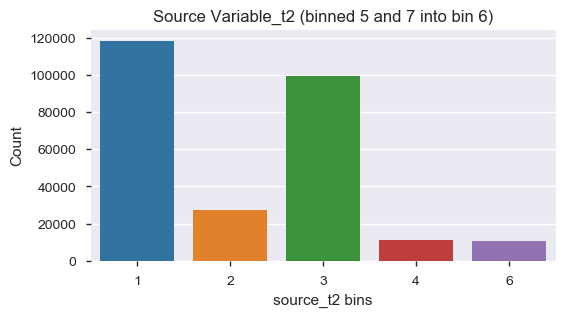

In [56]:
# Printing the Bar and Count Plot for the source_t2
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('source_t2', data=df1)
ax.set_title('Source Variable_t2 (binned 5 and 7 into bin 6)')
ax.set_xlabel('source_t2 bins')
ax.set_ylabel('Count')

plt.show()

In [57]:
# Cross Tabulation for Categorical souce_t2 variable and target variale "ontime"

source=pd.crosstab(df1.ontime_t, df1.source_t2, margins=True)
source

source_t2       1      2      3      4      6     All
ontime_t                                             
0           95911  24985  77948   9306   9455  217605
1           22520   2287  21637   1994   1269   49707
All        118431  27272  99585  11300  10724  267312

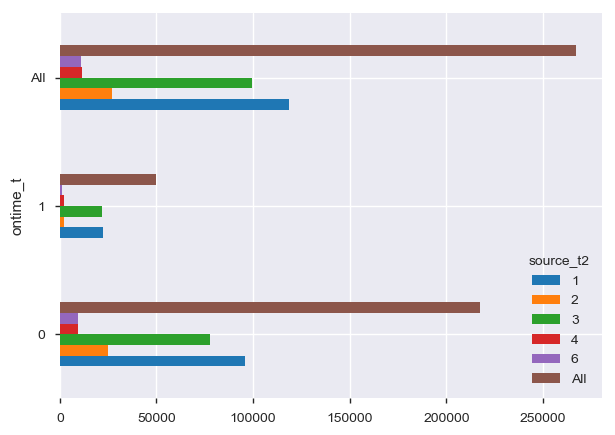

In [58]:
## Plotting the cross tab distribution for source_t2
source.plot.barh(figsize=(7,5))
plt.show()

In [59]:
########################################################################

In [60]:
## Viewing the unique values for the city_council_district
df1.city_council_district.unique()

array(['3', ' ', '9', '2', '5', '8', '7', '1', '4', '6', '0'],
      dtype=object)

In [61]:
## Replacing the nan values with 33
df1['city_council_district'] = df1['city_council_district'].replace(np.nan, 33)

In [62]:
## Binning the missing variables "" to the 33 bin and will be the standard missing bin number
df1.city_council_district[df1.city_council_district == ' '] = 33

In [63]:
## Viewing the unique values for the city_council_district
df1.city_council_district.unique()

array(['3', 33, '9', '2', '5', '8', '7', '1', '4', '6', '0'], dtype=object)

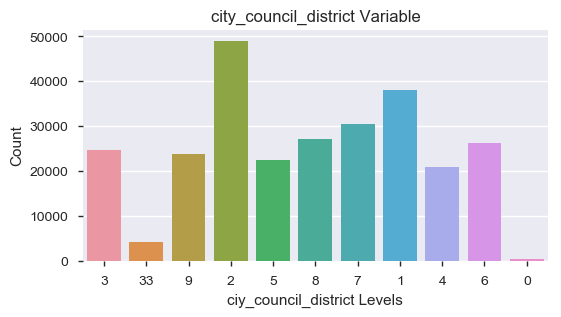

In [64]:
# Printing the Bar and Count Plot for city_council_district
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('city_council_district', data=df1)
ax.set_title('city_council_district Variable')
ax.set_xlabel('ciy_council_district Levels')
ax.set_ylabel('Count')

plt.show()

In [65]:
# Cross Tabulation for Categorical city council district and target variale "ontime_t"

city_council=pd.crosstab(df1.ontime_t, df1.city_council_district, margins=True)
city_council

city_council_district    33    0      1      2      3      4      5      6  \
ontime_t                                                                     
0                      2896  244  31850  40916  20206  16772  18159  20713   
1                      1320  139   6168   8109   4520   4106   4349   5630   
All                    4216  383  38018  49025  24726  20878  22508  26343   

city_council_district      7      8      9     All  
ontime_t                                            
0                      24237  22182  19430  217605  
1                       6236   4861   4269   49707  
All                    30473  27043  23699  267312

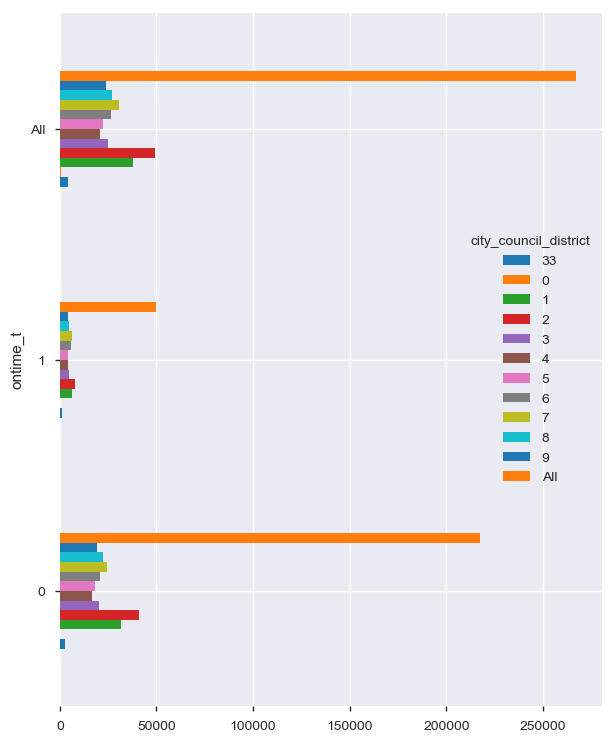

In [66]:
## Plotting the cross tab distribution for city council district
city_council.plot.barh(figsize=(7,9))
plt.show()

In [67]:
# Creating another column for the new binned source for city council district
df1["city_council_district_t"]=df1["city_council_district"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type           ...           neighborhood  \
592709             C11  Animal Lost           ...             Dorchester   

               reason  submittedphoto closed_dt             open_dt target_dt  \
592709  Animal Issues             NaN       NaT 2017-12-13 21:25:00       NaT   

       ontime_t source_t source_t2 city_council_district_t  
592709        0        3         3                       3  

[1 rows x 24 columns]

In [68]:
## Binning the 0 with 33 because its a rare event for city council district
df1.city_council_district_t[df1.city_council_district == "0"] = 33

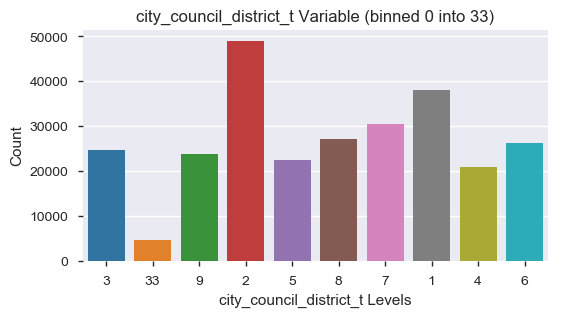

In [69]:
# Printing the Bar and Count Plot for city_council_district_t
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('city_council_district_t', data=df1)
ax.set_title('city_council_district_t Variable (binned 0 into 33)')
ax.set_xlabel('city_council_district_t Levels')
ax.set_ylabel('Count')

plt.show()

In [70]:
# Cross Tabulation for Categorical city council district_t and target variable "ontime_t"

city_council2=pd.crosstab(df1.ontime_t, df1.city_council_district_t, margins=True)
city_council2

city_council_district_t    33      1      2      3      4      5      6  \
ontime_t                                                                  
0                        3140  31850  40916  20206  16772  18159  20713   
1                        1459   6168   8109   4520   4106   4349   5630   
All                      4599  38018  49025  24726  20878  22508  26343   

city_council_district_t      7      8      9     All  
ontime_t                                              
0                        24237  22182  19430  217605  
1                         6236   4861   4269   49707  
All                      30473  27043  23699  267312

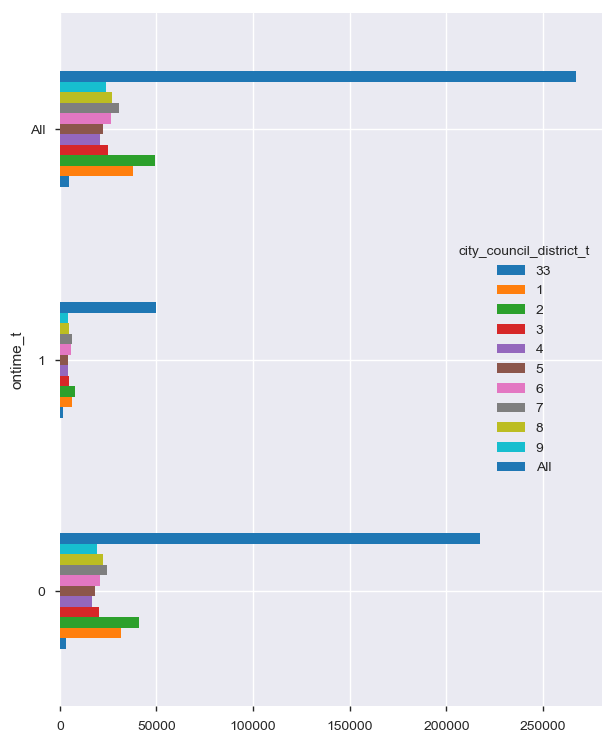

In [71]:
## Plotting the cross tab distribution for city council district_t
city_council2.plot.barh(figsize=(7,9))
plt.show()

In [72]:
########################################  Fire District Variable ########################################

In [73]:
## Viewing the unique values for the Fire District
df1.fire_district.unique()

array(['8', ' ', '11', '4', '9', '1', '3', '7', '12', '6', nan, '10'],
      dtype=object)

In [74]:
## Replacing the empty values with NAN for fire district
df1.replace(' ', np.nan, inplace=True)

In [75]:
## Viewing the unique values for the Fire District
df1.fire_district.unique()

array(['8', nan, '11', '4', '9', '1', '3', '7', '12', '6', '10'],
      dtype=object)

In [76]:
## Replacing the nan values with 33
df1['fire_district'] = df1['fire_district'].replace(np.nan, 33)

In [77]:
## Viewing the unique values for the Fire District
df1.fire_district.unique()

array(['8', 33, '11', '4', '9', '1', '3', '7', '12', '6', '10'],
      dtype=object)

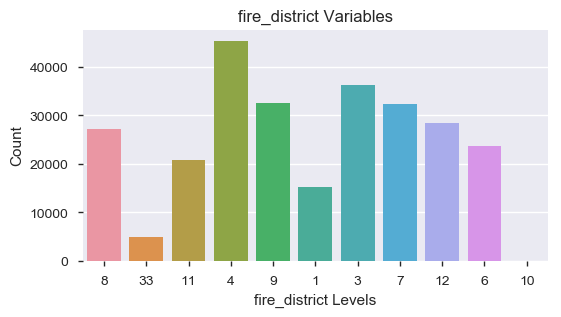

In [78]:
# Printing the Bar and Count Plot for Fire District Variable
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('fire_district', data=df1)
ax.set_title('fire_district Variables')
ax.set_xlabel('fire_district Levels')
ax.set_ylabel('Count')

plt.show()

In [79]:
# Cross Tabulation for Categorical Variable fire district and target variale "ontime_t"
fire_dist=pd.crosstab(df1.ontime_t, df1.fire_district, margins=True)
fire_dist

fire_district    33      1  10     11     12      3      4      6      7  \
ontime_t                                                                   
0              3456  12796   2  17132  23009  30114  37197  19958  26689   
1              1537   2348   0   3760   5498   6285   8251   3735   5743   
All            4993  15144   2  20892  28507  36399  45448  23693  32432   

fire_district      8      9     All  
ontime_t                             
0              21679  25573  217605  
1               5444   7106   49707  
All            27123  32679  267312

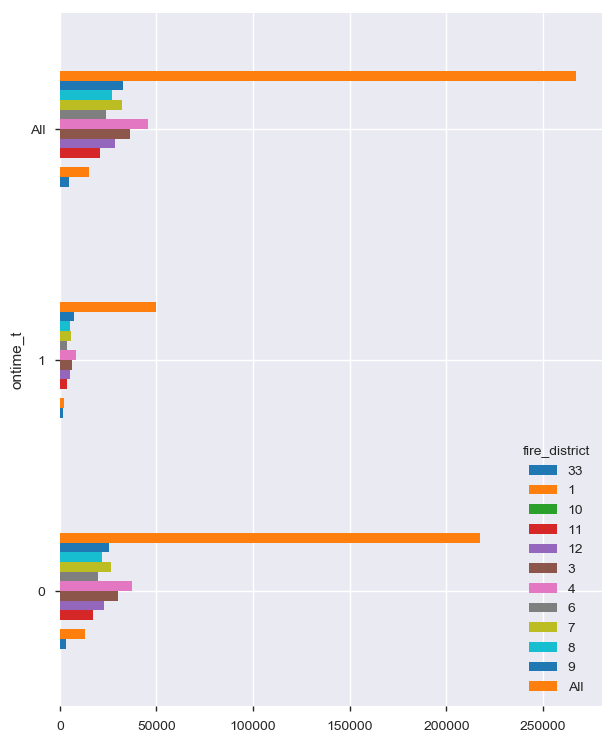

In [80]:
## Plotting the cross tab distribution for fire_district
fire_dist.plot.barh(figsize=(7,9))
plt.show()

In [81]:
# Creating another column for the binning of 33 and 10 for fire_district
df1["fire_district_t"]=df1["fire_district"]
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline          NaN       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                            NaN             NaN   

                                            type       ...        \
592709                               Animal Lost       ...         
593771  General Comments For a Program or Policy       ...         

                             reason  submittedphoto  closed_dt  \
592709                Animal Issues             NaN        NaT   
593771  Employee & General Comments             NaN        NaT   

                   open_dt           target_dt ontime_t source_t source_t2  \
592709 2017-12-13 21:25:00                 NaT        0        3         3   
593771 2017-10-10 14:15:00 2017-10-24 14:15:00        1        3         3   

       city_council_district_t fire_district_t  
592709                       3               8  
593771                      33              33  

[2 rows x 25 columns]

In [82]:
## Binning the level 10 fire district with the 33 level
df1.fire_district_t[df1.fire_district == "10"] = 33

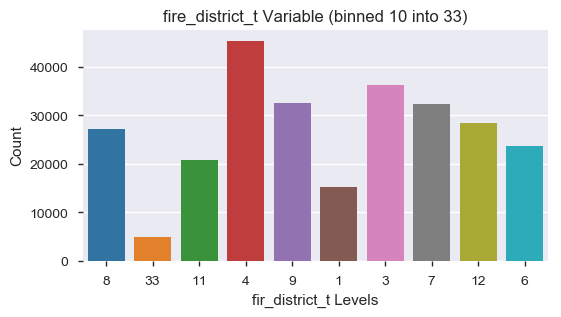

In [83]:
# Printing the Bar and Count Plot for fire_district_t
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('fire_district_t', data=df1)
ax.set_title('fire_district_t Variable (binned 10 into 33)')
ax.set_xlabel('fir_district_t Levels')
ax.set_ylabel('Count')

plt.show()

In [84]:
# Cross Tabulation for Categorical Variable fire district_t and target variale "ontime_t"
fire_dist2=pd.crosstab(df1.ontime_t, df1.fire_district_t, margins=True)
fire_dist2

fire_district_t    33      1     11     12      3      4      6      7      8  \
ontime_t                                                                        
0                3458  12796  17132  23009  30114  37197  19958  26689  21679   
1                1537   2348   3760   5498   6285   8251   3735   5743   5444   
All              4995  15144  20892  28507  36399  45448  23693  32432  27123   

fire_district_t      9     All  
ontime_t                        
0                25573  217605  
1                 7106   49707  
All              32679  267312

In [85]:
# Creating another column for the new binned variable for Fire District into two districts
df1["fire_district_t2"]=df1["fire_district"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type       ...        submittedphoto  \
592709             C11  Animal Lost       ...                   NaN   

        closed_dt             open_dt target_dt ontime_t source_t source_t2  \
592709        NaT 2017-12-13 21:25:00       NaT        0        3         3   

       city_council_district_t fire_district_t fire_district_t2  
592709                       3               8                8  

[1 rows x 26 columns]

In [86]:
## Dividing the fire districts into the Division 1 and 2 for Boston
## Please note that the missing values and 10 were lumped into Distict 2
df1.fire_district_t2[df1.fire_district == "1"] = 1
df1.fire_district_t2[df1.fire_district == "3"] = 1
df1.fire_district_t2[df1.fire_district == "4"] = 1
df1.fire_district_t2[df1.fire_district == "6"] = 1
df1.fire_district_t2[df1.fire_district == "11"] = 1

df1.fire_district_t2[df1.fire_district == "7"] = 2
df1.fire_district_t2[df1.fire_district == "8"] = 2
df1.fire_district_t2[df1.fire_district == "9"] = 2
df1.fire_district_t2[df1.fire_district == "12"] = 2
df1.fire_district_t2[df1.fire_district == "10"] = 2
df1.fire_district_t2[df1.fire_district == 33] = 2

df1.head(3)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   
593828  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline          NaN       INFO   
593828  Mayor's 24 Hour Hotline          NaN       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                            NaN             NaN   
593828                            NaN             NaN   

                                            type       ...         \
592709                               Animal Lost       ...          
593771  General Comments For a Program or Policy       ...          
593828  General Comments For a Program or Policy       ...          

       submittedphoto  closed_dt             open_dt           target_dt  \
592709            NaN        NaT 2017-12-13 21:25:00                 NaT   
593771            NaN        NaT 2017-10-10 14:15:00 2017-10-24 14:15:00   
593828            NaN        NaT 2017-10-27 22:11:00 2017-11-14 08:30:00   

       ontime_t source_t source_t2 city_council_district_t fire_district_t  \
592709        0        3         3                       3               8   
593771        1        3         3                      33              33   
593828        1        3         3                      33              33   

       fire_district_t2  
592709                2  
593771                2  
593828                2  

[3 rows x 26 columns]

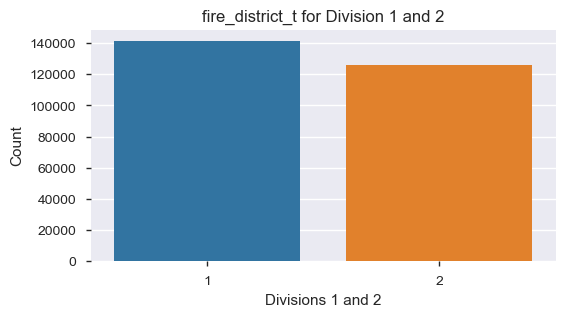

In [87]:
# Printing the Bar and Count Plot for two districts for fire_district and target variable ontime_t
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('fire_district_t2', data=df1)
ax.set_title('fire_district_t for Division 1 and 2')
ax.set_xlabel('Divisions 1 and 2')
ax.set_ylabel('Count')

plt.show()

In [88]:
# Cross Tabulation for Categorical Variable fire district_t2
fire_dist3=pd.crosstab(df1.ontime_t, df1.fire_district_t2, margins=True)
fire_dist3

fire_district_t2       1       2     All
ontime_t                                
0                 117197  100408  217605
1                  24379   25328   49707
All               141576  125736  267312

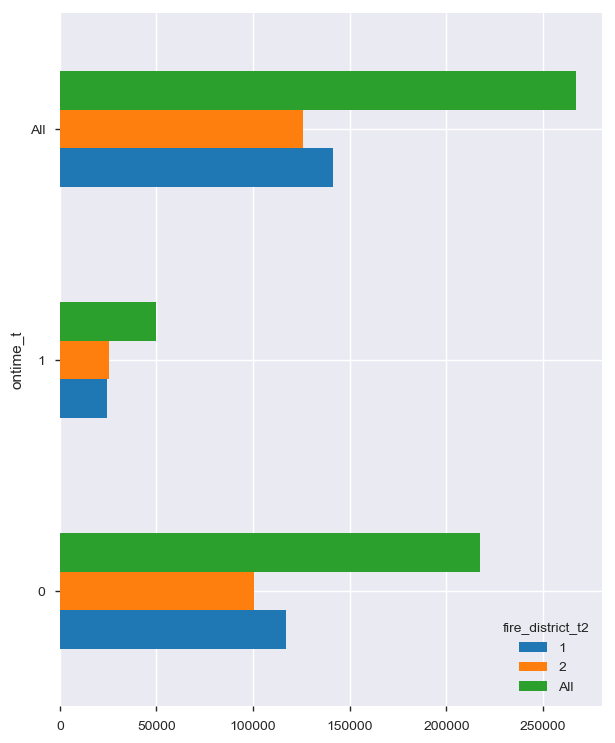

In [89]:
## Plotting the cross tab distribution forfire_district_t2
fire_dist3.plot.barh(figsize=(7,9))
plt.show()

In [90]:
######################################################### Subject  ###############################

In [91]:
## Viewing the unique values for subject attribute
df1.subject.unique()

array(['Animal Control', "Mayor's 24 Hour Hotline",
       'Inspectional Services', 'Public Works Department',
       'Boston Water & Sewer Commission', 'Property Management',
       'Transportation - Traffic Division',
       'Parks & Recreation Department', 'Boston Police Department',
       'Neighborhood Services', 'Consumer Affairs & Licensing'],
      dtype=object)

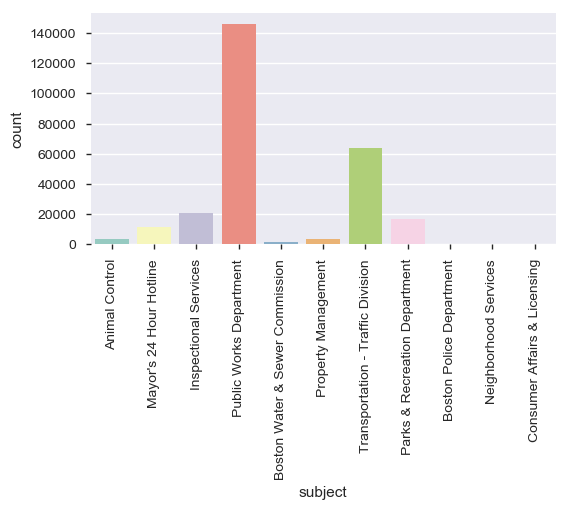

In [92]:
## SNS Countplot for the subject variable
count, ax = plt.subplots(figsize=(6,3))
g=sns.countplot(x="subject", data=df1, palette="Set3")
for item in g.get_xticklabels():
    item.set_rotation(90)

In [93]:
# Creating another column for the new binned subject variable
df1["subject_t"]=df1["subject"]
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline          NaN       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                            NaN             NaN   

                                            type           ...             \
592709                               Animal Lost           ...              
593771  General Comments For a Program or Policy           ...              

       closed_dt             open_dt           target_dt ontime_t source_t  \
592709       NaT 2017-12-13 21:25:00                 NaT        0        3   
593771       NaT 2017-10-10 14:15:00 2017-10-24 14:15:00        1        3   

       source_t2 city_council_district_t fire_district_t fire_district_t2  \
592709         3                       3               8                2   
593771         3                      33              33                2   

                      subject_t  
592709           Animal Control  
593771  Mayor's 24 Hour Hotline  

[2 rows x 27 columns]

In [94]:
## Creating a unique number or bin for each of the 11 subject categories
df1.subject_t[df1.subject == "Animal Control"] = 1
df1.subject_t[df1.subject == "Boston Police Department"] = 2
df1.subject_t[df1.subject == "Boston Water & Sewer Commission"] = 3
df1.subject_t[df1.subject == "Consumer Affairs & Licensing"] = 4
df1.subject_t[df1.subject == "Inspectional Services"] = 5
df1.subject_t[df1.subject == "Mayor's 24 Hour Hotline"] = 6
df1.subject_t[df1.subject == "Neighborhood Services"] = 7
df1.subject_t[df1.subject == "Parks & Recreation Department"] = 8
df1.subject_t[df1.subject == "Property Management"] = 9
df1.subject_t[df1.subject == "Public Works Department"] = 10
df1.subject_t[df1.subject == "Transportation - Traffic Division"] = 11

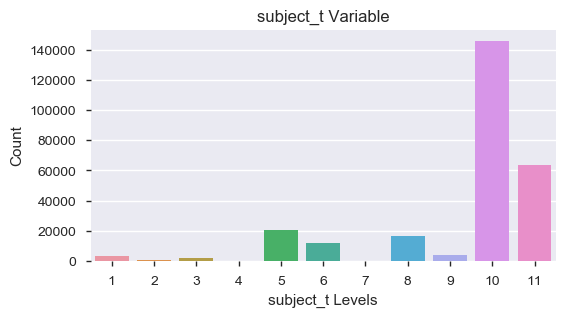

In [95]:
# Printing the Bar and Count Plot for subject_t variable
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('subject_t', data=df1)
ax.set_title('subject_t Variable')
ax.set_xlabel('subject_t Levels')
ax.set_ylabel('Count')

plt.show()

In [96]:
# Cross Tabulation for Categorical Variable  subject_t and target variale "ontime_t"
subject=pd.crosstab(df1.ontime_t, df1.subject_t, margins=True)
subject

subject_t     1    2     3   4      5      6   7      8     9      10     11  \
ontime_t                                                                       
0          3242  215  1609  41  10923  10631  28  13548  2516  121573  53279   
1             0    0     0   0   9658    888   0   3081  1050   24587  10443   
All        3242  215  1609  41  20581  11519  28  16629  3566  146160  63722   

subject_t     All  
ontime_t           
0          217605  
1           49707  
All        267312

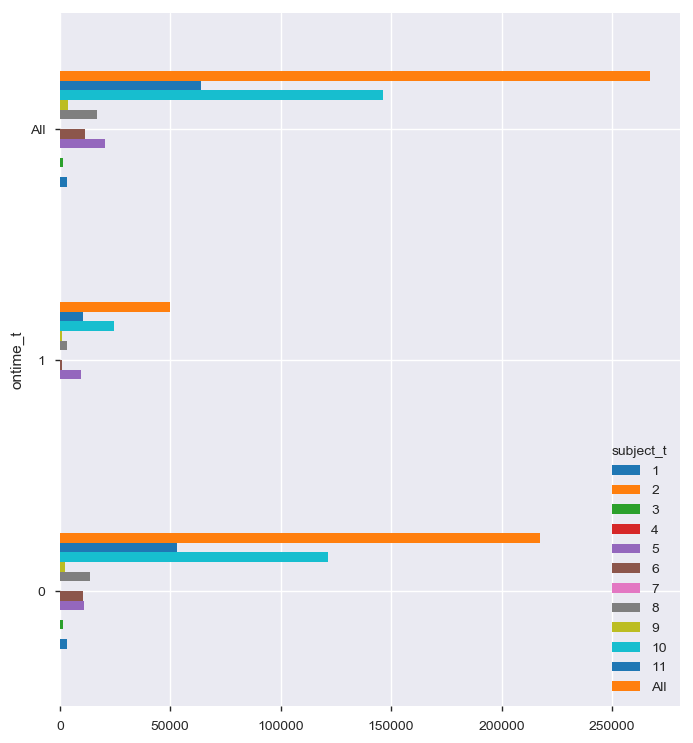

In [97]:
## Plotting the cross tab distribution for subject_t
subject.plot.barh(figsize=(8,9))
plt.show()

In [98]:
# Creating another variable to bin the rare values into the 7 level for subject_t2
df1["subject_t2"]=df1["subject_t"]
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline          NaN       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                            NaN             NaN   

                                            type    ...      \
592709                               Animal Lost    ...       
593771  General Comments For a Program or Policy    ...       

                   open_dt           target_dt  ontime_t source_t source_t2  \
592709 2017-12-13 21:25:00                 NaT         0        3         3   
593771 2017-10-10 14:15:00 2017-10-24 14:15:00         1        3         3   

       city_council_district_t fire_district_t fire_district_t2 subject_t  \
592709                       3               8                2         1   
593771                      33              33                2         6   

       subject_t2  
592709          1  
593771          6  

[2 rows x 28 columns]

In [99]:
## Binning the subject variables 1,2,3,4 into 7
df1.subject_t2[df1.subject_t == 1] = 7
df1.subject_t2[df1.subject_t == 2] = 7
df1.subject_t2[df1.subject_t == 3] = 7
df1.subject_t2[df1.subject_t == 4] = 7

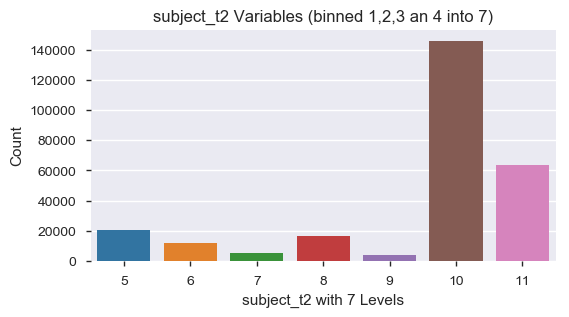

In [100]:
# Printing the Bar and Count Plot for the binned subject_t2 variable
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('subject_t2', data=df1)
ax.set_title('subject_t2 Variables (binned 1,2,3 an 4 into 7)')
ax.set_xlabel('subject_t2 with 7 Levels')
ax.set_ylabel('Count')
plt.show()

In [101]:
#################################### Power District ##############################

In [102]:
## unique values for power district variable 
df1.pwd_district.unique()

array(['7', nan, '4', '1C', '6', '8', '2', '9', '1B', '3', '10A', '10B',
       '1A', '5'], dtype=object)

In [103]:
## replacing the nan values with a "0" for pwd_district
df1['pwd_district'] = df1['pwd_district'].replace(np.nan, 0)

In [104]:
## unique values for pwd_district
df1.pwd_district.unique()

array(['7', 0, '4', '1C', '6', '8', '2', '9', '1B', '3', '10A', '10B',
       '1A', '5'], dtype=object)

In [105]:
## Replacing the nan and 0 value with a number of 33 and will be the missing bin
df1.pwd_district[df1.pwd_district == 0] = 33

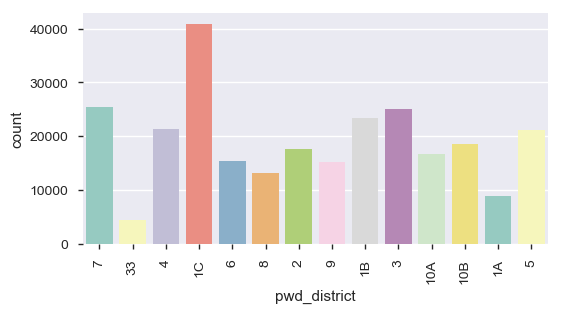

In [106]:
## SNS Countplot for the pwd_district variable
count, ax = plt.subplots(figsize=(6,3))
g=sns.countplot(x="pwd_district", data=df1, palette="Set3")
for item in g.get_xticklabels():
    item.set_rotation(90)

In [107]:
# Creating another column for the pwd_istrict Variable 
df1["pwd_district_t"]=df1["pwd_district"]
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                            NaN             NaN   

                                            type      ...        \
592709                               Animal Lost      ...         
593771  General Comments For a Program or Policy      ...         

                 target_dt  ontime_t  source_t source_t2  \
592709                 NaT         0         3         3   
593771 2017-10-24 14:15:00         1         3         3   

       city_council_district_t fire_district_t fire_district_t2 subject_t  \
592709                       3               8                2         1   
593771                      33              33                2         6   

       subject_t2 pwd_district_t  
592709          7              7  
593771          6             33  

[2 rows x 29 columns]

In [108]:
## Renaming the Power Districts that have letters to have unique number for Analysis 
df1.pwd_district_t[df1.pwd_district == "1A"] = 20
df1.pwd_district_t[df1.pwd_district == "1B"] = 21
df1.pwd_district_t[df1.pwd_district == "1C"] = 22
df1.pwd_district_t[df1.pwd_district == "10A"] = 23
df1.pwd_district_t[df1.pwd_district == "10B"] = 24
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type      ...       target_dt  ontime_t  \
592709             C11  Animal Lost      ...             NaT         0   

        source_t source_t2 city_council_district_t fire_district_t  \
592709         3         3                       3               8   

       fire_district_t2 subject_t subject_t2 pwd_district_t  
592709                2         1          7              7  

[1 rows x 29 columns]

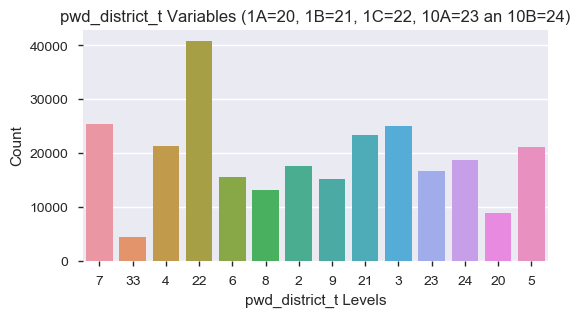

In [109]:
# Printing the Bar and Count Plot for the cleaned pwd_district bin
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('pwd_district_t', data=df1)
ax.set_title('pwd_district_t Variables (1A=20, 1B=21, 1C=22, 10A=23 an 10B=24)')
ax.set_xlabel('pwd_district_t Levels')
ax.set_ylabel('Count')

plt.show()

In [110]:
# Cross Tabulation for Categorical Variable pwd_district_t and target variale "ontime"
power=pd.crosstab(df1.ontime_t, df1.pwd_district_t, margins=True)
power

pwd_district_t    20     21     22     23     24    33      2      3      4  \
ontime_t                                                                      
0               6954  19978  33806  12646  15212  3023  13679  20651  17466   
1               1870   3451   7068   4034   3422  1400   3958   4416   3895   
All             8824  23429  40874  16680  18634  4423  17637  25067  21361   

pwd_district_t      5      6      7      8      9     All  
ontime_t                                                   
0               17855  12582  20316  10641  12796  217605  
1                3299   2893   5102   2551   2348   49707  
All             21154  15475  25418  13192  15144  267312

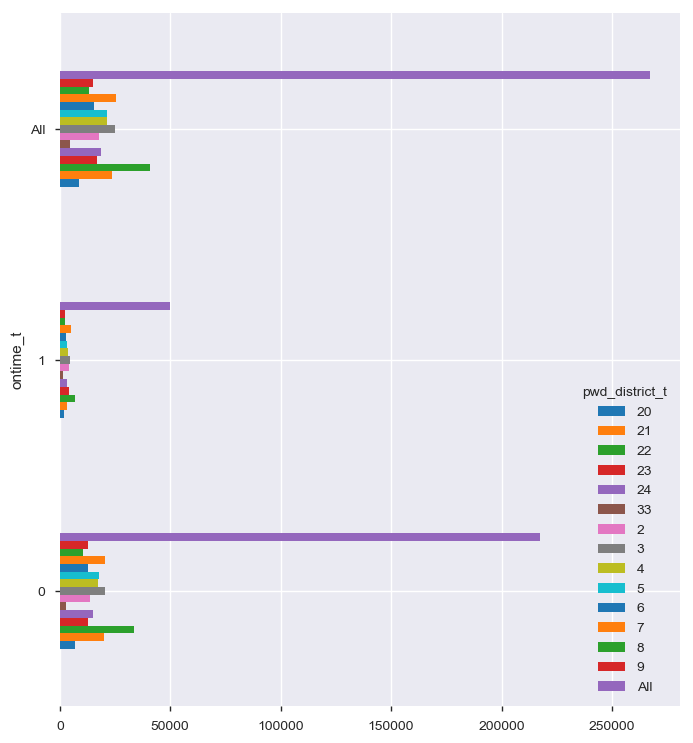

In [111]:
## Plotting the cross tab distribution for pwd_district_t and ontime_t
power.plot.barh(figsize=(8,9))
plt.show()

In [112]:
########################################## Department ###############################################

In [113]:
## unique values for department variable
df1.department.unique()

array(['ANML', 'INFO', 'ISD', 'PWDx', 'BWSC', 'PROP', 'BTDT', 'PARK',
       'GEN_', 'BHA_', 'ONS_', 'DND_', 'BPD_', 'BPS_', 'DISB'],
      dtype=object)

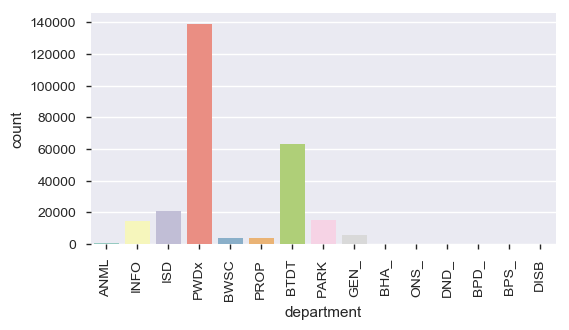

In [114]:
## SNS Countplot for the department variable
count, ax = plt.subplots(figsize=(6,3))
g=sns.countplot(x="department", data=df1, palette="Set3")
for item in g.get_xticklabels():
    item.set_rotation(90)

In [115]:
# Creating another column for the department variable
df1["department_t"]=df1["department"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type     ...      ontime_t  source_t  \
592709             C11  Animal Lost     ...             0         3   

        source_t2 city_council_district_t fire_district_t fire_district_t2  \
592709          3                       3               8                2   

       subject_t subject_t2 pwd_district_t department_t  
592709         1          7              7         ANML  

[1 rows x 30 columns]

In [116]:
## Creating a unique number for each department attribute for analysis

df1.department_t[df1.department == "ANML"] = 1
df1.department_t[df1.department == "BHA_"] = 2
df1.department_t[df1.department == "BPD_"] = 3
df1.department_t[df1.department == "BPS_"] = 4
df1.department_t[df1.department == "BTDT"] = 5
df1.department_t[df1.department == "BWSC"] = 6
df1.department_t[df1.department == "DISB"] = 7
df1.department_t[df1.department == "DND_"] = 8
df1.department_t[df1.department == "GEN_"] = 9
df1.department_t[df1.department == "INFO"] = 10
df1.department_t[df1.department == "ISD"] =  11
df1.department_t[df1.department == "ONS_"] = 12
df1.department_t[df1.department == "PARK"] = 13
df1.department_t[df1.department == "PROP"] = 14
df1.department_t[df1.department == "PWDx"] = 15

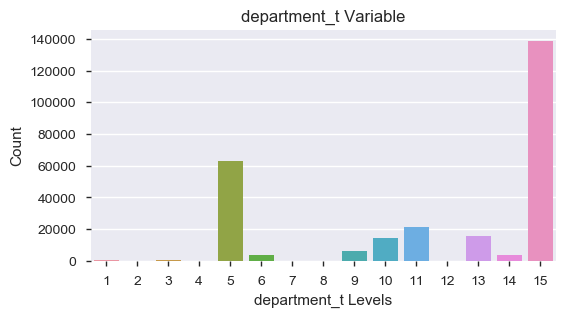

In [117]:
# Printing the Bar and Count Plot for Department Variable
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('department_t', data=df1)
ax.set_title('department_t Variable')
ax.set_xlabel('department_t Levels')
ax.set_ylabel('Count')

plt.show()

In [118]:
# Cross Tabulation for Categorical Department Variable Department Type and target variale "ontime"

department=pd.crosstab(df1.ontime_t, df1.department_t, margins=True)
department

department_t    1   2    3    4      5     6   7   8     9     10     11  12  \
ontime_t                                                                       
0             533   9   24   10  54857  1679   9   6  5955   5726  11035  33   
1              31  60  193  109   8143  2190   8  17     6   8665  10124  60   
All           564  69  217  119  63000  3869  17  23  5961  14391  21159  93   

department_t     13    14      15     All  
ontime_t                                   
0             13309  2529  121891  217605  
1              2017  1142   16942   49707  
All           15326  3671  138833  267312

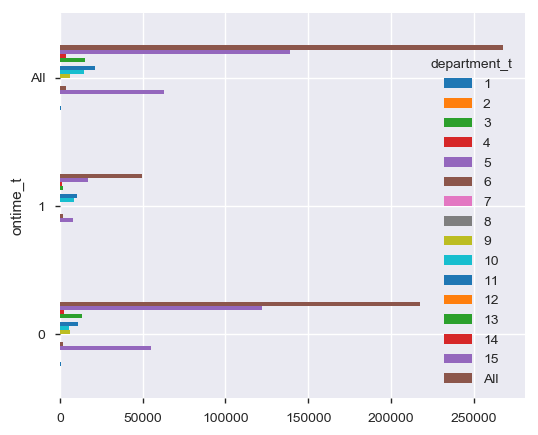

In [119]:
## Plotting the cross tab distribution for department variable 
department.plot.barh(figsize=(6,5))
plt.show()

In [120]:
# Creating another column for binning the department levels with minimal values bin 12
df1["department_t2"]=df1["department_t"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type      ...      source_t  source_t2  \
592709             C11  Animal Lost      ...             3          3   

        city_council_district_t fire_district_t fire_district_t2 subject_t  \
592709                        3               8                2         1   

       subject_t2 pwd_district_t department_t department_t2  
592709          7              7            1             1  

[1 rows x 31 columns]

In [121]:
# Binning the department levels 1, 2, 3, 4, 7, 8 into 12 with minimal values to number 7
df1.department_t2[df1.department_t == 1] = 12
df1.department_t2[df1.department_t == 2] = 12
df1.department_t2[df1.department_t == 3] = 12
df1.department_t2[df1.department_t == 4] = 12
df1.department_t2[df1.department_t == 7] = 12
df1.department_t2[df1.department_t == 8] = 12

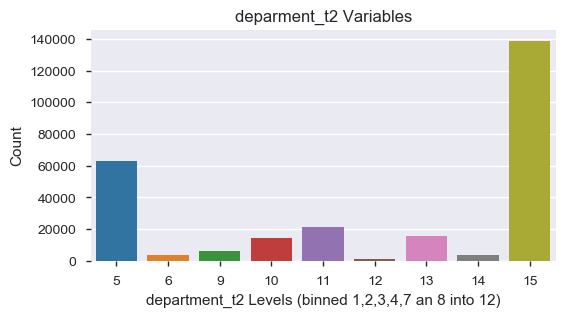

In [122]:
# Printing the Bar and Count Plot for department_t2
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('department_t2', data=df1)
ax.set_title('deparment_t2 Variables')
ax.set_xlabel("department_t2 Levels (binned 1,2,3,4,7 an 8 into 12)")
ax.set_ylabel('Count')

plt.show()

In [123]:
########################################### Neighborhood

In [124]:
## unique values for neighborhood variables
df1.neighborhood_services_district.unique()

array(['7', nan, '15', '4', '6', '10', '14', '13', '1', '9', '8', '3',
       '12', '11', '2', '5', '0'], dtype=object)

In [125]:
## replacing all nan values with the number 33 for this neighborhood variable
df1['neighborhood_services_district'] = df1['neighborhood_services_district'].replace(np.nan, 33)

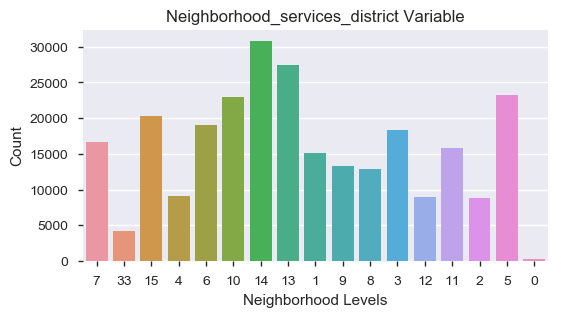

In [126]:
# Printing the Bar and Count Plot for Neighborhood Services District
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('neighborhood_services_district', data=df1)
ax.set_title('Neighborhood_services_district Variable')
ax.set_xlabel('Neighborhood Levels')
ax.set_ylabel('Count')

plt.show()

In [127]:
# Cross Tabulation for Categorical Variable neibhborhood services district and target variable ontime
neigh=pd.crosstab(df1.ontime_t, df1.neighborhood_services_district, margins=True)
neigh

neighborhood_services_district    33    0      1     10     11    12     13  \
ontime_t                                                                      
0                               2896  150  12796  18630  12041  7301  22204   
1                               1320  124   2348   4390   3715  1646   5234   
All                             4216  274  15144  23020  15756  8947  27438   

neighborhood_services_district     14     15     2      3     4      5      6  \
ontime_t                                                                        
0                               24807  16731  6951  15264  7386  19558  16199   
1                                6025   3622  1862   3041  1770   3641   2773   
All                             30832  20353  8813  18305  9156  23199  18972   

neighborhood_services_district      7      8      9     All  
ontime_t                                                     
0                               13397  10748  10546  217605  
1                                3217   2185   2794   49707  
All                             16614  12933  13340  267312

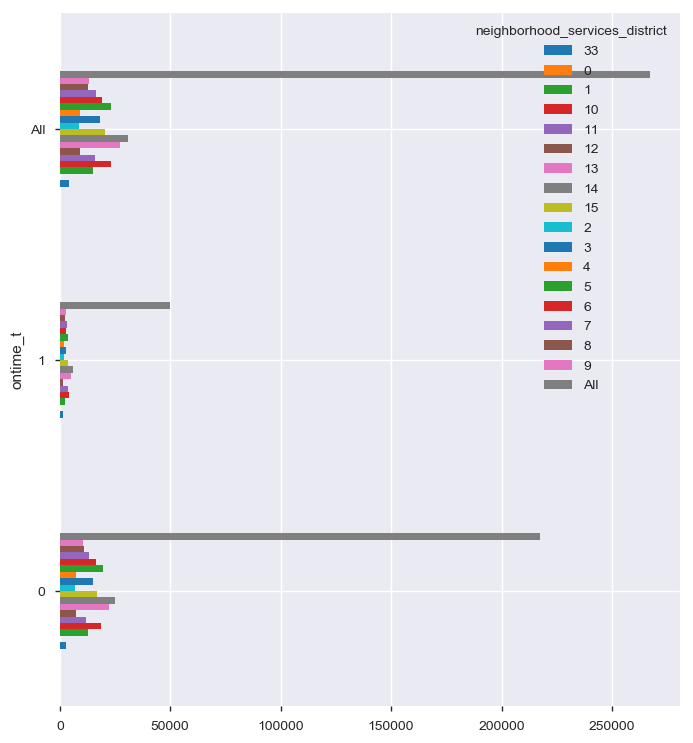

In [128]:
## Plotting the cross tab distribution for neighborhood services district
neigh.plot.barh(figsize=(8,9))
plt.show()

In [129]:
################################################### police district variables #####################################

In [130]:
## unique values for police district variables
df1.police_district.unique()

array(['C11', nan, 'D14', 'D4', 'E5', 'E18', 'B2', 'A7', 'A1', 'B3',
       'E13', 'A15', 'C6'], dtype=object)

In [131]:
## Count for police_distict
df1.police_district.count()

262894

In [132]:
## Creating another variable for the transformed police district variable
df1['police_district'] = df1['police_district'].replace(np.NAN, 33)

In [133]:
## Double checking the count for the police distict
df1.police_district.count()

267312

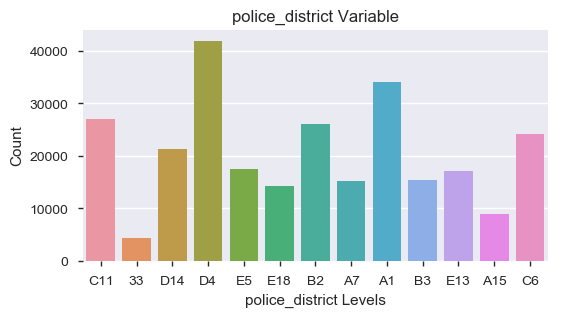

In [134]:
# Printing the Bar and Count Plot for police_district
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('police_district', data=df1)
ax.set_title('police_district Variable')
ax.set_xlabel('police_district Levels')
ax.set_ylabel('Count')

plt.show()

In [135]:
# Creating another column for binning the police_district create unique numbers for analysis 
df1["police_district_t"]=df1["police_district"]
df1.head(3)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   
593828  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   
593828  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   
593828                             33              33   

                                            type        ...        source_t2  \
592709                               Animal Lost        ...                3   
593771  General Comments For a Program or Policy        ...                3   
593828  General Comments For a Program or Policy        ...                3   

        city_council_district_t  fire_district_t fire_district_t2 subject_t  \
592709                        3                8                2         1   
593771                       33               33                2         6   
593828                       33               33                2         6   

       subject_t2 pwd_district_t department_t department_t2 police_district_t  
592709          7              7            1            12               C11  
593771          6             33           10            10                33  
593828          6             33           10            10                33  

[3 rows x 32 columns]

In [136]:
## Tranforming the Police Districts to a unique number
df1.police_district_t[df1.police_district == "E5"] = 5
df1.police_district_t[df1.police_district == "E18"] = 18
df1.police_district_t[df1.police_district == "C11"] = 11
df1.police_district_t[df1.police_district == "E13"] = 13
df1.police_district_t[df1.police_district == "D4"] = 4
df1.police_district_t[df1.police_district == "A1"] = 1
df1.police_district_t[df1.police_district == "B2"] = 2
df1.police_district_t[df1.police_district == "C6"] = 6
df1.police_district_t[df1.police_district == "B3"] = 3
df1.police_district_t[df1.police_district == "A7"] = 7
df1.police_district_t[df1.police_district == "A15"] = 15
df1.police_district_t[df1.police_district == "D14"] = 14


df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type        ...        source_t2  \
592709                               Animal Lost        ...                3   
593771  General Comments For a Program or Policy        ...                3   

        city_council_district_t  fire_district_t fire_district_t2 subject_t  \
592709                        3                8                2         1   
593771                       33               33                2         6   

       subject_t2 pwd_district_t department_t department_t2 police_district_t  
592709          7              7            1            12                11  
593771          6             33           10            10                33  

[2 rows x 32 columns]

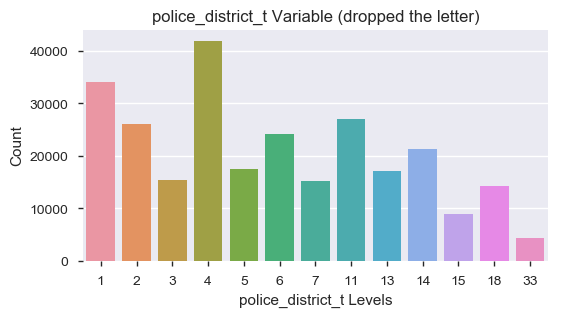

In [137]:
# Printing the Bar and Count Plot for police_district
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('police_district_t', data=df1)
ax.set_title('police_district_t Variable (dropped the letter)')
ax.set_xlabel('police_district_t Levels')
ax.set_ylabel('Count')

plt.show()

In [138]:
# Cross Tabulation for Categorical Police District Variable Type and ontime_t
police=pd.crosstab(df1.ontime_t, df1.police_district_t, margins=True)
police

police_district_t      1      2      3      4      5      6      7     11  \
ontime_t                                                                    
0                  28427  20823  12181  34516  14148  20353  12798  22275   
1                   5637   5206   3227   7462   3302   3913   2349   4787   
All                34064  26029  15408  41978  17450  24266  15147  27062   

police_district_t     13     14    15     18    33     All  
ontime_t                                                    
0                  13164  17460  6954  11486  3020  217605  
1                   3956   3878  1870   2722  1398   49707  
All                17120  21338  8824  14208  4418  267312

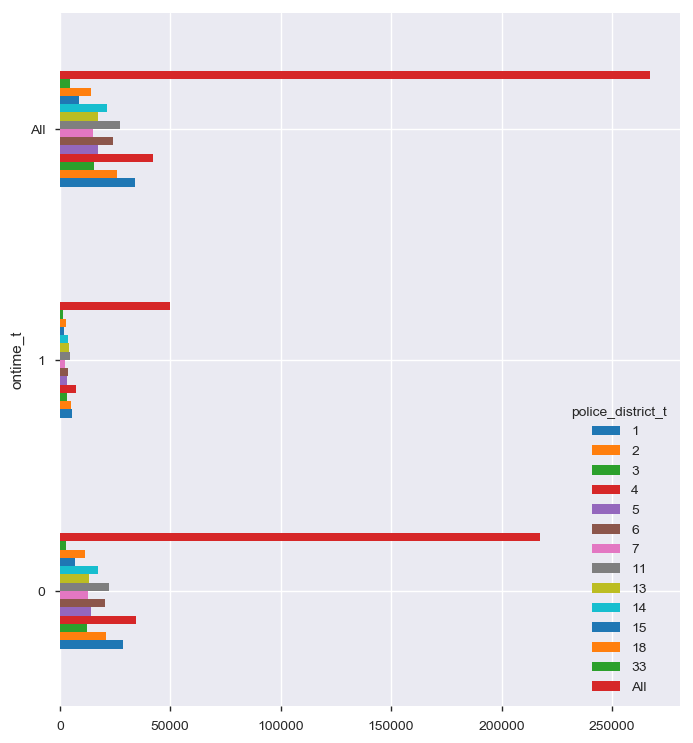

In [139]:
## Plotting the cross tab distribution for Police District Variable Type and ontime_t
police.plot.barh(figsize=(8,9))
plt.show()

In [140]:
########################################### Neighborhood  ###########################################

In [141]:
## Looking at unique neigbhorhood variables
df1.neighborhood.unique()

array(['Dorchester', nan, 'Allston / Brighton', 'South End', 'Roslindale',
       'Back Bay', 'Allston', 'Hyde Park', 'Jamaica Plain', 'East Boston',
       'Beacon Hill', 'Greater Mattapan', 'Roxbury', 'Mission Hill',
       'Boston', 'Charlestown', 'Downtown / Financial District',
       'South Boston / South Boston Waterfront', 'West Roxbury',
       'Fenway / Kenmore / Audubon Circle / Longwood', 'South Boston',
       'Brighton', 'Mattapan', 'Chestnut Hill'], dtype=object)

In [142]:
## Creating another variable for the neigborhood district variable and replacing nan with unknown values
df1['neighborhood'] = df1['neighborhood'].replace(np.nan, 'UNKNOWN')

In [143]:
## printing the unique values found in neighborhood variable.
df1.neighborhood.unique()

array(['Dorchester', 'UNKNOWN', 'Allston / Brighton', 'South End',
       'Roslindale', 'Back Bay', 'Allston', 'Hyde Park', 'Jamaica Plain',
       'East Boston', 'Beacon Hill', 'Greater Mattapan', 'Roxbury',
       'Mission Hill', 'Boston', 'Charlestown',
       'Downtown / Financial District',
       'South Boston / South Boston Waterfront', 'West Roxbury',
       'Fenway / Kenmore / Audubon Circle / Longwood', 'South Boston',
       'Brighton', 'Mattapan', 'Chestnut Hill'], dtype=object)

In [144]:
# Cross Tabulation for Categorical Police District Variable Type and Adoptionspeed 
neigh=pd.crosstab(df1.ontime_t, df1.neighborhood, margins=True)
neigh

neighborhood  Allston  Allston / Brighton  Back Bay  Beacon Hill  Boston  \
ontime_t                                                                   
0                 275               16225     11464         7441    6622   
1                  87                3541      2581         1125    1590   
All               362               19766     14045         8566    8212   

neighborhood  Brighton  Charlestown  Chestnut Hill  Dorchester  \
ontime_t                                                         
0                  862         6957             16       29799   
1                  233         1871              3        6624   
All               1095         8828             19       36423   

neighborhood  Downtown / Financial District   ...    Mattapan  Mission Hill  \
ontime_t                                      ...                             
0                                     14999   ...         232          4014   
1                                      3195   ...         108          1167   
All                                   18194   ...         340          5181   

neighborhood  Roslindale  Roxbury  South Boston  \
ontime_t                                          
0                   7758    20022          1430   
1                   1862     4393           346   
All                 9620    24415          1776   

neighborhood  South Boston / South Boston Waterfront  South End  UNKNOWN  \
ontime_t                                                                   
0                                              16680      13960     3107   
1                                               3090       2257     1433   
All                                            19770      16217     4540   

neighborhood  West Roxbury     All  
ontime_t                            
0                     7864  217605  
1                     1798   49707  
All                   9662  267312  

[3 rows x 25 columns]

In [145]:
 # Creating another column for the new neighborhood variable type for one hot encoding
df1["neighborhood_t"]=df1["neighborhood"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type      ...       city_council_district_t  \
592709             C11  Animal Lost      ...                             3   

        fire_district_t  fire_district_t2 subject_t subject_t2 pwd_district_t  \
592709                8                 2         1          7              7   

       department_t department_t2 police_district_t neighborhood_t  
592709            1            12                11     Dorchester  

[1 rows x 33 columns]

In [146]:
## One hot encoding for the different neighborhood types found in this dataset 
le = LabelEncoder() 
  
df1['neighborhood_t']= le.fit_transform(df1['neighborhood_t']) 
df1.head(5)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   
593828  OVERDUE  Constituent Call                    33            33   
594133   ONTIME  Constituent Call                     9            11   
594213  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   
593828  Mayor's 24 Hour Hotline           33       INFO   
594133           Animal Control            4       ANML   
594213  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   
593828                             33              33   
594133                             15             D14   
594213                             33              33   

                                            type      ...        \
592709                               Animal Lost      ...         
593771  General Comments For a Program or Policy      ...         
593828  General Comments For a Program or Policy      ...         
594133                              Animal Found      ...         
594213  General Comments For a Program or Policy      ...         

       city_council_district_t  fire_district_t  fire_district_t2 subject_t  \
592709                       3                8                 2         1   
593771                      33               33                 2         6   
593828                      33               33                 2         6   
594133                       9               11                 1         1   
594213                      33               33                 2         6   

       subject_t2 pwd_district_t department_t department_t2 police_district_t  \
592709          7              7            1            12                11   
593771          6             33           10            10                33   
593828          6             33           10            10                33   
594133          7              4            1            12                14   
594213          6             33           10            10                33   

       neighborhood_t  
592709              8  
593771             22  
593828             22  
594133              1  
594213             22  

[5 rows x 33 columns]

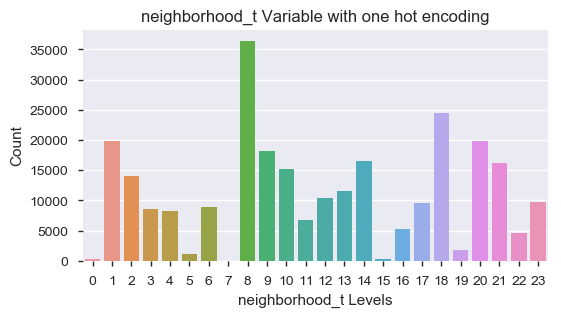

In [147]:
# Printing the Bar and Count Plot for neigborhood_district_t
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('neighborhood_t', data=df1)
ax.set_title('neighborhood_t Variable with one hot encoding')
ax.set_xlabel('neighborhood_t Levels')
ax.set_ylabel('Count')

plt.show()

In [148]:
# Cross Tabulation for Categorical neighborhood_t variable and ontime_t

neigh_t=pd.crosstab(df1.ontime_t, df1.neighborhood_t, margins=True)
neigh_t

neighborhood_t    0      1      2     3     4     5     6   7      8      9  \
ontime_t                                                                      
0               275  16225  11464  7441  6622   862  6957  16  29799  14999   
1                87   3541   2581  1125  1590   233  1871   3   6624   3195   
All             362  19766  14045  8566  8212  1095  8828  19  36423  18194   

neighborhood_t   ...     15    16    17     18    19     20     21    22  \
ontime_t         ...                                                       
0                ...    232  4014  7758  20022  1430  16680  13960  3107   
1                ...    108  1167  1862   4393   346   3090   2257  1433   
All              ...    340  5181  9620  24415  1776  19770  16217  4540   

neighborhood_t    23     All  
ontime_t                      
0               7864  217605  
1               1798   49707  
All             9662  267312  

[3 rows x 25 columns]

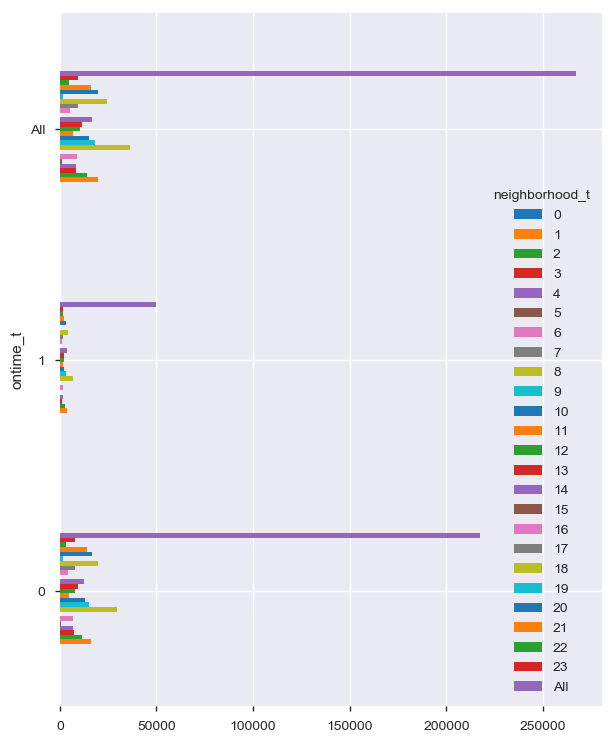

In [149]:
## Plotting the cross tab distribution for neighborhood_t variable and ontime_t
neigh_t.plot.barh(figsize=(7,9))
plt.show()

In [150]:
#############################################  ward variable ###################################

In [151]:
## unique values for ward variables
df1.ward.unique()

array(['Ward 16', nan, 'Ward 22', 'Ward 3', 'Ward 4', 'Ward 20', 'Ward 5',
       '21', 'Ward 18', '12', '1', 'Ward 1', '14', 'Ward 14', 'Ward 15',
       '20', 'Ward 21', '19', '10', 'Ward 17', 'Ward 10', '4', '18',
       'Ward 8', '2', 'Ward 6', 'Ward 9', '6', 'Ward 11', '22', 'Ward 19',
       'Ward 7', '5', '15', '9', '3', 'Ward 13', 'Ward 2', '11', '7',
       '13', 'Ward 12', '8', '16', '17', '0'], dtype=object)

In [152]:
## Creating another variable for ward variable and replacing nan with unknown
df1['ward'] = df1['ward'].replace(np.nan, 'UNKNOWN')

In [153]:
## unique values for ward variables
df1.ward.unique()

array(['Ward 16', 'UNKNOWN', 'Ward 22', 'Ward 3', 'Ward 4', 'Ward 20',
       'Ward 5', '21', 'Ward 18', '12', '1', 'Ward 1', '14', 'Ward 14',
       'Ward 15', '20', 'Ward 21', '19', '10', 'Ward 17', 'Ward 10', '4',
       '18', 'Ward 8', '2', 'Ward 6', 'Ward 9', '6', 'Ward 11', '22',
       'Ward 19', 'Ward 7', '5', '15', '9', '3', 'Ward 13', 'Ward 2',
       '11', '7', '13', 'Ward 12', '8', '16', '17', '0'], dtype=object)

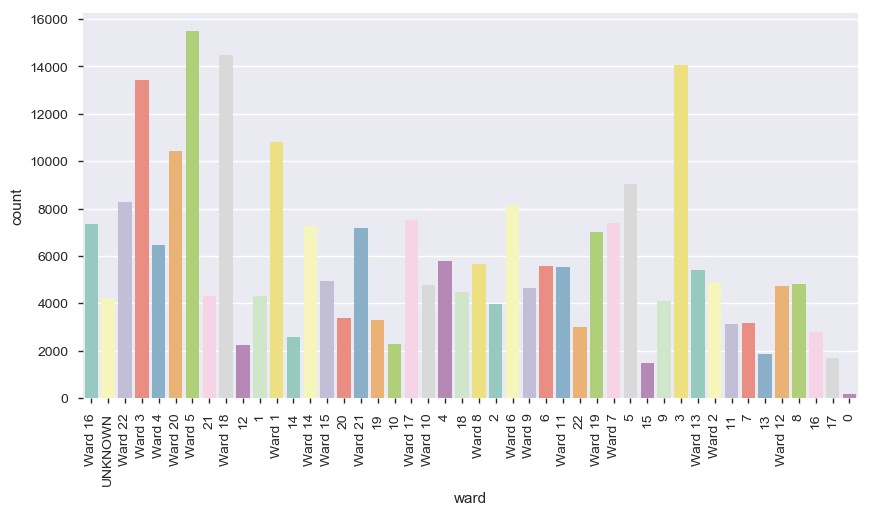

In [154]:
## SNS Countplot for the department variable
count, ax = plt.subplots(figsize=(10,5))
g=sns.countplot(x="ward", data=df1, palette="Set3")
for item in g.get_xticklabels():
    item.set_rotation(90)

In [155]:
 # Creating another column for the new variable ward to do one hot encoding
df1["ward_t"]=df1["ward"]
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type   ...    fire_district_t  \
592709                               Animal Lost   ...                  8   
593771  General Comments For a Program or Policy   ...                 33   

        fire_district_t2  subject_t subject_t2 pwd_district_t department_t  \
592709                 2          1          7              7            1   
593771                 2          6          6             33           10   

       department_t2 police_district_t neighborhood_t   ward_t  
592709            12                11              8  Ward 16  
593771            10                33             22  UNKNOWN  

[2 rows x 34 columns]

In [156]:
## One hot encoding for the different types found in this dataset 
le = LabelEncoder() 
  
df1['ward_t']= le.fit_transform(df1['ward_t']) 
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type  ...   fire_district_t  \
592709                               Animal Lost  ...                 8   
593771  General Comments For a Program or Policy  ...                33   

        fire_district_t2  subject_t subject_t2 pwd_district_t department_t  \
592709                 2          1          7              7            1   
593771                 2          6          6             33           10   

       department_t2 police_district_t neighborhood_t ward_t  
592709            12                11              8     31  
593771            10                33             22     23  

[2 rows x 34 columns]

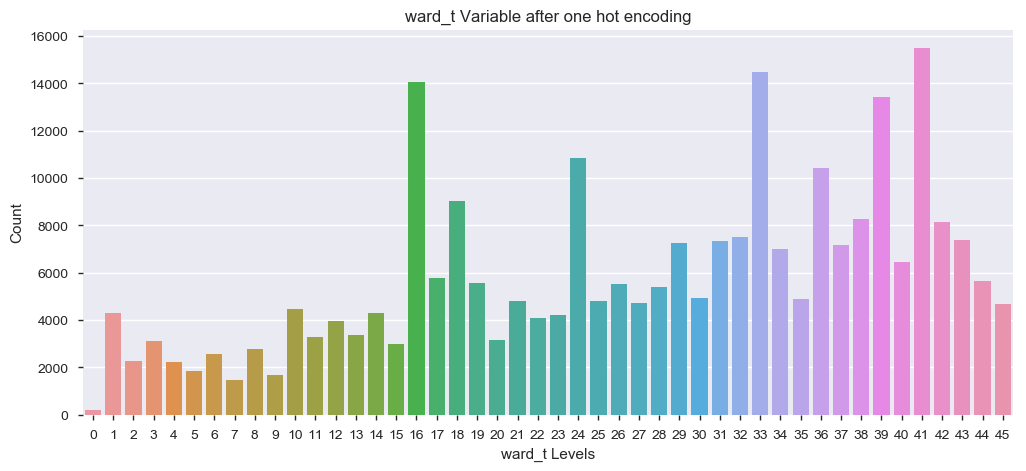

In [157]:
# Printing the Bar and Count Plot for ward_t with one hot encoding
count, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot('ward_t', data=df1)
ax.set_title('ward_t Variable after one hot encoding')
ax.set_xlabel('ward_t Levels')
ax.set_ylabel('Count')

plt.show()

In [158]:
# Cross Tabulation for Categorical ward_t variable and ontime_t

ward_t=pd.crosstab(df1.ontime_t, df1.ward_t, margins=True)
ward_t

ward_t      0     1     2     3     4     5     6     7     8     9   ...    \
ontime_t                                                              ...     
0          83  3536  1709  2243  1728  1459  2033  1247  2195  1376   ...     
1         101   782   581   868   492   381   542   226   569   322   ...     
All       184  4318  2290  3111  2220  1840  2575  1473  2764  1698   ...     

ward_t      37    38     39    40     41    42    43    44    45     All  
ontime_t                                                                  
0         6038  6854  11574  5388  13336  7108  6336  4925  3959  217605  
1         1146  1414   1839  1068   2155  1034  1062   717   698   49707  
All       7184  8268  13413  6456  15491  8142  7398  5642  4657  267312  

[3 rows x 47 columns]

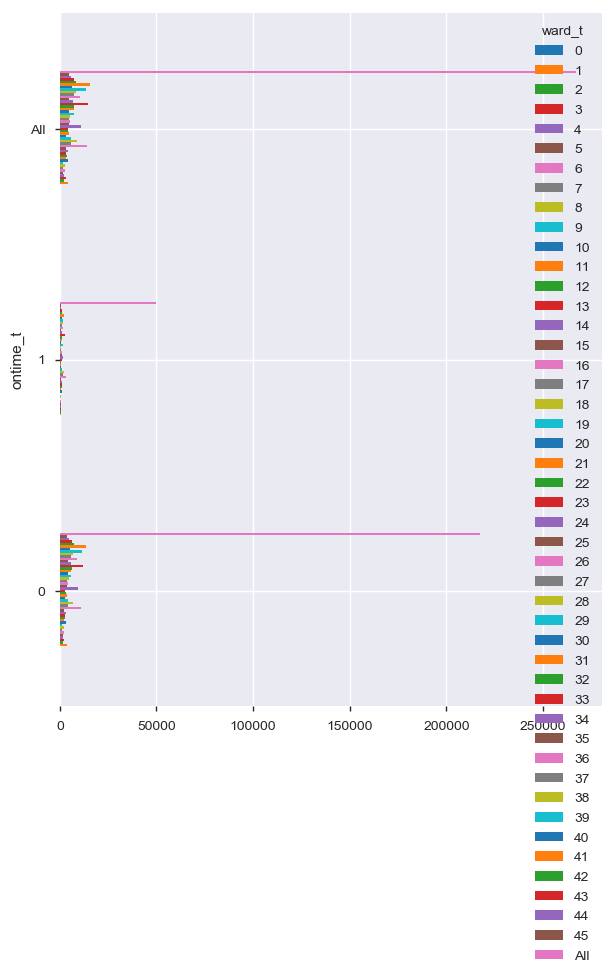

In [159]:
## Plotting the cross tab distribution for ward_t and ontime_t
ward_t.plot.barh(figsize=(7,9))
plt.show()

In [160]:
#################################################  Reason #############################

In [161]:
## unique values for reason variable
df1.reason.unique()

array(['Animal Issues', 'Employee & General Comments', 'Building',
       'Highway Maintenance', 'Administrative & General Requests',
       'Housing', 'Street Lights', 'Environmental Services',
       'Sidewalk Cover / Manhole', 'Fire Department', 'Alert Boston',
       'Code Enforcement', 'Street Cleaning', 'Notification', 'Graffiti',
       'Enforcement & Abandoned Vehicles', 'Sanitation',
       'Signs & Signals', 'Health', 'Park Maintenance & Safety',
       'Abandoned Bicycle', 'Needle Program', 'Catchbasin', 'Recycling',
       'Trees', 'Traffic Management & Engineering', 'Fire Hydrant',
       'Operations', 'Noise Disturbance', 'Parking Complaints',
       'Massport', 'Boston Bikes', 'Generic Noise Disturbance',
       'Weights and Measures', 'Air Pollution Control',
       'Neighborhood Services Issues', 'Cemetery',
       'Office of The Parking Clerk', 'Valet', 'Pothole', 'Programs',
       'Current Events', 'Consumer Affairs Issues', 'Billing',
       'Bridge Maintenance', '

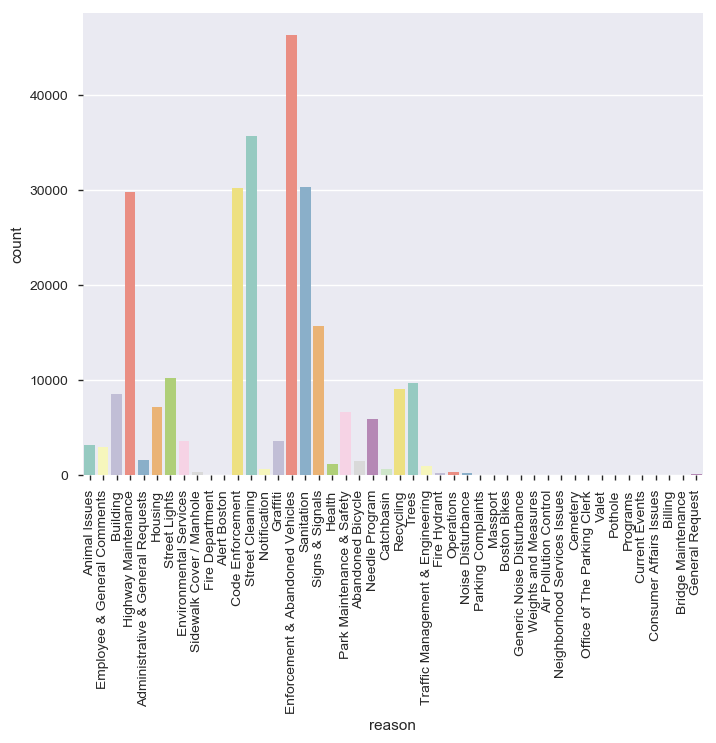

In [162]:
## SNS Countplot for the reason variable
count, ax = plt.subplots(figsize=(8,6))
g=sns.countplot(x="reason", data=df1, palette="Set3")
for item in g.get_xticklabels():
    item.set_rotation(90)

In [163]:
 # Creating another column for the new variable reason for one hot encoding
df1["reason_t"]=df1["reason"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type      ...       fire_district_t2  \
592709             C11  Animal Lost      ...                      2   

        subject_t  subject_t2 pwd_district_t department_t department_t2  \
592709          1           7              7            1            12   

       police_district_t neighborhood_t ward_t       reason_t  
592709                11              8     31  Animal Issues  

[1 rows x 35 columns]

In [164]:
## One hot encoding for the different ward levels found in this dataset 
le = LabelEncoder() 
  
df1['reason_t']= le.fit_transform(df1['reason_t']) 
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type   ...    fire_district_t2  \
592709                               Animal Lost   ...                   2   
593771  General Comments For a Program or Policy   ...                   2   

        subject_t  subject_t2 pwd_district_t department_t department_t2  \
592709          1           7              7            1            12   
593771          6           6             33           10            10   

       police_district_t neighborhood_t ward_t reason_t  
592709                11              8     31        4  
593771                33             22     23       14  

[2 rows x 35 columns]

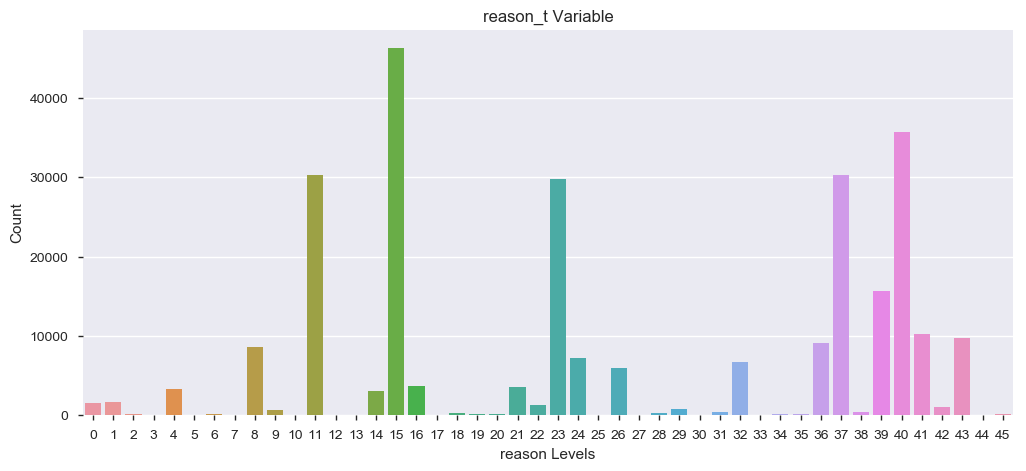

In [165]:
# Printing the Bar and Count Plot for reason_t
count, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot('reason_t', data=df1)
ax.set_title('reason_t Variable')
ax.set_xlabel('reason Levels')
ax.set_ylabel('Count')

plt.show()

In [166]:
# Cross Tabulation for Categorical reason_t Variable Type and ontime_t
reason_t=pd.crosstab(df1.ontime_t, df1.reason_t, margins=True)
reason_t

reason_t     0     1   2   3     4  5   6  7     8    9   ...       37   38  \
ontime_t                                                  ...                 
0         1514  1631  54  35  3242  8  61  4  3983  627   ...    29145  393   
1            9    15   0   0     0  0   3  0  4534    0   ...     1167    0   
All       1523  1646  54  35  3242  8  64  4  8517  627   ...    30312  393   

reason_t     39     40     41   42    43  44  45     All  
ontime_t                                                  
0          9824  32137   6547  527  8967   5  37  217605  
1          5874   3546   3657  423   743   4  40   49707  
All       15698  35683  10204  950  9710   9  77  267312  

[3 rows x 47 columns]

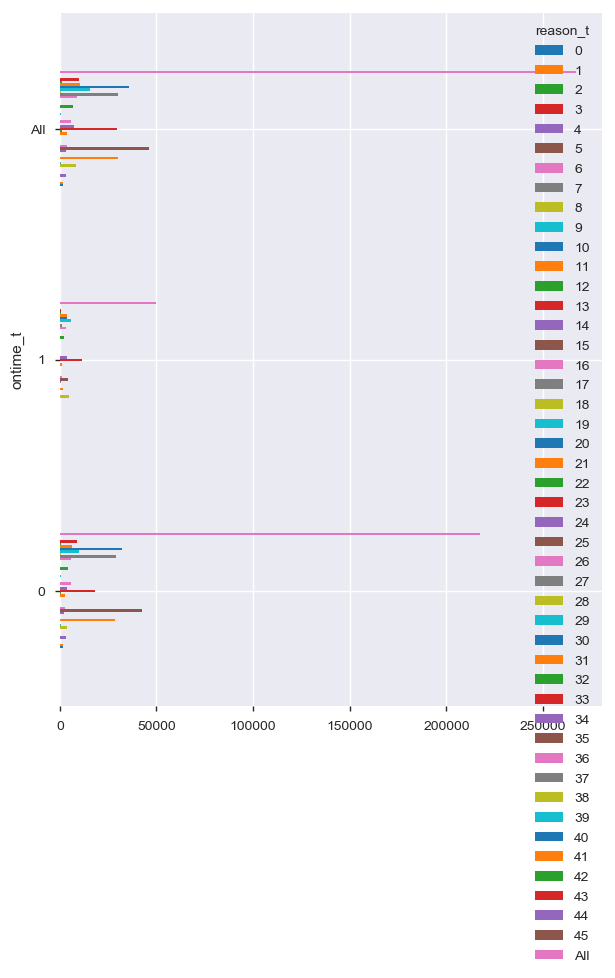

In [167]:
## Plotting the cross tab distribution for reason_t and ontime_t
reason_t.plot.barh(figsize=(7,9))
plt.show()

In [168]:
################################################ type variable ##################################

In [169]:
## unique values for the type variables
df1.type.unique()

array(['Animal Lost', 'General Comments For a Program or Policy',
       'Animal Found', 'Exceeding Terms of Permit', 'Sidewalk Repair',
       'BWSC General Request', 'Unsatisfactory Living Conditions',
       'Heat - Excessive  Insufficient', 'Animal Generic Request',
       'Street Light Knock Downs', 'Mice Infestation - Residential',
       'Animal Noise Disturbances', 'Misc. Snow Complaint',
       'Maintenance Complaint - Residential', 'Rodent Activity',
       'Sidewalk Cover / Manhole', 'Fire Department Request',
       'Sidewalk Repair (Make Safe)', 'Work w/out Permit', 'Alert Boston',
       'Unshoveled Sidewalk', 'General Comments For An Employee',
       'PWD Graffiti', 'Requests for Street Cleaning', 'Bed Bugs',
       'Notification', 'Improper Storage of Trash (Barrels)',
       'Street Light Outages', 'Pick up Dead Animal', 'Graffiti Removal',
       'Parking Enforcement', 'Utility Casting Repair',
       'Empty Litter Basket', 'Transportation General Request',
       'C

In [170]:
 # Creating another column for the new variable type_t
df1["type_t"]=df1["type"]
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type  \
592709                               Animal Lost   
593771  General Comments For a Program or Policy   

                          ...                    subject_t  subject_t2  \
592709                    ...                            1           7   
593771                    ...                            6           6   

        pwd_district_t department_t department_t2 police_district_t  \
592709               7            1            12                11   
593771              33           10            10                33   

       neighborhood_t ward_t reason_t  \
592709              8     31        4   
593771             22     23       14   

                                          type_t  
592709                               Animal Lost  
593771  General Comments For a Program or Policy  

[2 rows x 36 columns]

In [171]:
## One hot encoding for the different attribute types found in this dataset 
le = LabelEncoder() 
  
df1['type_t']= le.fit_transform(df1['type_t']) 
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type  ...   subject_t  subject_t2  \
592709                               Animal Lost  ...           1           7   
593771  General Comments For a Program or Policy  ...           6           6   

        pwd_district_t department_t department_t2 police_district_t  \
592709               7            1            12                11   
593771              33           10            10                33   

       neighborhood_t ward_t reason_t type_t  
592709              8     31        4      7  
593771             22     23       14     43  

[2 rows x 36 columns]

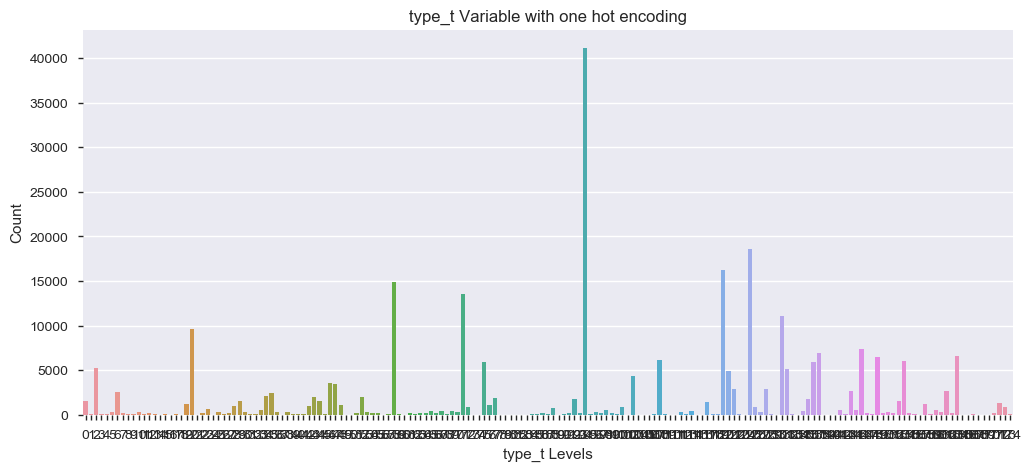

In [172]:
# Printing the Bar and Count Plot for type_t Variable
count, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot('type_t', data=df1)
ax.set_title('type_t Variable with one hot encoding')
ax.set_xlabel('type_t Levels')
ax.set_ylabel('Count')

plt.show()

In [173]:
# Cross Tabulation for Categorical type_t and ontime_t
type_t=pd.crosstab(df1.ontime_t, df1.type_t, margins=True)
type_t

type_t       0    1     2   3   4    5     6    7    8   9   ...    166  167  \
ontime_t                                                     ...               
0         1514   50  2854  28  35  303  2603  226  110  40   ...      7  129   
1            9   86  2331   0   0    0     0    0    0   0   ...      1    1   
All       1523  136  5185  28  35  303  2603  226  110  40   ...      8  130   

type_t    168  169  170  171   172  173  174     All  
ontime_t                                              
0           5    2    1  152   302  846   18  217605  
1           4    0    0   94   964   14   28   49707  
All         9    2    1  246  1266  860   46  267312  

[3 rows x 176 columns]

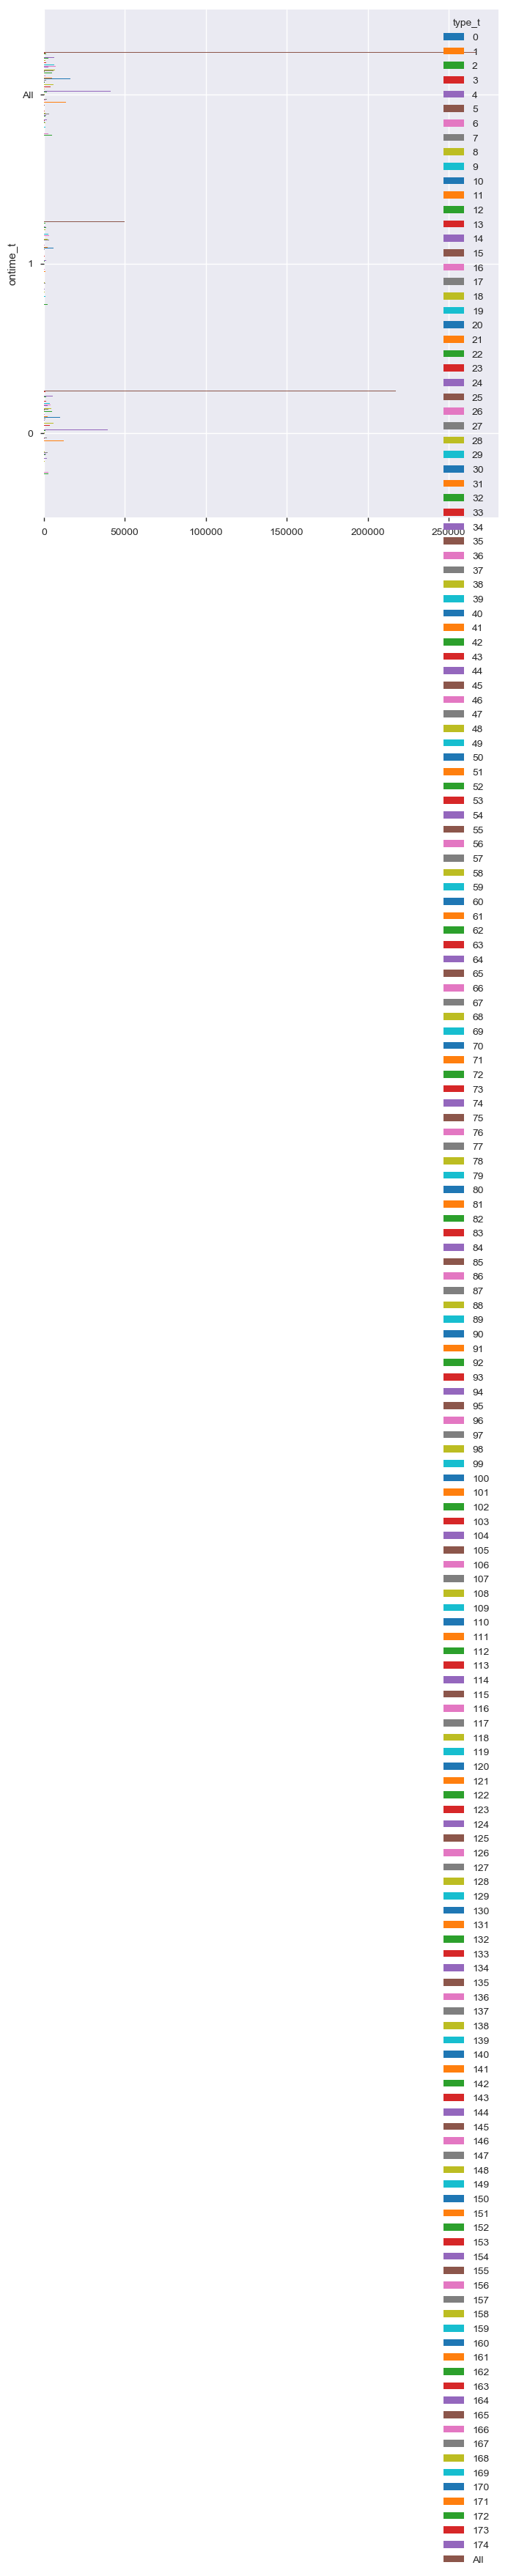

In [174]:
## Plotting the cross tab distribution for type_t variable and ontime_t
type_t.plot.barh(figsize=(8,9))
plt.show()

In [175]:
############################################ precinct variable ######################################################

In [176]:
## unique values for precinct variables
df1.precinct.unique()

array(['1606', nan, '2203', '307', '401', '2001', '508', '2108', '1806',
       '1608', '1207', '108', '106', '504', '1410', '1407', '306', '1509',
       '2006', '2110', '111', '1814', '1815', '1913', '1401', '1007',
       '1820', '2107', '1703', '2106', '1802', '1004', '1710', '408',
       '1609', '107', '1808', '807', '206', '301', '1604', '1504', '605',
       '304', '507', '501', '905', '2002', '904', '2202', '103', '1108',
       '505', '1906', '2111', '709', '1803', '509', '1908', '1714',
       '2205', '403', '502', '506', '2013', '110', '1902', '303', '902',
       '1907', '1009', '305', '1203', '1309', '2204', '802', '1809',
       '203', '1106', '1201', '2115', '1612', '302', '402', '503', '703',
       '601', '1903', '1104', '2208', '407', '1310', '901', '405', '705',
       '708', '702', '0502A', '609', '1103', '2114', '1101', '706',
       '1813', '308', '2016', '1105', '2207', '201', '2003', '1701',
       '406', '2018', '1110', '2012', '1308', '2113', '803', '2211',
 

In [177]:
## Replacing nan with 33 for precinct
df1['precinct'] = df1['precinct'].replace(np.nan, 33)
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type  ...   subject_t  subject_t2  \
592709                               Animal Lost  ...           1           7   
593771  General Comments For a Program or Policy  ...           6           6   

        pwd_district_t department_t department_t2 police_district_t  \
592709               7            1            12                11   
593771              33           10            10                33   

       neighborhood_t ward_t reason_t type_t  
592709              8     31        4      7  
593771             22     23       14     43  

[2 rows x 36 columns]

In [178]:
## Replacing the precinct with a letter with  a unique number
df1.precinct[df1.precinct == "0502A"] = "0502001"

In [179]:
## creating another column for the transformed precinct variable
df1["precinct_t"]=df1["precinct"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type    ...     subject_t2  pwd_district_t  \
592709             C11  Animal Lost    ...              7               7   

        department_t department_t2 police_district_t neighborhood_t ward_t  \
592709             1            12                11              8     31   

       reason_t type_t precinct_t  
592709        4      7       1606  

[1 rows x 37 columns]

In [180]:
# Converting the objects to a number for precinct for analysis
cols = ['precinct_t']  # We don't want to convert the Final grade column.
for col in cols:  # Iterate over chosen columns
    df1[col] = pd.to_numeric(df1[col])

In [181]:
## One hot encoding for the precinct levels found in this dataset 
le = LabelEncoder() 
  
df1['precinct_t']= le.fit_transform(df1['precinct_t']) 
df1.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type    ...     subject_t2  \
592709                               Animal Lost    ...              7   
593771  General Comments For a Program or Policy    ...              6   

        pwd_district_t  department_t department_t2 police_district_t  \
592709               7             1            12                11   
593771              33            10            10                33   

       neighborhood_t ward_t reason_t type_t precinct_t  
592709              8     31        4      7        148  
593771             22     23       14     43          0  

[2 rows x 37 columns]

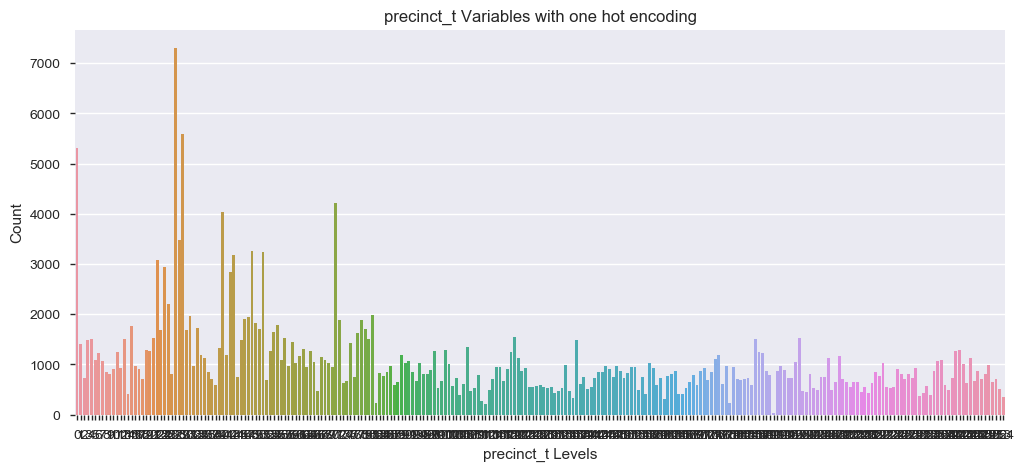

In [182]:
# Printing the Bar and Count Plot for type_t Variable
count, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot('precinct_t', data=df1)
ax.set_title('precinct_t Variables with one hot encoding')
ax.set_xlabel('precinct_t Levels')
ax.set_ylabel('Count')

plt.show()

In [183]:
############################  photosubmissions #######################################

In [184]:
# Looking at the submitted photo attribute
df1.submittedphoto.tail(3)

906665                                                  NaN
906666    https://311.boston.gov/media/boston/report/pho...
906667    https://311.boston.gov/media/boston/report/pho...
Name: submittedphoto, dtype: object

In [185]:
# Creating another column for the new binned category for submitted photo
df1["submittedphoto_t"]=df1["submittedphoto"]
df1.head(1)

ontime            source city_council_district fire_district  \
592709  ONTIME  Constituent Call                     3             8   

               subject pwd_district department neighborhood_services_district  \
592709  Animal Control            7       ANML                              7   

       police_district         type       ...        pwd_district_t  \
592709             C11  Animal Lost       ...                     7   

        department_t  department_t2 police_district_t neighborhood_t ward_t  \
592709             1             12                11              8     31   

       reason_t type_t precinct_t submittedphoto_t  
592709        4      7        148              NaN  

[1 rows x 38 columns]

In [186]:
## Replacing the NAN with a 0
df1['submittedphoto_t'] = df1['submittedphoto_t'].replace(np.NaN, 0)

In [187]:
## Looking at the tail distribution for the dataset 
df1.submittedphoto_t.tail(5)

906663    https://311.boston.gov/media/boston/report/pho...
906664    https://311.boston.gov/media/boston/report/pho...
906665                                                    0
906666    https://311.boston.gov/media/boston/report/pho...
906667    https://311.boston.gov/media/boston/report/pho...
Name: submittedphoto_t, dtype: object

In [188]:
## Describe statement for the submitted photos. 
df1.submittedphoto_t.describe()

count     267312
unique    106685
top            0
freq      160620
Name: submittedphoto_t, dtype: int64

In [189]:
## Replacing all http values with a 1 value 
df1.submittedphoto_t[df1.submittedphoto_t != 0] = 1

In [190]:
## Making sure the submittedphoto_t variable is unique
df1.submittedphoto_t.unique()

array([0, 1], dtype=object)

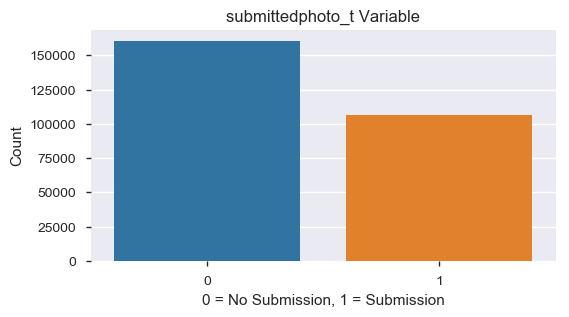

In [191]:
# Printing the Bar and Count Plot for submitted photos
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('submittedphoto_t', data=df1)
ax.set_title('submittedphoto_t Variable')
ax.set_xlabel('0 = No Submission, 1 = Submission')
ax.set_ylabel('Count')

plt.show()

In [192]:
################################################################################################################

In [193]:
## creating a time dataframe
df_time=df1
df_time.head(2)

ontime            source city_council_district fire_district  \
592709   ONTIME  Constituent Call                     3             8   
593771  OVERDUE  Constituent Call                    33            33   

                        subject pwd_district department  \
592709           Animal Control            7       ANML   
593771  Mayor's 24 Hour Hotline           33       INFO   

       neighborhood_services_district police_district  \
592709                              7             C11   
593771                             33              33   

                                            type       ...         \
592709                               Animal Lost       ...          
593771  General Comments For a Program or Policy       ...          

       pwd_district_t  department_t  department_t2 police_district_t  \
592709              7             1             12                11   
593771             33            10             10                33   

       neighborhood_t ward_t reason_t type_t precinct_t submittedphoto_t  
592709              8     31        4      7        148                0  
593771             22     23       14     43          0                0  

[2 rows x 38 columns]

In [194]:
## column check for the new df_time
df_time.columns

Index(['ontime', 'source', 'city_council_district', 'fire_district', 'subject',
       'pwd_district', 'department', 'neighborhood_services_district',
       'police_district', 'type', 'precinct', 'latitude', 'longitude', 'ward',
       'neighborhood', 'reason', 'submittedphoto', 'closed_dt', 'open_dt',
       'target_dt', 'ontime_t', 'source_t', 'source_t2',
       'city_council_district_t', 'fire_district_t', 'fire_district_t2',
       'subject_t', 'subject_t2', 'pwd_district_t', 'department_t',
       'department_t2', 'police_district_t', 'neighborhood_t', 'ward_t',
       'reason_t', 'type_t', 'precinct_t', 'submittedphoto_t'],
      dtype='object')

In [195]:
## Checking to see if all missing values were dropped when removing nan for closed_dt
df_time.dropna(subset=['closed_dt'], inplace=True)
df_time.count()

ontime                            235329
source                            235329
city_council_district             235329
fire_district                     235329
subject                           235329
pwd_district                      235329
department                        235329
neighborhood_services_district    235329
police_district                   235329
type                              235329
precinct                          235329
latitude                          235329
longitude                         235329
ward                              235329
neighborhood                      235329
reason                            235329
submittedphoto                     98015
closed_dt                         235329
open_dt                           235329
target_dt                         207386
ontime_t                          235329
source_t                          235329
source_t2                         235329
city_council_district_t           235329
fire_district_t 

In [196]:
## Checking to see if all missing values were dropped for removing nan for target_dt
df_time.dropna(subset=['target_dt'], inplace=True)
df_time.count()

ontime                            207386
source                            207386
city_council_district             207386
fire_district                     207386
subject                           207386
pwd_district                      207386
department                        207386
neighborhood_services_district    207386
police_district                   207386
type                              207386
precinct                          207386
latitude                          207386
longitude                         207386
ward                              207386
neighborhood                      207386
reason                            207386
submittedphoto                     93441
closed_dt                         207386
open_dt                           207386
target_dt                         207386
ontime_t                          207386
source_t                          207386
source_t2                         207386
city_council_district_t           207386
fire_district_t 

In [197]:
# Cross Tabulation for Categorical Department Variable Department Type and target variable "ontime"
depart_time=pd.crosstab(df_time.ontime_t, df_time.department, margins=True)
depart_time

department  ANML  BHA_  BPD_  BPS_   BTDT  BWSC  DISB  DND_  GEN_  INFO  \
ontime_t                                                                  
0              1     0     0     2  52789    12     6     2    29   847   
1              1     1     2     1   6957    26     4     0     6   511   
All            2     1     2     3  59746    38    10     2    35  1358   

department    ISD  ONS_   PARK  PROP    PWDx     All  
ontime_t                                              
0            9334     1  11215  2421  102559  179218  
1            4022     0   1765  1030   13842   28168  
All         13356     1  12980  3451  116401  207386

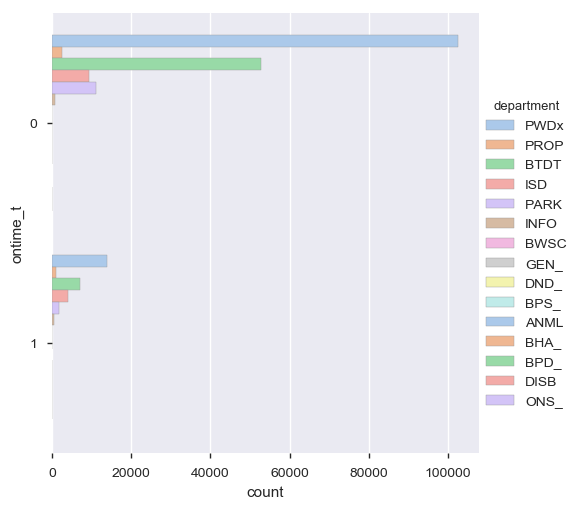

In [198]:
## Barplot and Countplot in Seaborn for department
sns.catplot(y="ontime_t", 
            hue="department", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df_time);

In [199]:
# Cross Tabulation for Categorical subject Variable and target variable "ontime_t"
subject_time=pd.crosstab(df_time.ontime_t, df_time.subject, margins=True)
subject_time

subject   Inspectional Services  Mayor's 24 Hour Hotline  \
ontime_t                                                   
0                          9236                     1225   
1                          3584                       84   
All                       12820                     1309   

subject   Parks & Recreation Department  Property Management  \
ontime_t                                                       
0                                 11285                 2410   
1                                  1499                  941   
All                               12784                 3351   

subject   Public Works Department  Transportation - Traffic Division     All  
ontime_t                                                                      
0                          102426                              52636  179218  
1                           14986                               7074   28168  
All                        117412                              59710  207386

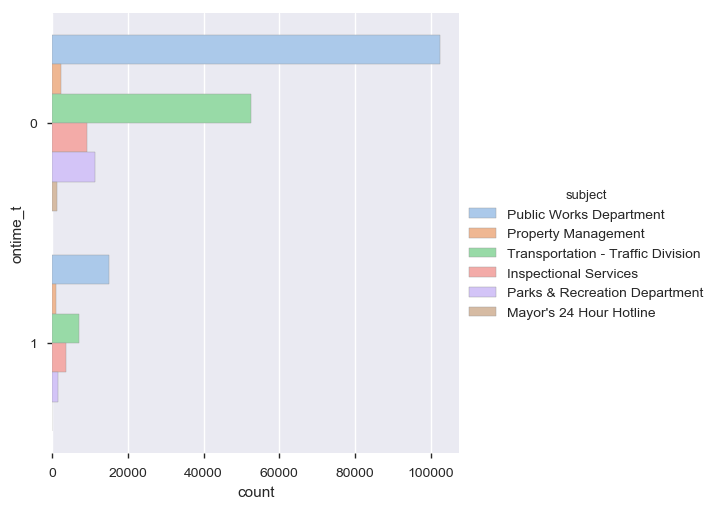

In [200]:
## Barplot and Countplot in Seaborn for subject and ontime_t
sns.catplot(y="ontime_t", 
            hue="subject", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df_time);

In [201]:
## Creating a time differential for closed time minus target time
df_time['close_target_diff'] = (df_time['closed_dt'] - df_time['target_dt']).dt.days
df_time['close_open_diff'] = (df_time['closed_dt'] - df_time['open_dt']).dt.days
df_time.head(5)

ontime                source city_council_district fire_district  \
606536   ONTIME  Citizens Connect App                     1             3   
606537   ONTIME    Employee Generated                     7             9   
606538   ONTIME      Constituent Call                     6             9   
606540   ONTIME      Constituent Call                     3             8   
606541  OVERDUE  Citizens Connect App                     1             1   

                        subject pwd_district department  \
606536  Public Works Department           1B       PWDx   
606537  Public Works Department          10A       PWDx   
606538  Public Works Department            6       PWDx   
606540  Public Works Department            7       PWDx   
606541      Property Management            9       PROP   

       neighborhood_services_district police_district  \
606536                              3              A1   
606537                             13              D4   
606538                             10              E5   
606540                              7             C11   
606541                              1              A7   

                                       type       ...       department_t2  \
606536  Improper Storage of Trash (Barrels)       ...                  15   
606537                 Street Light Outages       ...                  15   
606538                  Pick up Dead Animal       ...                  15   
606540                 Street Light Outages       ...                  15   
606541                     Graffiti Removal       ...                  14   

        police_district_t  neighborhood_t ward_t reason_t type_t precinct_t  \
606536                  1               3     39       11     58         27   
606537                  4               4     17       41    146         37   
606538                  5              17     13       40    103        205   
606540                 11               8     31       41    146        151   
606541                  7              10      1       21     46          7   

       submittedphoto_t close_target_diff close_open_diff  
606536                1                -3               0  
606537                0               -17               0  
606538                0                -3               0  
606540                0               -14               2  
606541                1                67             134  

[5 rows x 40 columns]

In [202]:
## Separating the df_time into ontime or overdue categories for analysis 
on_time = df_time[df_time['ontime_t']== 0]
on_time.count()

ontime                            179218
source                            179218
city_council_district             179218
fire_district                     179218
subject                           179218
pwd_district                      179218
department                        179218
neighborhood_services_district    179218
police_district                   179218
type                              179218
precinct                          179218
latitude                          179218
longitude                         179218
ward                              179218
neighborhood                      179218
reason                            179218
submittedphoto                     84495
closed_dt                         179218
open_dt                           179218
target_dt                         179218
ontime_t                          179218
source_t                          179218
source_t2                         179218
city_council_district_t           179218
fire_district_t 

In [203]:
## Separating the df_time into ontime_t or overdue categories for analysis 
over_time = df_time[df_time['ontime_t']== 1]
over_time.count()

ontime                            28168
source                            28168
city_council_district             28168
fire_district                     28168
subject                           28168
pwd_district                      28168
department                        28168
neighborhood_services_district    28168
police_district                   28168
type                              28168
precinct                          28168
latitude                          28168
longitude                         28168
ward                              28168
neighborhood                      28168
reason                            28168
submittedphoto                     8946
closed_dt                         28168
open_dt                           28168
target_dt                         28168
ontime_t                          28168
source_t                          28168
source_t2                         28168
city_council_district_t           28168
fire_district_t                   28168


In [204]:
## Describe statement for on_time
on_time.describe()

latitude      longitude  ontime_t       source_t      source_t2  \
count  179218.000000  179218.000000  179218.0  179218.000000  179218.000000   
mean       42.336440     -71.076875       0.0       1.971789       1.971593   
std         0.031602       0.032988       0.0       1.147681       1.146900   
min        42.231500     -71.185400       0.0       1.000000       1.000000   
25%        42.316600     -71.090600       0.0       1.000000       1.000000   
50%        42.347200     -71.064900       0.0       2.000000       2.000000   
75%        42.359400     -71.058700       0.0       3.000000       3.000000   
max        42.394800     -70.994900       0.0       7.000000       6.000000   

       neighborhood_t         ward_t       reason_t         type_t  \
count   179218.000000  179218.000000  179218.000000  179218.000000   
mean        11.484656      27.540850      25.757201      95.881195   
std          6.682233      11.984909      12.289709      40.228481   
min          0.000000       0.000000       1.000000       1.000000   
25%          8.000000      18.000000      15.000000      71.000000   
50%         10.000000      30.000000      23.000000      94.000000   
75%         18.000000      38.000000      40.000000     125.000000   
max         23.000000      45.000000      45.000000     174.000000   

          precinct_t  close_target_diff  close_open_diff  
count  179218.000000      179218.000000    179218.000000  
mean       99.353681         -22.804043         4.082737  
std        75.027203          87.836494        24.144635  
min         0.000000        -720.000000         0.000000  
25%        34.000000          -4.000000         0.000000  
50%        77.000000          -2.000000         0.000000  
75%       162.000000          -1.000000         0.000000  
max       254.000000           0.000000       593.000000

In [205]:
## Describe statment for the over_time
over_time.describe()

latitude     longitude  ontime_t      source_t     source_t2  \
count  28168.000000  28168.000000   28168.0  28168.000000  28168.000000   
mean      42.333269    -71.079240       1.0      2.187340      2.186985   
std        0.033348      0.032856       0.0      1.216804      1.215545   
min       42.232300    -71.176300       1.0      1.000000      1.000000   
25%       42.309600    -71.096600       1.0      1.000000      1.000000   
50%       42.346100    -71.066200       1.0      2.000000      2.000000   
75%       42.359400    -71.058700       1.0      3.000000      3.000000   
max       42.395100    -70.996200       1.0      7.000000      6.000000   

       neighborhood_t        ward_t      reason_t        type_t    precinct_t  \
count    28168.000000  28168.000000  28168.000000  28168.000000  28168.000000   
mean        11.515301     26.150277     27.606326    103.536531    106.818162   
std          6.459971     11.776457     11.353559     48.640478     75.366312   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          8.000000     16.000000     16.000000     71.000000     40.000000   
50%         11.000000     28.000000     24.000000    121.000000     91.000000   
75%         18.000000     36.000000     39.000000    138.000000    174.000000   
max         23.000000     45.000000     45.000000    174.000000    254.000000   

       close_target_diff  close_open_diff  
count       28168.000000     28168.000000  
mean           35.357320        50.547536  
std            75.818496        90.693498  
min             0.000000         0.000000  
25%             1.000000         3.000000  
50%             6.000000        18.000000  
75%            31.000000        50.000000  
max           722.000000       738.000000

In [206]:
## Grouping the on_time by day_of_week and close_open_diff
time100A=on_time.groupby(['subject'])['close_open_diff'].mean()
time100A

subject
Inspectional Services                 9.715461
Mayor's 24 Hour Hotline               1.201633
Parks & Recreation Department        39.943022
Property Management                  11.568880
Public Works Department               0.990627
Transportation - Traffic Division     1.147352
Name: close_open_diff, dtype: float64

In [207]:
## dataframe check
type(time100A)

pandas.core.series.Series

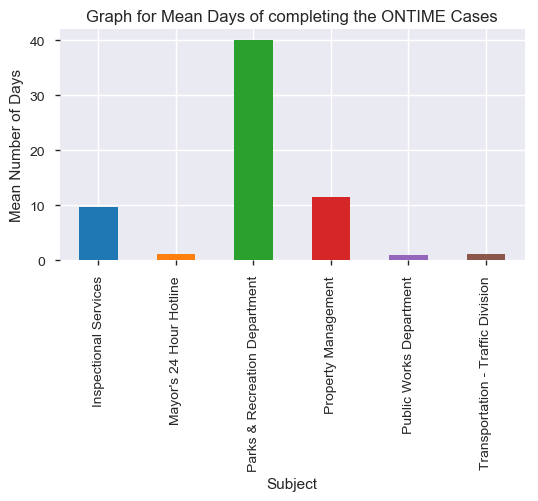

In [208]:
## Plotting the mean days for the analysis 
count, ax = plt.subplots(figsize=(6,3))
ax = time100A.plot.bar(x='subject', y='val', rot=90)
ax.set_title('Graph for Mean Days of completing the ONTIME Cases')
ax.set_xlabel('Subject')
ax.set_ylabel('Mean Number of Days')
plt.show()

In [209]:
## Grouping the over_time cases by subject and close_open_diff
time100B=over_time.groupby(['subject'])['close_open_diff'].mean()
time100B

subject
Inspectional Services                 69.267578
Mayor's 24 Hour Hotline               76.071429
Parks & Recreation Department         87.511674
Property Management                  169.802338
Public Works Department               36.484052
Transportation - Traffic Division     46.856658
Name: close_open_diff, dtype: float64

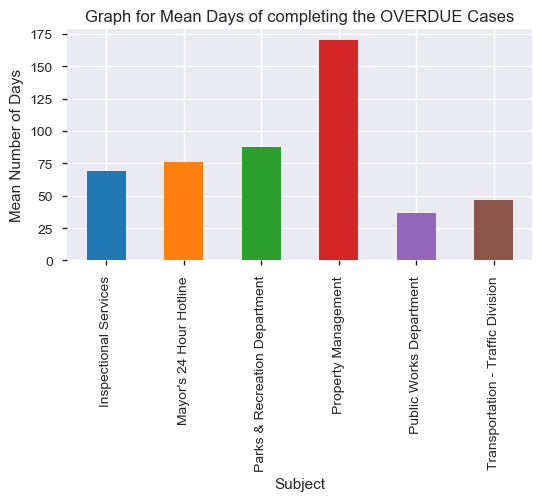

In [210]:
## Creating the countplot for submect by overdue cases
count, ax = plt.subplots(figsize=(6,3))
ax = time100B.plot.bar(x='subject', y='val', rot=90)
ax.set_title('Graph for Mean Days of completing the OVERDUE Cases')
ax.set_xlabel('Subject')
ax.set_ylabel('Mean Number of Days')
plt.show()

In [211]:
## Grouping the over_time cases by department and close_open_diff
time101A=on_time.groupby(['department'])['close_open_diff'].mean()
time101A

department
ANML     0.000000
BPS_     0.500000
BTDT     1.154237
BWSC     0.416667
DISB     2.000000
DND_     1.500000
GEN_     0.172414
INFO     0.889020
ISD      9.650846
ONS_     1.000000
PARK    40.031654
PROP    11.532838
PWDx     1.004612
Name: close_open_diff, dtype: float64

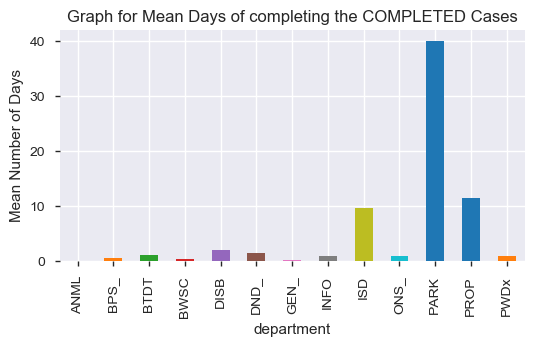

In [212]:
## Graphing the group by function for department and completed cases
count, ax = plt.subplots(figsize=(6,3))
ax = time101A.plot.bar(x='department', y='val', rot=90)
ax.set_title('Graph for Mean Days of completing the COMPLETED Cases')
ax.set_xlabel('department')
ax.set_ylabel('Mean Number of Days')
plt.show()

In [213]:
## Grouping the over_time by department and close_open_diff for overtime cases
time101B=over_time.groupby(['department'])['close_open_diff'].mean()
time101B

department
ANML      5.000000
BHA_      2.000000
BPD_     32.500000
BPS_     59.000000
BTDT     47.576829
BWSC     16.076923
DISB    288.250000
GEN_      5.833333
INFO     38.452055
ISD      63.184983
PARK     76.079320
PROP    164.116505
PWDx     37.133001
Name: close_open_diff, dtype: float64

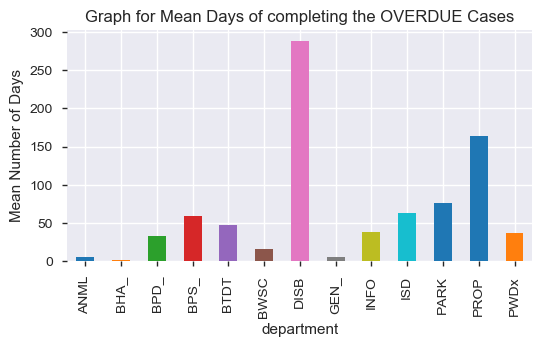

In [214]:
## Graphing the group by function for department
count, ax = plt.subplots(figsize=(6,3))
ax = time101B.plot.bar(x='department', y='val', rot=90)
ax.set_title('Graph for Mean Days of completing the OVERDUE Cases')
ax.set_xlabel('department')
ax.set_ylabel('Mean Number of Days')
plt.show()

In [215]:
## Grouping the over_time cases by neigborhood_t and close_open_diff
time102A=on_time.groupby(['neighborhood_t'])['close_open_diff'].count()
time102A

neighborhood_t
0       225
1     13950
2     10126
3      6841
4      5530
5       740
6      6051
7        13
8     23525
9     13476
10    11279
11     4181
12     5890
13     7248
14    10513
15      183
16     3476
17     5966
18    15361
19     1186
20    14191
21    11171
22     2470
23     5626
Name: close_open_diff, dtype: int64

In [216]:
## Grouping the over_time cases by neigborhood_t and close_open_diff by mean
time102AA=on_time.groupby(['neighborhood_t'])['close_open_diff'].mean()
time102AA

neighborhood_t
0     6.671111
1     3.348530
2     3.932945
3     3.306826
4     4.332550
5     4.327027
6     4.901834
7     0.461538
8     3.941254
9     2.896334
10    5.401011
11    3.065774
12    5.298132
13    3.923427
14    3.844478
15    6.956284
16    3.464327
17    5.313946
18    3.512727
19    3.546374
20    2.827637
21    5.409543
22    3.141700
23    8.383754
Name: close_open_diff, dtype: float64

In [217]:
## Describe statement for neighbohood_t and ontime. 
on_time.neighborhood_t.describe()

count    179218.000000
mean         11.484656
std           6.682233
min           0.000000
25%           8.000000
50%          10.000000
75%          18.000000
max          23.000000
Name: neighborhood_t, dtype: float64

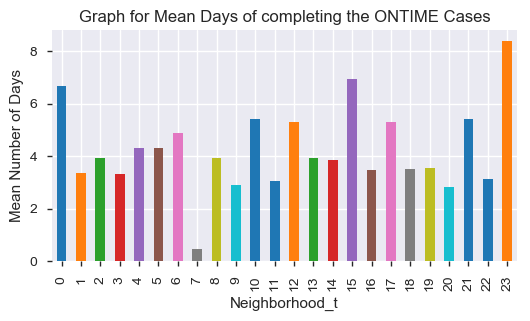

In [218]:
## Graphing the group by function for department
count, ax = plt.subplots(figsize=(6,3))
ax = time102AA.plot.bar(x='Neigborhood_t', y='val', rot=90)
ax.set_title('Graph for Mean Days of completing the ONTIME Cases')
ax.set_xlabel('Neighborhood_t')
ax.set_ylabel('Mean Number of Days')
plt.show()

In [219]:
## Grouping the over_time cases by neigborhood_t and close_open_diff
time102B=over_time.groupby(['neighborhood_t'])['close_open_diff'].count()
time102B

neighborhood_t
0       43
1     2171
2     1510
3      693
4      825
5      135
6     1042
7        1
8     3862
9     1905
10    1465
11     808
12    1309
13    1388
14    2000
15      53
16     608
17    1138
18    2787
19     154
20    1521
21    1318
22     467
23     965
Name: close_open_diff, dtype: int64

In [220]:
## Grouping the over_time cases by subject and close_open_diff
time102BB=over_time.groupby(['neighborhood_t'])['close_open_diff'].mean()
time102BB

neighborhood_t
0     89.837209
1     47.068632
2     46.333113
3     43.809524
4     51.306667
5     51.925926
6     44.205374
7     13.000000
8     48.956240
9     59.573753
10    53.410239
11    50.904703
12    52.227655
13    43.622478
14    54.929500
15    40.245283
16    61.641447
17    51.268893
18    45.637244
19    60.824675
20    55.922419
21    57.069803
22    52.781585
23    43.412435
Name: close_open_diff, dtype: float64

In [221]:
## Describe statment for neighborhood_t with overtime
over_time.neighborhood_t.describe()

count    28168.000000
mean        11.515301
std          6.459971
min          0.000000
25%          8.000000
50%         11.000000
75%         18.000000
max         23.000000
Name: neighborhood_t, dtype: float64

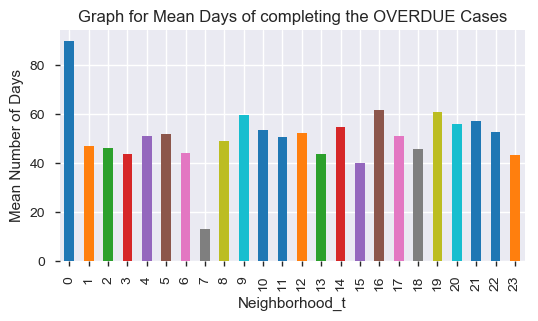

In [222]:
## Graphing the group by function for department
count, ax = plt.subplots(figsize=(6,3))
ax = time102BB.plot.bar(x='Neigborhood_t', y='val', rot=90)
ax.set_title('Graph for Mean Days of completing the OVERDUE Cases')
ax.set_xlabel('Neighborhood_t')
ax.set_ylabel('Mean Number of Days')
plt.show()

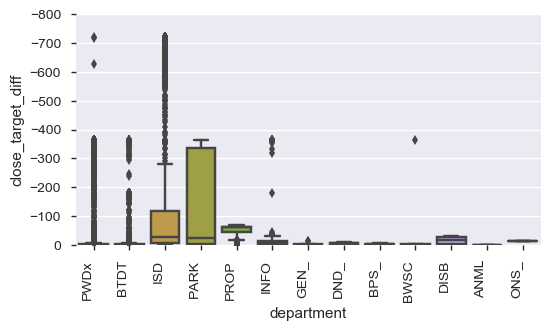

In [223]:
## Box and Whisker Plot for department and close_target_diff for ontime cases
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='department', y="close_target_diff", data =on_time)
fig.axis(ymin=0, ymax= -800)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show();

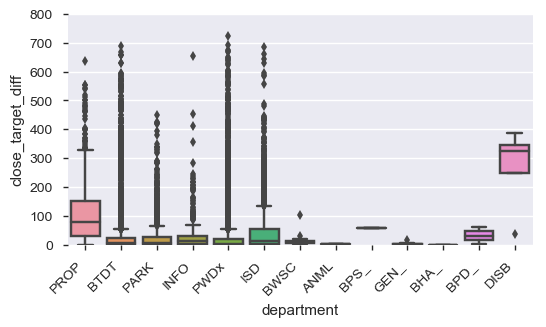

In [224]:
## Box and Whisker Plot for department and close_target_diff for overdue cases
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='department', y="close_target_diff", data=over_time)
fig.axis(ymin=0, ymax=800)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show();

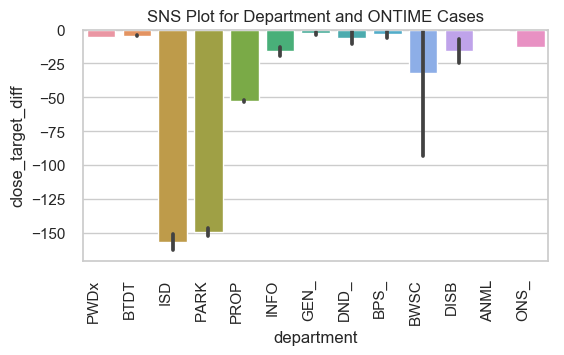

In [225]:
## Graphing the results for the department of on_time and close_target_diff
sns.set(style="whitegrid") 
count, ax = plt.subplots(figsize=(6,3))
ax = sns.barplot(x="department", y="close_target_diff", data=on_time)
ax.set_title('SNS Plot for Department and ONTIME Cases')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

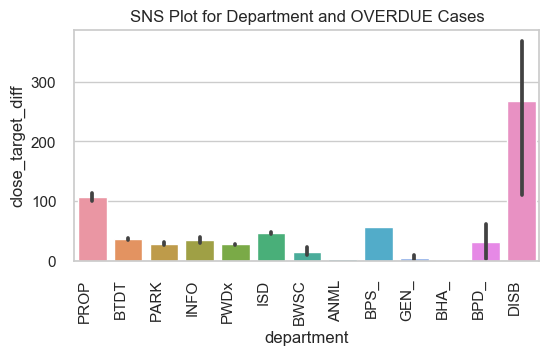

In [226]:
## Graphing the results for the department of over_time and close_target_diff
sns.set(style="whitegrid") 
count, ax = plt.subplots(figsize=(6,3))
ax = sns.barplot(x="department", y="close_target_diff", data=over_time)
ax.set_title('SNS Plot for Department and OVERDUE Cases')


# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

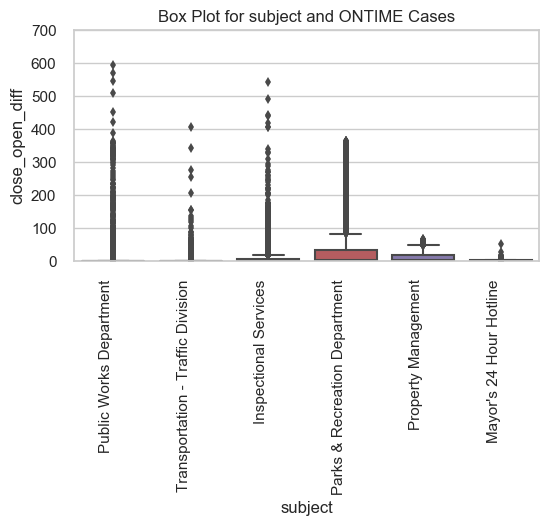

In [227]:
## Box and Whisker Plot for subject and close_open_diff for ontime cases
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='subject', y="close_open_diff", data=on_time)
ax.set_title('Box Plot for subject and ONTIME Cases')
fig.axis(ymin=0, ymax=700)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show();

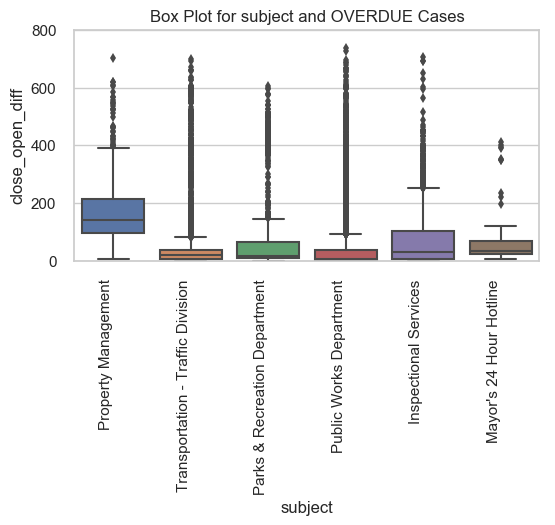

In [228]:
## Box and Whisker Plot for subject and close_open_diff for OVERDUE cases
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='subject', y="close_open_diff", data=over_time)
ax.set_title('Box Plot for subject and OVERDUE Cases')
fig.axis(ymin=0, ymax=800)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show();

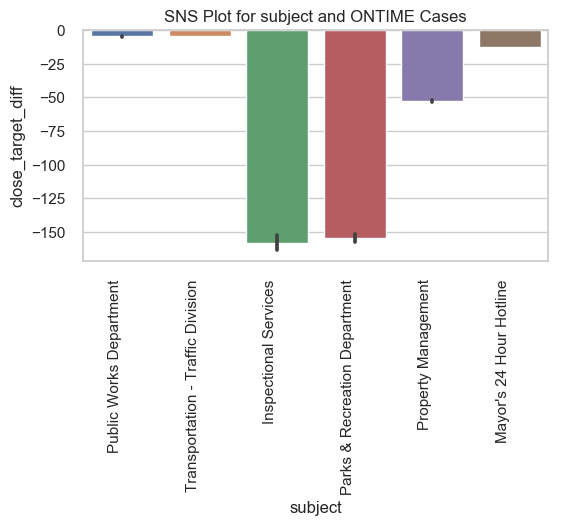

In [229]:
## Graphing the results for the subject dnd close_target_diff for ONTIME Cases
sns.set(style="whitegrid") 
count, ax = plt.subplots(figsize=(6,3))
ax = sns.barplot(x="subject", y="close_target_diff", data=on_time)
ax.set_title('SNS Plot for subject and ONTIME Cases')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

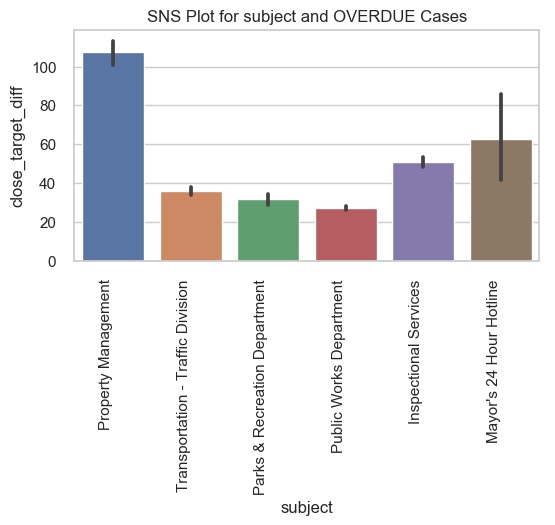

In [230]:
## Graphing the results for the subject and close_target_diff for OVERDUE Cases
sns.set(style="whitegrid") 
count, ax = plt.subplots(figsize=(6,3))
ax = sns.barplot(x="subject", y="close_target_diff", data=over_time)
ax.set_title('SNS Plot for subject and OVERDUE Cases')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

In [231]:
###############################################  dataframe with missing values for closed_dt

In [232]:
## creating a time dataframe with only closed missing values 
df_misstime=df_raw
df_misstime.head(2)

case_enquiry_id             open_dt           target_dt  \
0     1.010000e+11 2011-07-01 02:28:00 2011-08-15 02:28:00   
1     1.010000e+11 2011-07-01 03:03:00 2011-07-15 03:03:00   

            closed_dt   ontime case_status  \
0 2011-08-01 15:21:00   ONTIME      Closed   
1 2011-07-22 16:13:00  OVERDUE      Closed   

                                      closure_reason  \
0  Case Closed Case Resolved No Sidewalk and poor...   
1               Case Closed Case Resolved completed    

                                case_title                            subject  \
0  New Sign  Crosswalk or Pavement Marking  Transportation - Traffic Division   
1                     Street Light Outages            Public Works Department   

            reason      ...      police_district  neighborhood  \
0  Signs & Signals      ...                   E5  West Roxbury   
1    Street Lights      ...                  E18     Hyde Park   

  neighborhood_services_district     ward precinct  \
0                             12  Ward 20     2017   
1                             10  Ward 18     1816   

                  location_street_name location_zipcode latitude longitude  \
0  INTERSECTION Corey St & Lagrange St              NaN  42.3003  -71.1698   
1                    235 Fairmount Ave           2136.0  42.2496  -71.1156   

         source  
0  Self Service  
1  Self Service  

[2 rows x 29 columns]

In [233]:
## Creating a new column for missing values only 
df_misstime['closed_dt_t']=df_misstime['closed_dt']
df_misstime.head(3)

case_enquiry_id             open_dt           target_dt  \
0     1.010000e+11 2011-07-01 02:28:00 2011-08-15 02:28:00   
1     1.010000e+11 2011-07-01 03:03:00 2011-07-15 03:03:00   
2     1.010000e+11 2011-07-01 03:12:00                 NaT   

            closed_dt   ontime case_status  \
0 2011-08-01 15:21:00   ONTIME      Closed   
1 2011-07-22 16:13:00  OVERDUE      Closed   
2 2011-07-01 06:12:00   ONTIME      Closed   

                                      closure_reason  \
0  Case Closed Case Resolved No Sidewalk and poor...   
1               Case Closed Case Resolved completed    
2                         Case Closed Case Resolved    

                                case_title                            subject  \
0  New Sign  Crosswalk or Pavement Marking  Transportation - Traffic Division   
1                     Street Light Outages            Public Works Department   
2                      Highway Maintenance            Public Works Department   

                reason         ...          neighborhood  \
0      Signs & Signals         ...          West Roxbury   
1        Street Lights         ...             Hyde Park   
2  Highway Maintenance         ...            Dorchester   

  neighborhood_services_district     ward precinct  \
0                             12  Ward 20     2017   
1                             10  Ward 18     1816   
2                              7  Ward 13     1309   

                      location_street_name location_zipcode latitude  \
0      INTERSECTION Corey St & Lagrange St              NaN  42.3003   
1                        235 Fairmount Ave           2136.0  42.2496   
2  INTERSECTION Dorchester Ave & Hallam St              NaN  42.3144   

  longitude            source         closed_dt_t  
0  -71.1698      Self Service 2011-08-01 15:21:00  
1  -71.1156      Self Service 2011-07-22 16:13:00  
2  -71.0569  Constituent Call 2011-07-01 06:12:00  

[3 rows x 30 columns]

In [234]:
########################################### Latitude and Longitude ##########################################

In [235]:
## Describe statement for latitude
df1.latitude.describe()

count    207386.000000
mean         42.336009
std           0.031863
min          42.231500
25%          42.315500
50%          42.347000
75%          42.359400
max          42.395100
Name: latitude, dtype: float64

In [236]:
## Describe statement for longitude 
df1.longitude.describe()

count    207386.000000
mean        -71.077197
std           0.032980
min         -71.185400
25%         -71.091500
50%         -71.065000
75%         -71.058700
max         -70.994900
Name: longitude, dtype: float64

In [237]:
# Total missing values for each feature
print(df1.isnull().sum())

ontime                                 0
source                                 0
city_council_district                  0
fire_district                          0
subject                                0
pwd_district                           0
department                             0
neighborhood_services_district         0
police_district                        0
type                                   0
precinct                               0
latitude                               0
longitude                              0
ward                                   0
neighborhood                           0
reason                                 0
submittedphoto                    113945
closed_dt                              0
open_dt                                0
target_dt                              0
ontime_t                               0
source_t                               0
source_t2                              0
city_council_district_t                0
fire_district_t 

In [238]:
#################################################### Pandas Profile

In [239]:
## Importing and running pandas profile statement for the new attributes 
import pandas_profiling
pandas_profiling.ProfileReport(df1)

In [240]:
########################################### Correlation Matrix Plots for analysis #####################################

In [241]:
## Column Check for the df_raw
df_raw.columns


Index(['case_enquiry_id', 'open_dt', 'target_dt', 'closed_dt', 'ontime',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submittedphoto', 'closedphoto',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'source', 'closed_dt_t'],
      dtype='object')

In [242]:
## Column check for the df1
df1.columns

Index(['ontime', 'source', 'city_council_district', 'fire_district', 'subject',
       'pwd_district', 'department', 'neighborhood_services_district',
       'police_district', 'type', 'precinct', 'latitude', 'longitude', 'ward',
       'neighborhood', 'reason', 'submittedphoto', 'closed_dt', 'open_dt',
       'target_dt', 'ontime_t', 'source_t', 'source_t2',
       'city_council_district_t', 'fire_district_t', 'fire_district_t2',
       'subject_t', 'subject_t2', 'pwd_district_t', 'department_t',
       'department_t2', 'police_district_t', 'neighborhood_t', 'ward_t',
       'reason_t', 'type_t', 'precinct_t', 'submittedphoto_t',
       'close_target_diff', 'close_open_diff'],
      dtype='object')

In [243]:
## Converting objects in columns over to integers for analysis 
cols = ['city_council_district_t',
       'neighborhood_services_district',
       'precinct', 'latitude', 'longitude',
       'city_council_district_t', 'fire_district_t',
       'fire_district_t2', 'subject_t', 'subject_t2', 'pwd_district_t',
       'department_t', 'department_t2', 'police_district_t',
       'submittedphoto_t']  # We don't want to convert the Final grade column.
for col in cols:  # Iterate over chosen columns
    df1[col] = pd.to_numeric(df1[col])

In [244]:
## Creating correlation dataset for analysis 
df_corr = df1[['ontime_t', 'source_t', 'city_council_district_t', 'fire_district_t', 'subject_t', 'pwd_district_t', 
                 'department_t','neighborhood_services_district','police_district_t',
                  'neighborhood_t', 'ward_t', 'reason_t', 'type_t','precinct','submittedphoto_t']]
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207386 entries, 606536 to 906550
Data columns (total 15 columns):
ontime_t                          207386 non-null int64
source_t                          207386 non-null int64
city_council_district_t           207386 non-null int64
fire_district_t                   207386 non-null int64
subject_t                         207386 non-null int64
pwd_district_t                    207386 non-null int64
department_t                      207386 non-null int64
neighborhood_services_district    207386 non-null int64
police_district_t                 207386 non-null int64
neighborhood_t                    207386 non-null int64
ward_t                            207386 non-null int64
reason_t                          207386 non-null int64
type_t                            207386 non-null int64
precinct                          207386 non-null int64
submittedphoto_t                  207386 non-null int64
dtypes: int64(15)
memory usage: 35.3 MB


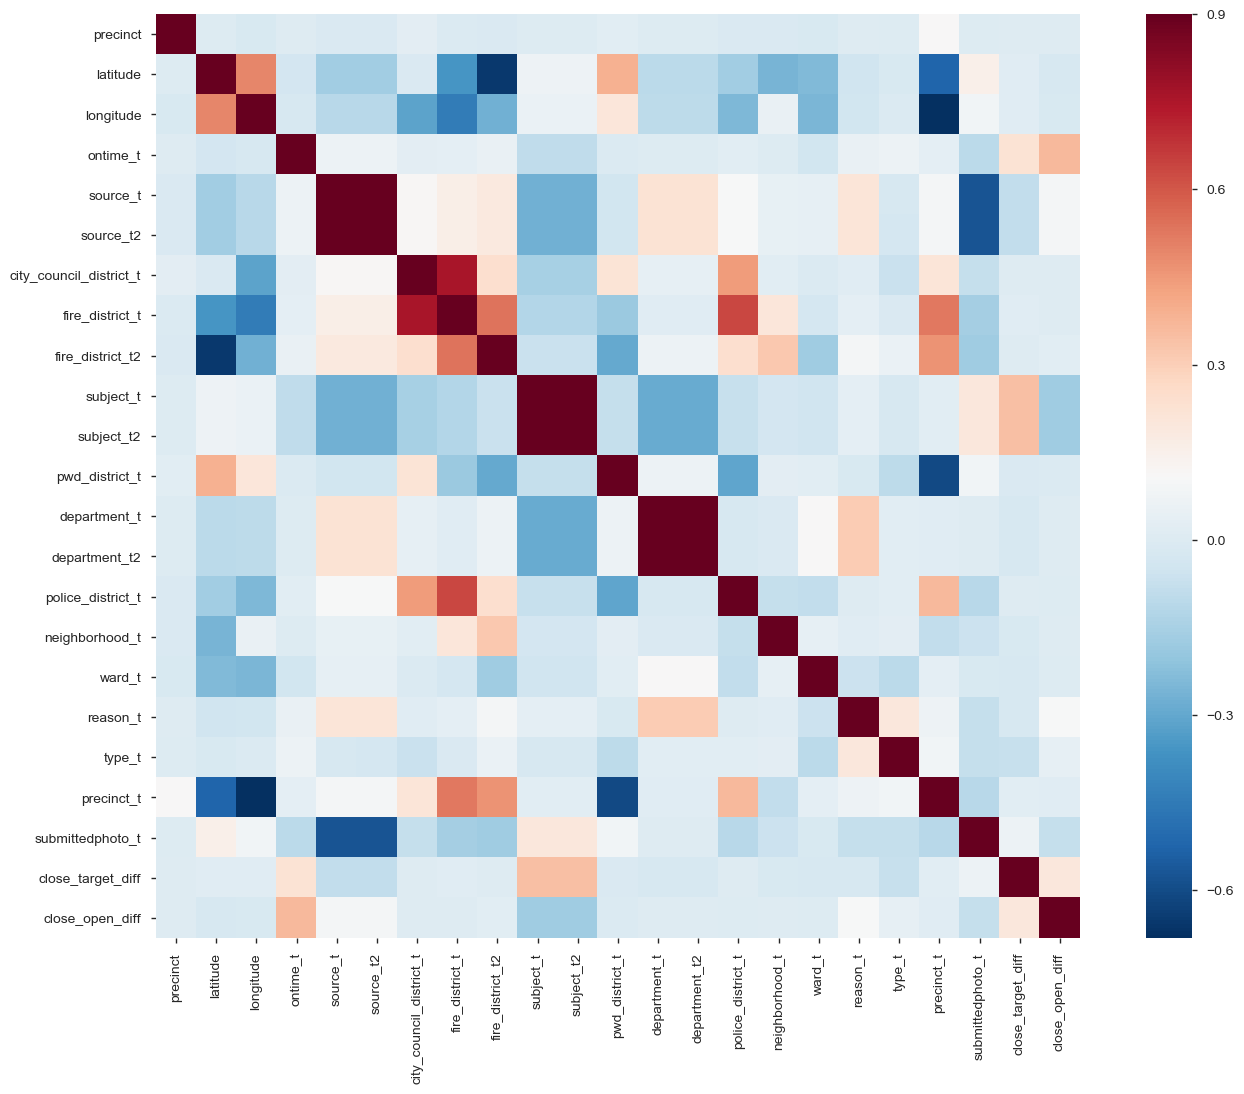

In [245]:
## The correlations between dependent variable and independent variables for all numerical datapoints
corr2 = df1.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(17, 12))
sns.heatmap(corr2, vmax = 0.9, cmap = 'RdBu_r', square = True)
plt.show()

In [246]:
# The correlations between dependent variable and independent variables for all numerical datapoints

corr2 = df1.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()

## rank the correlation
corr_price = corr2['ontime_t']
corr_df = pd.DataFrame({'Column': corr_price.index, 
                        'Correlation': corr_price,
                        'Abs Value': abs(corr_price)}, index = None)
corr_df = corr_df.drop(['ontime_t'], axis = 0)
corr_df.set_index('Column', inplace = True)
corr_df = corr_df.rename_axis(None)
corr_df = corr_df.sort_values(by = ['Abs Value'], ascending = [False])
corr_df.iloc[:, 1:2]

Abs Value
close_open_diff           0.367696
close_target_diff         0.224970
submittedphoto_t          0.105952
subject_t2                0.094614
subject_t                 0.094614
source_t                  0.063681
source_t2                 0.063681
type_t                    0.063116
reason_t                  0.051999
fire_district_t2          0.050262
ward_t                    0.039813
latitude                  0.034088
precinct_t                0.034045
fire_district_t           0.033313
longitude                 0.024567
city_council_district_t   0.024410
police_district_t         0.021393
precinct                  0.005375
pwd_district_t            0.005040
neighborhood_t            0.001578
department_t2             0.001077
department_t              0.000920

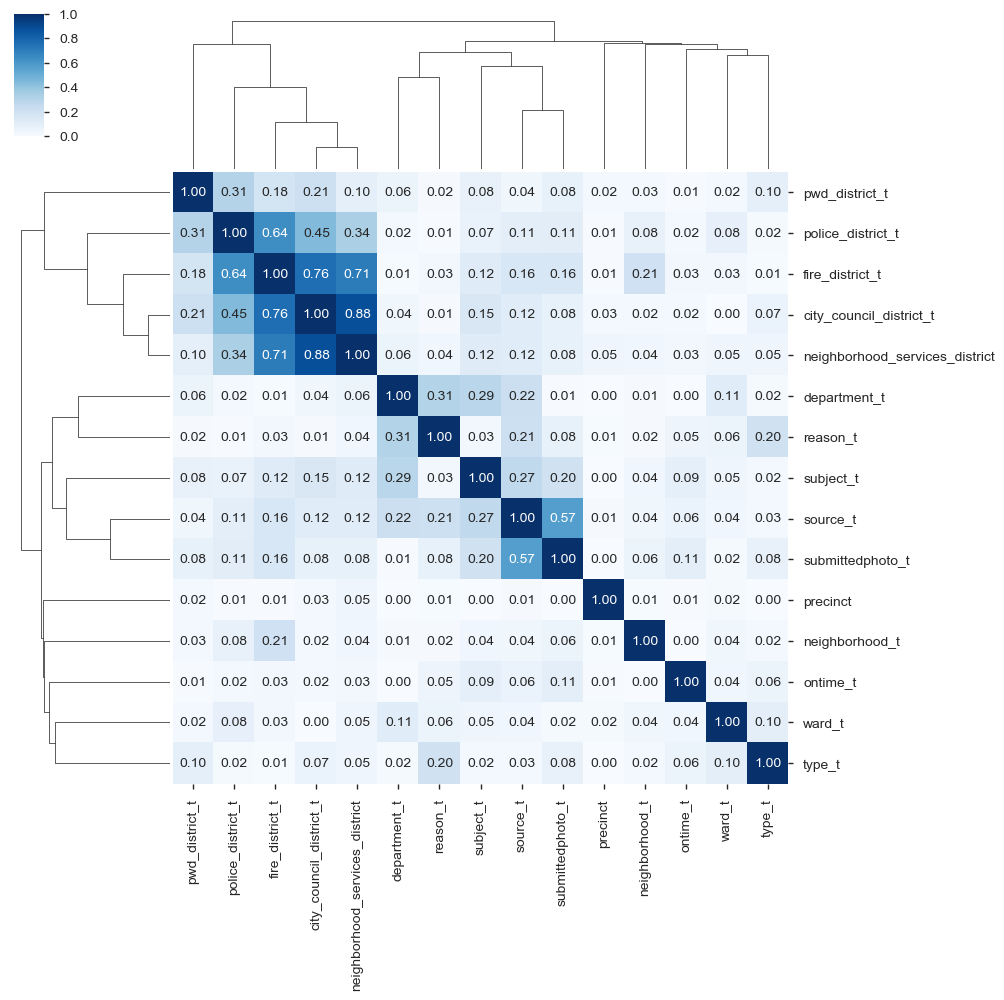

In [247]:
## Creating a seaborn cluster map to determine which varialbes are related to each other 
sns.clustermap(data=df_corr.corr().abs(), annot=True, fmt=".2f", cmap ="Blues")
plt.show()

In [248]:
####################################### Bivariate and Descriptive Statistical Analysis 

In [249]:
## Saving the panda dataframe to a csv file
submit=pd.DataFrame(data=df1)
submit.to_csv('311boston03nov.csv',index=True)

In [266]:
## Creating a new dataframe for the bivariate analysis 
df2=df1
df2.head(2)

ontime                source city_council_district fire_district  \
606536  ONTIME  Citizens Connect App                     1             3   
606537  ONTIME    Employee Generated                     7             9   

                        subject pwd_district department  \
606536  Public Works Department           1B       PWDx   
606537  Public Works Department          10A       PWDx   

        neighborhood_services_district police_district  \
606536                               3              A1   
606537                              13              D4   

                                       type       ...        department_t2  \
606536  Improper Storage of Trash (Barrels)       ...                   15   
606537                 Street Light Outages       ...                   15   

        police_district_t  neighborhood_t ward_t reason_t type_t precinct_t  \
606536                  1               3     39       11     58         27   
606537                  4               4     17       41    146         37   

       submittedphoto_t close_target_diff close_open_diff  
606536                1                -3               0  
606537                0               -17               0  

[2 rows x 40 columns]

In [267]:
## Checking the total counts for the attributes
df2.count()

ontime                            207386
source                            207386
city_council_district             207386
fire_district                     207386
subject                           207386
pwd_district                      207386
department                        207386
neighborhood_services_district    207386
police_district                   207386
type                              207386
precinct                          207386
latitude                          207386
longitude                         207386
ward                              207386
neighborhood                      207386
reason                            207386
submittedphoto                     93441
closed_dt                         207386
open_dt                           207386
target_dt                         207386
ontime_t                          207386
source_t                          207386
source_t2                         207386
city_council_district_t           207386
fire_district_t 

In [268]:
# Shape of the Data and creating a sample size of 100%
 
df2=df2.sample(frac=1, random_state=99)
df2.shape

(207386, 40)

In [269]:
########################################################################################################################

In [270]:
##################### Summary Statistics for these Attributes with the ontime_t target variable

In [271]:
## Stats Models for select attributes
print(stats.normaltest(df2['ontime_t'], axis=0))

NormaltestResult(statistic=77714.86265830144, pvalue=0.0)


In [272]:
## Stats Model Results for target and source_t
results = ols('ontime_t ~ C(source_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     433.0
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:09:37   Log-Likelihood:                -70828.
No. Observations:              207386   AIC:                         1.417e+05
Df Residuals:                  207379   BIC:                         1.417e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1223      0.001    114.571      0.000       0.120       0.124
C(source_t)[T.2]    -0.0589      0.002    -24.904      0.000      -0.064      -0.054
C(source_t)[T.3]     0.0590      0.002     34.851      0.000       0.056       0.062
C(source_t)[T.4]     0.0185      0.004      4.575      0.000       0.011       0.026
C(source_t)[T.5]    -0.1223      0.241     -0.508      0.612      -0.594       0.350
C(source_t)[T.6]     0.0506      0.005     10.170      0.000       0.041       0.060
C(source_t)[T.7]     0.0905      0.050      1.822      0.068      -0.007       0.188
==============================================================================
Omnibus:                    75945.663   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           202010.965
Skew:                           2.085   Prob(JB):                         0.00
Kurtosis:                       5.448   Cond. No.                         344.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [273]:
## Tukey and Multicomparison Models for target and source_t
mc = MultiComparison(df2['ontime_t'], df2['source_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.0589  -0.0658 -0.0519  True 
  1      3     0.059    0.054   0.064   True 
  1      4     0.0185   0.0066  0.0305  True 
  1      5    -0.1223  -0.8321  0.5876 False 
  1      6     0.0506   0.0359  0.0653  True 
  1      7     0.0905  -0.0559  0.237  False 
  2      3     0.1179   0.1106  0.1252  True 
  2      4     0.0774   0.0643  0.0905  True 
  2      5    -0.0634  -0.7732  0.6465 False 
  2      6     0.1095   0.0938  0.1251  True 
  2      7     0.1494   0.0028  0.2959  True 
  3      4    -0.0405  -0.0527 -0.0283  True 
  3      5    -0.1813  -0.8911  0.5285 False 
  3      6    -0.0084  -0.0233  0.0064 False 
  3      7     0.0315   -0.115  0.178  False 
  4      5    -0.1408  -0.8507  0.5691 False 
  4      6     0.032    0.0137  0.0504  True 
  4      7     0.072   -0.0749  0.2188 False 
  5      6     0.1728  -0.537

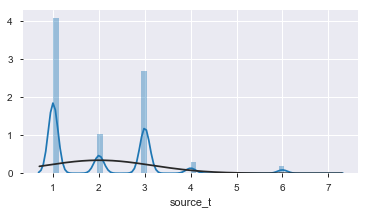

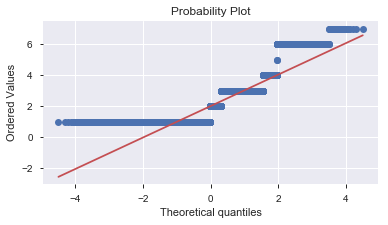

In [274]:
#histogram and normal probability plot
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['source_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['source_t'], plot=plt)

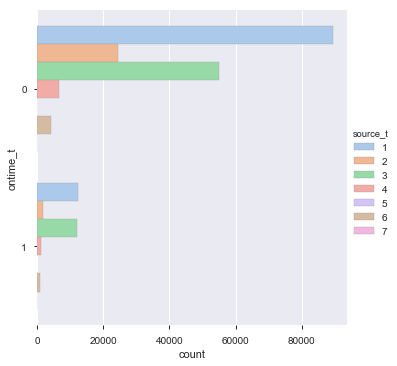

In [275]:
## Barplot and Countplot in Seaborn with source and target
sns.catplot(y="ontime_t", 
            hue="source_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [276]:
## Stats Model Results for target and city council district
results = ols('ontime_t ~ C(city_council_district_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.01
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          9.96e-128
Time:                        21:09:45   Log-Likelihood:                -71809.
No. Observations:              207386   AIC:                         1.436e+05
Df Residuals:                  207376   BIC:                         1.437e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1137      0.002     59.424      0.000       0.110       0.117
C(city_council_district_t)[T.2]      0.0004      0.003      0.164      0.870      -0.005       0.005
C(city_council_district_t)[T.3]      0.0269      0.003      8.500      0.000       0.021       0.033
C(city_council_district_t)[T.4]      0.0470      0.003     13.937      0.000       0.040       0.054
C(city_council_district_t)[T.5]      0.0500      0.003     15.304      0.000       0.044       0.056
C(city_council_district_t)[T.6]      0.0418      0.003     13.374      0.000       0.036       0.048
C(city_council_district_t)[T.7]      0.0360      0.003     12.121      0.000       0.030       0.042
C(city_council_district_t)[T.8]      0.0127      0.003      4.246      0.000       0.007       0.018
C(city_council_district_t)[T.9]      0.0260      0.003      8.285      0.000       0.020       0.032
C(city_council_district_t)[T.33]     0.0467      0.007      7.131      0.000       0.034       0.060
==============================================================================
Omnibus:                    77313.212   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           209020.905
Skew:                           2.116   Prob(JB):                         0.00
Kurtosis:                       5.505   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [277]:
## Tukey and Multicomparison Models for target and city_council 
mc = MultiComparison(df2['ontime_t'], df2['city_council_district_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.0004  -0.0077  0.0086 False 
  1      3     0.0269   0.0169  0.037   True 
  1      4     0.047    0.0363  0.0577  True 
  1      5      0.05    0.0397  0.0603  True 
  1      6     0.0418   0.0319  0.0516  True 
  1      7     0.036    0.0266  0.0454  True 
  1      8     0.0127   0.0032  0.0221  True 
  1      9     0.026    0.016   0.0359  True 
  1      33    0.0467   0.026   0.0674  True 
  2      3     0.0265   0.0168  0.0362  True 
  2      4     0.0466   0.0362  0.057   True 
  2      5     0.0496   0.0396  0.0596  True 
  2      6     0.0413   0.0318  0.0509  True 
  2      7     0.0356   0.0266  0.0447  True 
  2      8     0.0122   0.0032  0.0213  True 
  2      9     0.0255   0.016   0.0351  True 
  2      33    0.0462   0.0257  0.0668  True 
  3      4     0.0201   0.0082  0.032   True 
  3      5     0.0231   0.011

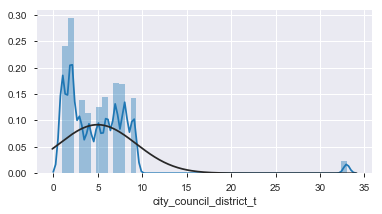

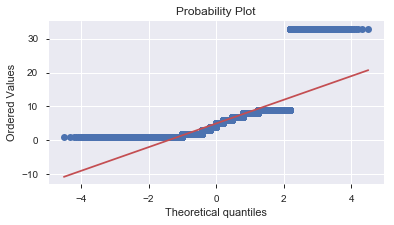

In [278]:
#histogram and normal probability plot for City Council District
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['city_council_district_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['city_council_district_t'], plot=plt)

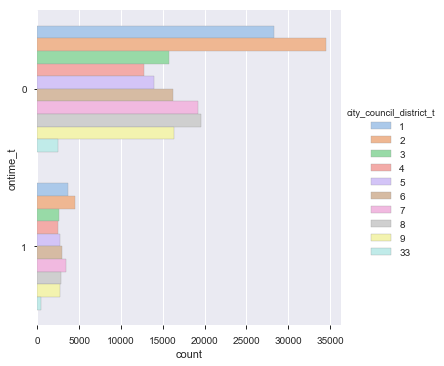

In [279]:
## Barplot and Countplot in Seaborn and city council district
sns.catplot(y="ontime_t", 
            hue="city_council_district_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [280]:
## Stats Model Results for target and Fire District
results = ols('ontime_t ~ C(fire_district_t2)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     525.2
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          4.30e-116
Time:                        21:09:49   Log-Likelihood:                -71857.
No. Observations:              207386   AIC:                         1.437e+05
Df Residuals:                  207384   BIC:                         1.437e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1203      0.001    119.074      0.000       0.118       0.122
C(fire_district_t2)[T.2]     0.0346      0.002     22.918      0.000       0.032       0.038
==============================================================================
Omnibus:                    77377.925   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           209354.806
Skew:                           2.118   Prob(JB):                         0.00
Kurtosis:                       5.507   Cond. No.                         2.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [281]:
## Tukey and Multicomparison Models for target and fire district
mc = MultiComparison(df2['ontime_t'], df2['fire_district_t2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  1      2     0.0346  0.0317 0.0376  True 
-------------------------------------------


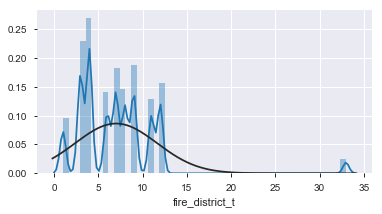

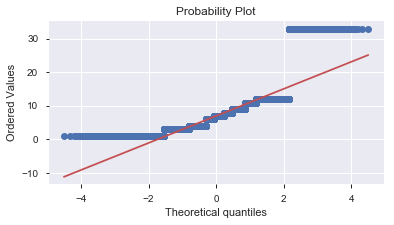

In [282]:
#histogram and normal probability plot 
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['fire_district_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['fire_district_t'], plot=plt)

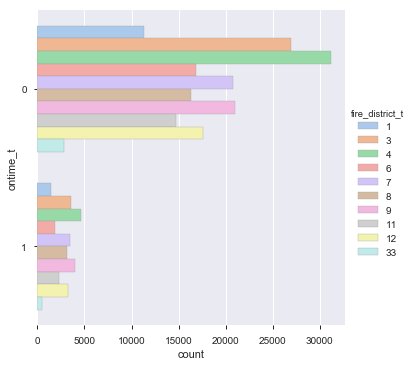

In [283]:
## Barplot and Countplot in Seaborn for fire district 
sns.catplot(y="ontime_t", 
            hue="fire_district_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [284]:
## Stats Model Results for target and subject
results = ols('ontime_t ~ C(subject_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     644.2
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:10:01   Log-Likelihood:                -70521.
No. Observations:              207386   AIC:                         1.411e+05
Df Residuals:                  207380   BIC:                         1.411e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2796      0.003     93.105      0.000       0.274       0.285
C(subject_t)[T.6]     -0.2154      0.010    -21.834      0.000      -0.235      -0.196
C(subject_t)[T.8]     -0.1623      0.004    -38.196      0.000      -0.171      -0.154
C(subject_t)[T.9]      0.0012      0.007      0.189      0.850      -0.012       0.014
C(subject_t)[T.10]    -0.1519      0.003    -48.043      0.000      -0.158      -0.146
C(subject_t)[T.11]    -0.1611      0.003    -48.678      0.000      -0.168      -0.155
==============================================================================
Omnibus:                    76329.916   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           204877.206
Skew:                           2.087   Prob(JB):                         0.00
Kurtosis:                       5.506   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [285]:
## Tukey and Multicomparison Models for target and subject_t
mc = MultiComparison(df2['ontime_t'], df2['subject_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  5      6    -0.2154  -0.2435 -0.1873  True 
  5      8    -0.1623  -0.1744 -0.1502  True 
  5      9     0.0012  -0.0175   0.02  False 
  5      10   -0.1519  -0.1609 -0.1429  True 
  5      11   -0.1611  -0.1705 -0.1517  True 
  6      8     0.0531   0.025   0.0812  True 
  6      9     0.2166   0.1851  0.2482  True 
  6      10    0.0635   0.0365  0.0904  True 
  6      11    0.0543   0.0272  0.0814  True 
  8      9     0.1636   0.1448  0.1824  True 
  8      10    0.0104   0.0014  0.0194  True 
  8      11    0.0012  -0.0082  0.0107 False 
  9      10   -0.1532  -0.1701 -0.1362  True 
  9      11   -0.1623  -0.1795 -0.1451  True 
  10     11   -0.0092   -0.014 -0.0043  True 
---------------------------------------------


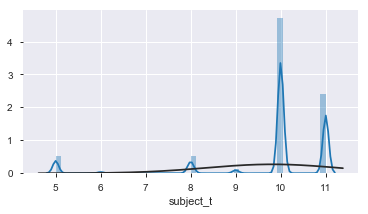

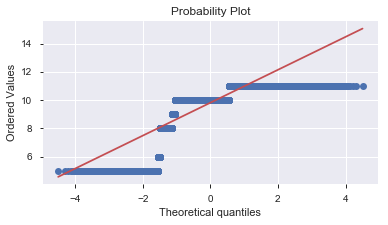

In [286]:
#histogram and normal probability plot for subject
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['subject_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['subject_t'], plot=plt)

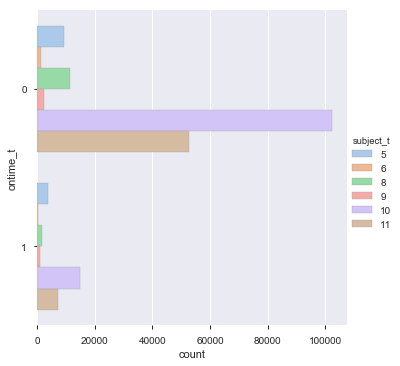

In [287]:
## Barplot and Countplot in Seaborn for subject_t
sns.catplot(y="ontime_t", 
            hue="subject_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [288]:
## Stats Model Results for target and pwd_district_t
results = ols('ontime_t ~ C(pwd_district_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     70.73
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          9.30e-188
Time:                        21:10:13   Log-Likelihood:                -71660.
No. Observations:              207386   AIC:                         1.433e+05
Df Residuals:                  207372   BIC:                         1.435e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1594      0.003     53.855      0.000       0.154       0.165
C(pwd_district_t)[T.3]     -0.0217      0.004     -5.611      0.000      -0.029      -0.014
C(pwd_district_t)[T.4]     -0.0234      0.004     -5.945      0.000      -0.031      -0.016
C(pwd_district_t)[T.5]     -0.0639      0.004    -16.170      0.000      -0.072      -0.056
C(pwd_district_t)[T.6]     -0.0100      0.004     -2.270      0.023      -0.019      -0.001
C(pwd_district_t)[T.7]      0.0011      0.004      0.290      0.772      -0.007       0.009
C(pwd_district_t)[T.8]      0.0069      0.005      1.510      0.131      -0.002       0.016
C(pwd_district_t)[T.9]     -0.0445      0.004    -10.504      0.000      -0.053      -0.036
C(pwd_district_t)[T.20]    -0.0125      0.005     -2.480      0.013      -0.022      -0.003
C(pwd_district_t)[T.21]    -0.0629      0.004    -16.477      0.000      -0.070      -0.055
C(pwd_district_t)[T.22]    -0.0290      0.004     -8.234      0.000      -0.036      -0.022
C(pwd_district_t)[T.23]    -0.0042      0.004     -1.001      0.317      -0.013       0.004
C(pwd_district_t)[T.24]    -0.0041      0.004     -0.988      0.323      -0.012       0.004
C(pwd_district_t)[T.33]    -0.0014      0.007     -0.204      0.838      -0.015       0.012
==============================================================================
Omnibus:                    77093.442   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           207867.203
Skew:                           2.111   Prob(JB):                         0.00
Kurtosis:                       5.495   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [289]:
## Tukey and Multicomparison Models for target and pwd_district_t
mc = MultiComparison(df2['ontime_t'], df2['pwd_district_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  2      3    -0.0217  -0.0346 -0.0087  True 
  2      4    -0.0234  -0.0366 -0.0102  True 
  2      5    -0.0639  -0.0772 -0.0507  True 
  2      6     -0.01   -0.0249  0.0048 False 
  2      7     0.0011  -0.0119  0.0142 False 
  2      8     0.0069  -0.0084  0.0221 False 
  2      9    -0.0445  -0.0587 -0.0303  True 
  2      20   -0.0125  -0.0293  0.0044 False 
  2      21   -0.0629  -0.0757 -0.0501  True 
  2      22    -0.029  -0.0408 -0.0172  True 
  2      23   -0.0042  -0.0184   0.01  False 
  2      24   -0.0041   -0.018  0.0098 False 
  2      33   -0.0014  -0.0251  0.0222 False 
  3      4    -0.0017  -0.0138  0.0103 False 
  3      5    -0.0423  -0.0544 -0.0302  True 
  3      6     0.0116  -0.0022  0.0254 False 
  3      7     0.0228   0.0109  0.0347  True 
  3      8     0.0285   0.0143  0.0428  True 
  3      9    -0.0228  -0.035

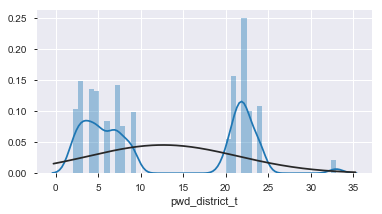

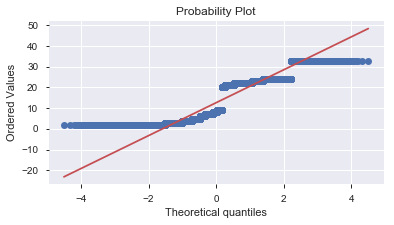

In [290]:
#histogram and normal probability plot for pwd_district_t
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['pwd_district_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['pwd_district_t'], plot=plt)

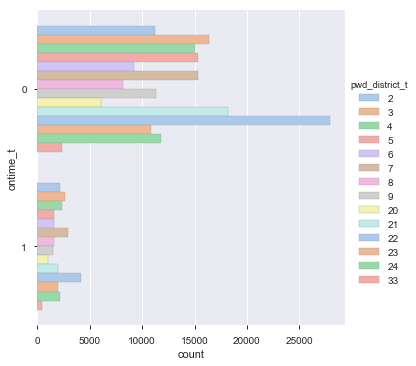

In [291]:
## Barplot and Countplot in Seaborn for pwd_district_t
sns.catplot(y="ontime_t", 
            hue="pwd_district_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [292]:
## Stats Model Results for target and department_t2
results = ols('ontime_t ~ C(department_t2)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     659.3
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:10:19   Log-Likelihood:                -69514.
No. Observations:              207386   AIC:                         1.390e+05
Df Residuals:                  207377   BIC:                         1.391e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1164      0.001     84.125      0.000       0.114       0.119
C(department_t2)[T.6]      0.5678      0.055     10.341      0.000       0.460       0.675
C(department_t2)[T.9]      0.0550      0.057      0.961      0.336      -0.057       0.167
C(department_t2)[T.10]     0.2598      0.009     27.986      0.000       0.242       0.278
C(department_t2)[T.11]     0.1847      0.003     57.035      0.000       0.178       0.191
C(department_t2)[T.12]     0.3121      0.074      4.227      0.000       0.167       0.457
C(department_t2)[T.13]     0.0195      0.003      5.962      0.000       0.013       0.026
C(department_t2)[T.14]     0.1820      0.006     30.730      0.000       0.170       0.194
C(department_t2)[T.15]     0.0025      0.002      1.453      0.146      -0.001       0.006
==============================================================================
Omnibus:                    75750.455   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           202828.608
Skew:                           2.068   Prob(JB):                         0.00
Kurtosis:                       5.523   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [293]:
## Tukey and Multicomparison Models for target and department_t2
mc = MultiComparison(df2['ontime_t'], df2['department_t2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  5      6     0.5678   0.3975  0.7381  True 
  5      9     0.055   -0.1225  0.2324 False 
  5      10    0.2598   0.231   0.2886  True 
  5      11    0.1847   0.1747  0.1947  True 
  5      12    0.3121   0.0831  0.5412  True 
  5      13    0.0195   0.0094  0.0297  True 
  5      14    0.182    0.1636  0.2004  True 
  5      15    0.0025  -0.0028  0.0078 False 
  6      9    -0.5128  -0.7586 -0.2669  True 
  6      10   -0.3079  -0.4805 -0.1353  True 
  6      11   -0.3831  -0.5536 -0.2126  True 
  6      12   -0.2556   -0.541  0.0297 False 
  6      13   -0.5482  -0.7187 -0.3777  True 
  6      14   -0.3857  -0.5569 -0.2146  True 
  6      15   -0.5653  -0.7356  -0.395  True 
  9      10    0.2049   0.0252  0.3845  True 
  9      11    0.1297  -0.0479  0.3073 False 
  9      12    0.2571  -0.0325  0.5468 False 
  9      13   -0.0355  -0.213

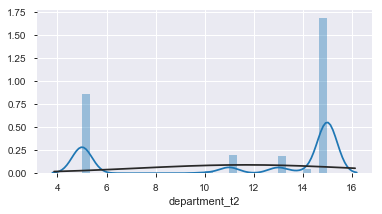

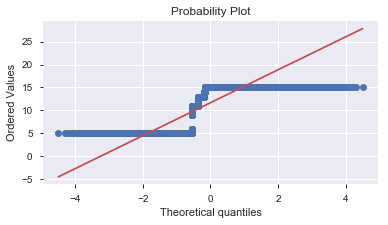

In [294]:
#histogram and normal probability plot and department_t2
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['department_t2'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['department_t2'], plot=plt)

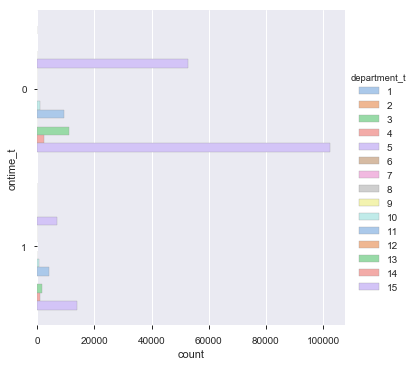

In [295]:
## Barplot and Countplot in Seaborn for and department_t2
sns.catplot(y="ontime_t", 
            hue="department_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [296]:
## Stats Model Results for target and neighborhood_services_district_t
results = ols('ontime_t ~ C(neighborhood_services_district)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     54.76
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          8.42e-176
Time:                        21:10:25   Log-Likelihood:                -71682.
No. Observations:              207386   AIC:                         1.434e+05
Df Residuals:                  207369   BIC:                         1.436e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.2787      0.025     11.027      0.000       0.229       0.328
C(neighborhood_services_district)[T.1]     -0.1637      0.025     -6.433      0.000      -0.214      -0.114
C(neighborhood_services_district)[T.2]     -0.1324      0.026     -5.172      0.000      -0.183      -0.082
C(neighborhood_services_district)[T.3]     -0.1717      0.025     -6.755      0.000      -0.222      -0.122
C(neighborhood_services_district)[T.4]     -0.1379      0.026     -5.392      0.000      -0.188      -0.088
C(neighborhood_services_district)[T.5]     -0.1817      0.025     -7.152      0.000      -0.231      -0.132
C(neighborhood_services_district)[T.6]     -0.1643      0.025     -6.460      0.000      -0.214      -0.114
C(neighborhood_services_district)[T.7]     -0.1323      0.025     -5.198      0.000      -0.182      -0.082
C(neighborhood_services_district)[T.8]     -0.1428      0.026     -5.599      0.000      -0.193      -0.093
C(neighborhood_services_district)[T.9]     -0.1018      0.026     -3.990      0.000      -0.152      -0.052
C(neighborhood_services_district)[T.10]    -0.1208      0.025     -4.753      0.000      -0.171      -0.071
C(neighborhood_services_district)[T.11]    -0.1175      0.025     -4.614      0.000      -0.167      -0.068
C(neighborhood_services_district)[T.12]    -0.1325      0.026     -5.167      0.000      -0.183      -0.082
C(neighborhood_services_district)[T.13]    -0.1212      0.025     -4.774      0.000      -0.171      -0.071
C(neighborhood_services_district)[T.14]    -0.1479      0.025     -5.831      0.000      -0.198      -0.098
C(neighborhood_services_district)[T.15]    -0.1440      0.025     -5.667      0.000      -0.194      -0.094
C(neighborhood_services_district)[T.33]    -0.1270      0.026     -4.863      0.000      -0.178      -0.076
==============================================================================
Omnibus:                    77146.402   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           208167.686
Skew:                           2.112   Prob(JB):                         0.00
Kurtosis:                       5.498   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [297]:
## Tukey and Multicomparison Models for target and neighborhood_services_district_t
mc = MultiComparison(df2['ontime_t'], df2['neighborhood_services_district'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.1637  -0.2518 -0.0757  True 
  0      2    -0.1324  -0.2209 -0.0438  True 
  0      3    -0.1717  -0.2597 -0.0838  True 
  0      4    -0.1379  -0.2264 -0.0495  True 
  0      5    -0.1817  -0.2695 -0.0938  True 
  0      6    -0.1643  -0.2523 -0.0763  True 
  0      7    -0.1323  -0.2204 -0.0443  True 
  0      8    -0.1428   -0.231 -0.0546  True 
  0      9    -0.1018  -0.1901 -0.0136  True 
  0      10   -0.1208  -0.2087 -0.0329  True 
  0      11   -0.1175  -0.2056 -0.0294  True 
  0      12   -0.1325  -0.2213 -0.0438  True 
  0      13   -0.1212   -0.209 -0.0334  True 
  0      14   -0.1479  -0.2356 -0.0602  True 
  0      15    -0.144  -0.2319 -0.0561  True 
  0      33    -0.127  -0.2174 -0.0367  True 
  1      2     0.0314   0.0138  0.0489  True 
  1      3     -0.008  -0.0221  0.0062 False 
  1      4     0.0258   0.008

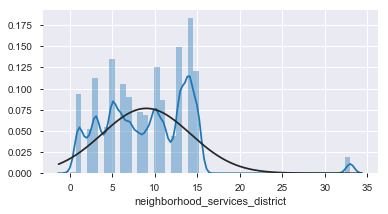

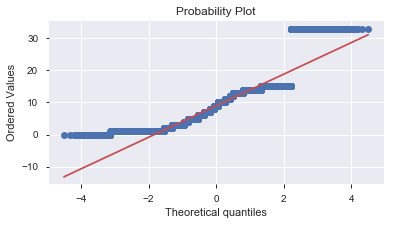

In [298]:
#histogram and normal probability plot and neighborhood_services_district_t
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['neighborhood_services_district'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['neighborhood_services_district'], plot=plt)

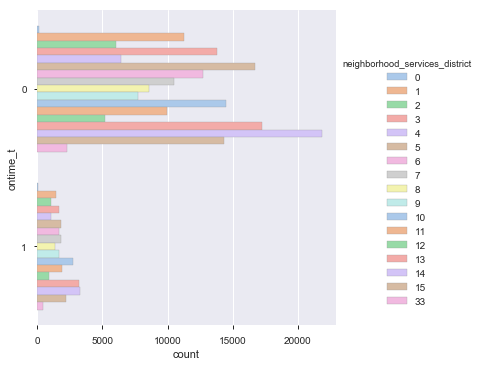

In [299]:
## Barplot and Countplot in Seaborn and neighborhood_services_district_t
sns.catplot(y="ontime_t", 
            hue="neighborhood_services_district", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [300]:
## Stats Model Results for target and city police District
results = ols('ontime_t ~ C(police_district_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     65.42
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          5.65e-160
Time:                        21:10:30   Log-Likelihood:                -71727.
No. Observations:              207386   AIC:                         1.435e+05
Df Residuals:                  207373   BIC:                         1.436e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1134      0.002     56.289      0.000       0.109       0.117
C(police_district_t)[T.2]      0.0449      0.003     14.223      0.000       0.039       0.051
C(police_district_t)[T.3]      0.0581      0.004     15.089      0.000       0.051       0.066
C(police_district_t)[T.4]      0.0136      0.003      4.907      0.000       0.008       0.019
C(police_district_t)[T.5]      0.0377      0.004     10.218      0.000       0.030       0.045
C(police_district_t)[T.6]     -0.0123      0.003     -3.840      0.000      -0.019      -0.006
C(police_district_t)[T.7]      0.0016      0.004      0.432      0.666      -0.006       0.009
C(police_district_t)[T.11]     0.0245      0.003      7.865      0.000       0.018       0.031
C(police_district_t)[T.13]     0.0483      0.004     13.375      0.000       0.041       0.055
C(police_district_t)[T.14]     0.0226      0.003      6.883      0.000       0.016       0.029
C(police_district_t)[T.15]     0.0335      0.005      7.394      0.000       0.025       0.042
C(police_district_t)[T.18]     0.0509      0.004     13.125      0.000       0.043       0.059
C(police_district_t)[T.33]     0.0443      0.007      6.586      0.000       0.031       0.057
==============================================================================
Omnibus:                    77205.357   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           208468.695
Skew:                           2.114   Prob(JB):                         0.00
Kurtosis:                       5.500   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [301]:
## Tukey and Multicomparison Models for target and police district
mc = MultiComparison(df2['ontime_t'], df2['police_district_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.0449   0.0345  0.0554  True 
  1      3     0.0581   0.0454  0.0709  True 
  1      4     0.0136   0.0044  0.0228  True 
  1      5     0.0377   0.0254  0.0499  True 
  1      6    -0.0123  -0.0229 -0.0017  True 
  1      7     0.0016  -0.0105  0.0136 False 
  1      11    0.0245   0.0142  0.0349  True 
  1      13    0.0483   0.0363  0.0603  True 
  1      14    0.0226   0.0117  0.0335  True 
  1      15    0.0335   0.0185  0.0485  True 
  1      18    0.0509   0.0381  0.0638  True 
  1      33    0.0443   0.022   0.0666  True 
  2      3     0.0132  -0.0003  0.0267 False 
  2      4    -0.0313  -0.0416 -0.0211  True 
  2      5    -0.0073  -0.0203  0.0057 False 
  2      6    -0.0572  -0.0687 -0.0457  True 
  2      7    -0.0434  -0.0562 -0.0305  True 
  2      11   -0.0204  -0.0317 -0.0091  True 
  2      13    0.0034  -0.009

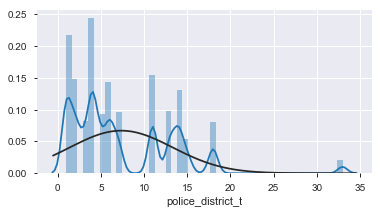

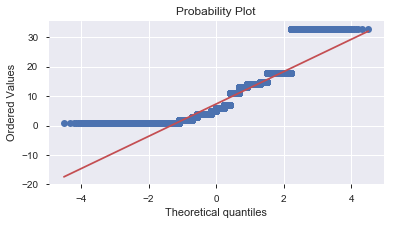

In [302]:
#histogram and normal probability plot for and police District
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['police_district_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['police_district_t'], plot=plt)

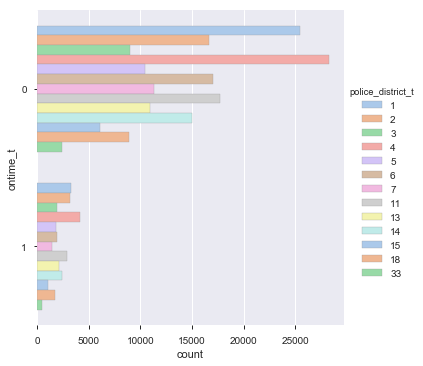

In [303]:
## Barplot and Countplot in Seaborn for police District
sns.catplot(y="ontime_t", 
            hue="police_district_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [304]:
## Stats Model Results for target and neighborhood_t
results = ols('ontime_t ~ C(neighborhood_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     39.81
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          2.79e-178
Time:                        21:10:36   Log-Likelihood:                -71662.
No. Observations:              207386   AIC:                         1.434e+05
Df Residuals:                  207362   BIC:                         1.436e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1604      0.021      7.683      0.000       0.120       0.201
C(neighborhood_t)[T.1]     -0.0258      0.021     -1.224      0.221      -0.067       0.015
C(neighborhood_t)[T.2]     -0.0307      0.021     -1.452      0.146      -0.072       0.011
C(neighborhood_t)[T.3]     -0.0685      0.021     -3.222      0.001      -0.110      -0.027
C(neighborhood_t)[T.4]     -0.0306      0.021     -1.437      0.151      -0.072       0.011
C(neighborhood_t)[T.5]     -0.0062      0.024     -0.258      0.796      -0.053       0.041
C(neighborhood_t)[T.6]     -0.0135      0.021     -0.637      0.524      -0.055       0.028
C(neighborhood_t)[T.7]     -0.0890      0.094     -0.950      0.342      -0.273       0.095
C(neighborhood_t)[T.8]     -0.0194      0.021     -0.926      0.354      -0.061       0.022
C(neighborhood_t)[T.9]     -0.0366      0.021     -1.737      0.082      -0.078       0.005
C(neighborhood_t)[T.10]    -0.0455      0.021     -2.156      0.031      -0.087      -0.004
C(neighborhood_t)[T.11]     0.0015      0.021      0.070      0.944      -0.041       0.044
C(neighborhood_t)[T.12]     0.0214      0.021      1.005      0.315      -0.020       0.063
C(neighborhood_t)[T.13]     0.0003      0.021      0.013      0.990      -0.041       0.042
C(neighborhood_t)[T.14]    -0.0006      0.021     -0.029      0.977      -0.042       0.041
C(neighborhood_t)[T.15]     0.0641      0.031      2.101      0.036       0.004       0.124
C(neighborhood_t)[T.16]    -0.0116      0.022     -0.537      0.591      -0.054       0.031
C(neighborhood_t)[T.17]    -0.0003      0.021     -0.012      0.990      -0.042       0.041
C(neighborhood_t)[T.18]    -0.0069      0.021     -0.327      0.744      -0.048       0.034
C(neighborhood_t)[T.19]    -0.0455      0.023     -1.990      0.047      -0.090      -0.001
C(neighborhood_t)[T.20]    -0.0636      0.021     -3.022      0.003      -0.105      -0.022
C(neighborhood_t)[T.21]    -0.0549      0.021     -2.602      0.009      -0.096      -0.014
C(neighborhood_t)[T.22]    -0.0014      0.022     -0.066      0.947      -0.044       0.041
C(neighborhood_t)[T.23]    -0.0140      0.021     -0.659      0.510      -0.056       0.028
==============================================================================
Omnibus:                    77110.577   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           207972.911
Skew:                           2.112   Prob(JB):                         0.00
Kurtosis:                       5.496   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [305]:
## Tukey and Multicomparison Models for target and neighborhood_t
mc = MultiComparison(df2['ontime_t'], df2['neighborhood_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.0258  -0.1024  0.0508 False 
  0      2    -0.0307  -0.1075  0.0462 False 
  0      3    -0.0685  -0.1458  0.0088 False 
  0      4    -0.0306  -0.1082  0.0469 False 
  0      5    -0.0062   -0.093  0.0807 False 
  0      6    -0.0135  -0.0909  0.0638 False 
  0      7     -0.089  -0.4299  0.2519 False 
  0      8    -0.0194  -0.0958  0.0569 False 
  0      9    -0.0366  -0.1132   0.04  False 
  0      10   -0.0455  -0.1222  0.0313 False 
  0      11    0.0015  -0.0765  0.0795 False 
  0      12    0.0214   -0.056  0.0987 False 
  0      13    0.0003  -0.0769  0.0774 False 
  0      14   -0.0006  -0.0774  0.0762 False 
  0      15    0.0641  -0.0469  0.1751 False 
  0      16   -0.0116   -0.09   0.0668 False 
  0      17   -0.0003  -0.0776  0.0771 False 
  0      18   -0.0069  -0.0834  0.0696 False 
  0      19   -0.0455  -0.128

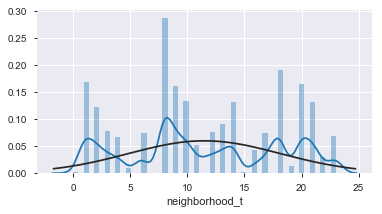

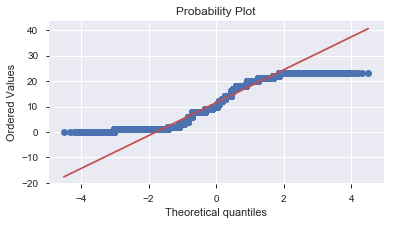

In [306]:
#histogram and normal probability plot for neighborhood_t
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['neighborhood_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['neighborhood_t'], plot=plt)

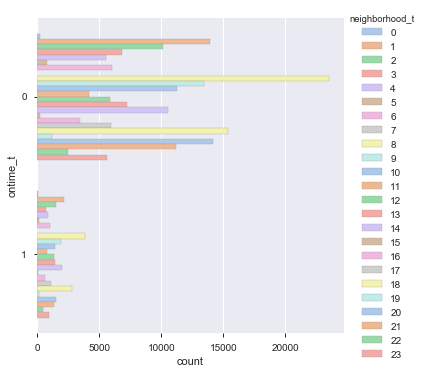

In [307]:
## Barplot and Countplot in Seaborn for neighborhood_t
sns.catplot(y="ontime_t", 
            hue="neighborhood_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [308]:
## Stats Model Results for target and ward_t
results = ols('ontime_t ~ C(ward_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     29.03
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          2.26e-243
Time:                        21:10:41   Log-Likelihood:                -71468.
No. Observations:              207386   AIC:                         1.430e+05
Df Residuals:                  207340   BIC:                         1.435e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3482      0.032     10.789      0.000       0.285       0.411
C(ward_t)[T.1]     -0.2247      0.033     -6.857      0.000      -0.289      -0.160
C(ward_t)[T.2]     -0.1891      0.033     -5.686      0.000      -0.254      -0.124
C(ward_t)[T.3]     -0.1818      0.033     -5.502      0.000      -0.247      -0.117
C(ward_t)[T.4]     -0.1682      0.033     -5.055      0.000      -0.233      -0.103
C(ward_t)[T.5]     -0.2302      0.033     -6.872      0.000      -0.296      -0.165
C(ward_t)[T.6]     -0.1847      0.033     -5.573      0.000      -0.250      -0.120
C(ward_t)[T.7]     -0.2246      0.034     -6.669      0.000      -0.291      -0.159
C(ward_t)[T.8]     -0.2221      0.033     -6.713      0.000      -0.287      -0.157
C(ward_t)[T.9]     -0.2166      0.034     -6.455      0.000      -0.282      -0.151
C(ward_t)[T.10]    -0.1908      0.033     -5.820      0.000      -0.255      -0.127
C(ward_t)[T.11]    -0.1934      0.033     -5.863      0.000      -0.258      -0.129
C(ward_t)[T.12]    -0.1586      0.033     -4.829      0.000      -0.223      -0.094
C(ward_t)[T.13]    -0.1834      0.033     -5.564      0.000      -0.248      -0.119
C(ward_t)[T.14]    -0.1916      0.033     -5.844      0.000      -0.256      -0.127
C(ward_t)[T.15]    -0.1948      0.033     -5.897      0.000      -0.259      -0.130
C(ward_t)[T.16]    -0.2079      0.032     -6.411      0.000      -0.271      -0.144
C(ward_t)[T.17]    -0.1833      0.033     -5.609      0.000      -0.247      -0.119
C(ward_t)[T.18]    -0.1947      0.033     -5.987      0.000      -0.258      -0.131
C(ward_t)[T.19]    -0.2301      0.033     -7.041      0.000      -0.294      -0.166
C(ward_t)[T.20]    -0.2388      0.033     -7.230      0.000      -0.304      -0.174
C(ward_t)[T.21]    -0.1829      0.033     -5.569      0.000      -0.247      -0.119
C(ward_t)[T.22]    -0.2030      0.033     -6.184      0.000      -0.267      -0.139
C(ward_t)[T.23]    -0.1965      0.033     -5.967      0.000      -0.261      -0.132
C(ward_t)[T.24]    -0.2367      0.032     -7.290      0.000      -0.300      -0.173
C(ward_t)[T.25]    -0.2005      0.033     -6.121      0.000      -0.265      -0.136
C(ward_t)[T.26]    -0.2074      0.033     -6.344      0.000      -0.272      -0.143
C(ward_t)[T.27]    -0.1839      0.033     -5.608      0.000      -0.248      -0.120
C(ward_t)[T.28]    -0.2205      0.033     -6.740      0.000      -0.285      -0.156
C(ward_t)[T.29]    -0.1729      0.033     -5.299      0.000      -0.237      -0.109
C(ward_t)[T.30]    -0.2057      0.033     -6.279      0.000      -0.270      -0.141
C(ward_t)[T.31]    -0.1903      0.033     -5.836      0.000      -0.254      -0.126
C(ward_t)[T.32]    -0.1937      0.033     -5.940      0.000      -0.258      -0.130
C(ward_t)[T.33]    -0.1782      0.032     -5.490      0.000

In [309]:
## Tukey and Multicomparison Models for target and ward_t
mc = MultiComparison(df2['ontime_t'], df2['ward_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.2247  -0.3542 -0.0952  True 
  0      2    -0.1891  -0.3207 -0.0576  True 
  0      3    -0.1818  -0.3124 -0.0512  True 
  0      4    -0.1682  -0.2998 -0.0367  True 
  0      5    -0.2302  -0.3626 -0.0978  True 
  0      6    -0.1847  -0.3158 -0.0537  True 
  0      7    -0.2246  -0.3577 -0.0915  True 
  0      8    -0.2221  -0.3529 -0.0913  True 
  0      9    -0.2166  -0.3492 -0.0839  True 
  0      10   -0.1908  -0.3204 -0.0612  True 
  0      11   -0.1934  -0.3238  -0.063  True 
  0      12   -0.1586  -0.2885 -0.0288  True 
  0      13   -0.1834  -0.3137 -0.0531  True 
  0      14   -0.1916  -0.3212  -0.062  True 
  0      15   -0.1948  -0.3253 -0.0642  True 
  0      16   -0.2079  -0.3361 -0.0797  True 
  0      17   -0.1833  -0.3126 -0.0541  True 
  0      18   -0.1947  -0.3233 -0.0661  True 
  0      19   -0.2301  -0.359

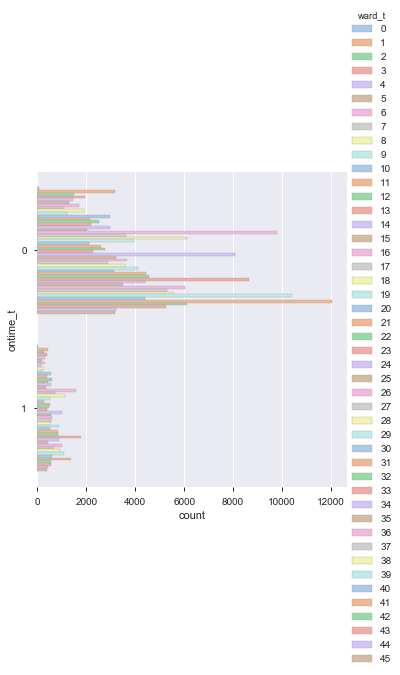

In [310]:
## Barplot and Countplot in Seaborn for target and ward_t
sns.catplot(y="ontime_t", 
            hue="ward_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [311]:
## Stats Model Results for target and reason_t
results = ols('ontime_t ~ C(reason_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     835.3
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:10:46   Log-Likelihood:                -62169.
No. Observations:              207386   AIC:                         1.244e+05
Df Residuals:                  207360   BIC:                         1.247e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0000      0.115      8.661      0.000       0.774       1.226
C(reason_t)[T.1]     -0.8621      0.123     -6.999      0.000      -1.103      -0.621
C(reason_t)[T.6]     -0.9778      0.125     -7.803      0.000      -1.223      -0.732
C(reason_t)[T.8]     -0.6102      0.116     -5.281      0.000      -0.837      -0.384
C(reason_t)[T.10]    -0.8889      0.139     -6.406      0.000      -1.161      -0.617
C(reason_t)[T.11]    -0.9572      0.115     -8.289      0.000      -1.184      -0.731
C(reason_t)[T.14]    -0.9396      0.116     -8.111      0.000      -1.167      -0.713
C(reason_t)[T.15]    -0.9263      0.115     -8.022      0.000      -1.153      -0.700
C(reason_t)[T.16]    -0.7550      0.116     -6.531      0.000      -0.982      -0.528
C(reason_t)[T.19]    -0.9674      0.120     -8.036      0.000      -1.203      -0.731
C(reason_t)[T.21]    -0.7192      0.116     -6.221      0.000      -0.946      -0.493
C(reason_t)[T.22]    -0.7360      0.116     -6.353      0.000      -0.963      -0.509
C(reason_t)[T.23]    -0.7662      0.115     -6.635      0.000      -0.993      -0.540
C(reason_t)[T.24]    -0.8602      0.116     -7.441      0.000      -1.087      -0.634
C(reason_t)[T.31]    -0.8795      0.118     -7.484      0.000      -1.110      -0.649
C(reason_t)[T.32]    -0.7845      0.116     -6.789      0.000      -1.011      -0.558
C(reason_t)[T.33]    -0.7143      0.169     -4.226      0.000      -1.046      -0.383
C(reason_t)[T.36]    -0.6728      0.116     -5.824      0.000      -0.899      -0.446
C(reason_t)[T.37]    -0.9143      0.115     -7.916      0.000      -1.141      -0.688
C(reason_t)[T.39]    -0.7338      0.115     -6.354      0.000      -0.960      -0.507
C(reason_t)[T.40]    -0.9436      0.115     -8.172      0.000      -1.170      -0.717
C(reason_t)[T.41]    -0.7122      0.116     -6.165      0.000      -0.939      -0.486
C(reason_t)[T.42]    -0.7302      0.116     -6.284      0.000      -0.958      -0.502
C(reason_t)[T.43]    -0.9490      0.116     -8.215      0.000      -1.175      -0.723
C(reason_t)[T.44]    -0.6667      0.176     -3.780      0.000      -1.012      -0.321
C(reason_t)[T.45]    -0.4805      0.121     -3.961      0.000      -0.718      -0.243
==============================================================================
Omnibus:                    65961.797   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158235.209
Skew:                           1.836   Prob(JB):                         0.00
Kurtosis:                       5.198   Cond. No.                         874.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [312]:
## Tukey and Multicomparison Models for target and reason_t
mc = MultiComparison(df2['ontime_t'], df2['reason_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.8621   -1.315 -0.4091  True 
  0      6    -0.9778  -1.4386 -0.5169  True 
  0      8    -0.6102  -1.0352 -0.1852  True 
  0      10   -0.8889  -1.3992 -0.3785  True 
  0      11   -0.9572  -1.3819 -0.5325  True 
  0      14   -0.9396  -1.3657 -0.5136  True 
  0      15   -0.9263   -1.351 -0.5017  True 
  0      16    -0.755  -1.1802 -0.3298  True 
  0      19   -0.9674  -1.4101 -0.5247  True 
  0      21   -0.7192  -1.1443  -0.294  True 
  0      22    -0.736  -1.1621 -0.3099  True 
  0      23   -0.7662  -1.1909 -0.3415  True 
  0      24   -0.8602  -1.2853  -0.435  True 
  0      31   -0.8795  -1.3116 -0.4473  True 
  0      32   -0.7845  -1.2094 -0.3595  True 
  0      33   -0.7143  -1.3359 -0.0927  True 
  0      36   -0.6728  -1.0976  -0.248  True 
  0      37   -0.9143   -1.339 -0.4895  True 
  0      39   -0.7338  -1.158

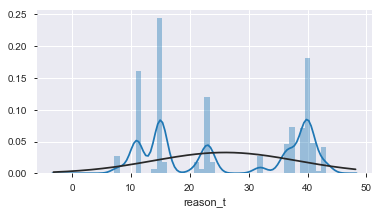

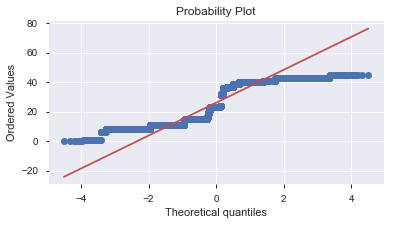

In [313]:
#histogram and normal probability plot for reason_t
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['reason_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['reason_t'], plot=plt)

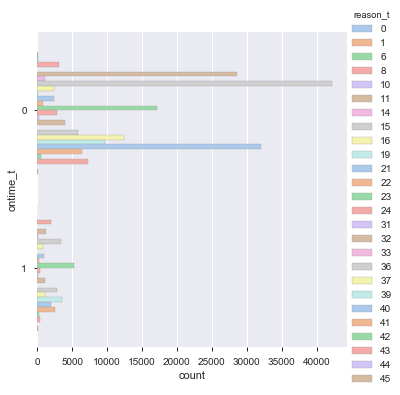

In [314]:
## Barplot and Countplot in Seaborn for reason_t
sns.catplot(y="ontime_t", 
            hue="reason_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

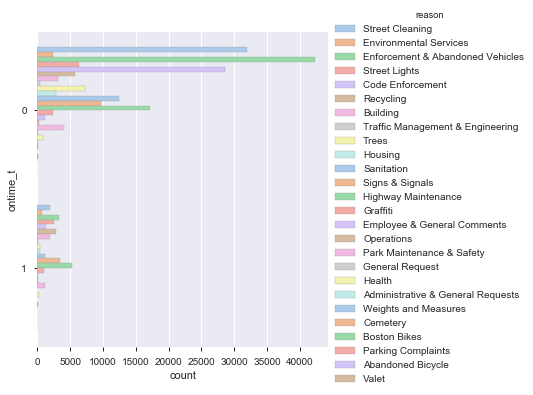

In [315]:
## Barplot and Countplot in Seaborn for reason
sns.catplot(y="ontime_t", 
            hue="reason", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [316]:
## Grouping the over_time cases by reason and close_open_diff
group_reason=df2.groupby(['reason'])['ontime_t'].count()
group_reason

reason
Abandoned Bicycle                        8
Administrative & General Requests       58
Boston Bikes                            45
Building                              5118
Cemetery                                18
Code Enforcement                     29945
Employee & General Comments           1209
Enforcement & Abandoned Vehicles     45606
Environmental Services                3200
General Request                         92
Graffiti                              3351
Health                                1178
Highway Maintenance                  22347
Housing                               3247
Operations                             224
Park Maintenance & Safety             5141
Parking Complaints                       7
Recycling                             8576
Sanitation                           13553
Signs & Signals                      13191
Street Cleaning                      33929
Street Lights                         9005
Traffic Management & Engineering       630
Tree

In [317]:
## Stats Model Results for target and type_t
results = ols('ontime_t ~ C(type_t)', data=df2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ontime_t   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     336.9
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:10:58   Log-Likelihood:                -51824.
No. Observations:              207386   AIC:                         1.039e+05
Df Residuals:                  207252   BIC:                         1.053e+05
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0000      0.110      9.102      0.000       0.785       1.215
C(type_t)[T.1]      -0.5269      0.114     -4.602      0.000      -0.751      -0.302
C(type_t)[T.2]      -0.5550      0.110     -5.047      0.000      -0.771      -0.339
C(type_t)[T.12]     -0.8161      0.115     -7.108      0.000      -1.041      -0.591
C(type_t)[T.13]     -0.9778      0.119     -8.200      0.000      -1.211      -0.744
C(type_t)[T.14]     -1.0000      0.210     -4.753      0.000      -1.412      -0.588
C(type_t)[T.15]     -0.8788      0.122     -7.176      0.000      -1.119      -0.639
C(type_t)[T.17]     -0.8958      0.119     -7.549      0.000      -1.128      -0.663
C(type_t)[T.19]     -0.2873      0.111     -2.598      0.009      -0.504      -0.071
C(type_t)[T.20]     -0.9830      0.110     -8.943      0.000      -1.198      -0.768
C(type_t)[T.22]     -0.4390      0.120     -3.655      0.000      -0.674      -0.204
C(type_t)[T.24]     -0.8889      0.132     -6.732      0.000      -1.148      -0.630
C(type_t)[T.25]     -0.8273      0.113     -7.322      0.000      -1.049      -0.606
C(type_t)[T.27]     -0.9533      0.112     -8.518      0.000      -1.173      -0.734
C(type_t)[T.28]     -0.8172      0.110     -7.398      0.000      -1.034      -0.601
C(type_t)[T.29]     -1.0000      0.110     -9.067      0.000      -1.216      -0.784
C(type_t)[T.30]     -0.8716      0.113     -7.727      0.000      -1.093      -0.651
C(type_t)[T.32]     -1.0000      0.118     -8.504      0.000      -1.230      -0.770
C(type_t)[T.33]     -0.5901      0.111     -5.326      0.000      -0.807      -0.373
C(type_t)[T.34]     -0.9196      0.110     -8.352      0.000      -1.135      -0.704
C(type_t)[T.35]     -0.6857      0.110     -6.228      0.000      -0.901      -0.470
C(type_t)[T.36]     -0.7105      0.113     -6.303      0.000      -0.931      -0.490
C(type_t)[T.39]     -0.7660      0.119     -6.444      0.000      -0.999      -0.533
C(type_t)[T.40]     -0.7589      0.114     -6.673      0.000      -0.982      -0.536
C(type_t)[T.41]     -0.7207      0.114     -6.335      0.000      -0.944      -0.498
C(type_t)[T.43]     -0.9396      0.110     -8.524      0.000      -1.156      -0.724
C(type_t)[T.44]     -0.9232      0.110     -8.380      0.000      -1.139      -0.707
C(type_t)[T.45]     -0.5833      0.119     -4.915      0.000      -0.816      -0.351
C(type_t)[T.46]     -0.7192      0.110     -6.538      0.000      -0.935      -0.504
C(type_t)[T.47]     -0.8501      0.110     -7.726      0.000      -1.066      -0.634
C(type_t)[T.48]     -0.8009      0.111     -7.227      0.000      -1.018      -0.584
C(type_t)[T.51]     -0.6716      0.113     -5.938      0.000      -0.893      -0.450
C(type_t)[T.52]     -0.9518      0.110     -8.645      0.000      -1.168      -0.736
C(type_t)[T.53]     -0.

In [318]:
## Tukey and Multicomparison Models for target and type_t
mc = MultiComparison(df2['ontime_t'], df2['type_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.5269  -1.0341 -0.0197  True 
  0      2     -0.555  -1.0421 -0.0679  True 
  0      12   -0.8161  -1.3247 -0.3075  True 
  0      13   -0.9778   -1.506 -0.4496  True 
  0      14     -1.0    -1.932  -0.068  True 
  0      15   -0.8788  -1.4213 -0.3363  True 
  0      17   -0.8958  -1.4215 -0.3701  True 
  0      19   -0.2873  -0.7771  0.2025 False 
  0      20    -0.983  -1.4699 -0.4961  True 
  0      22    -0.439  -0.9711  0.0931 False 
  0      24   -0.8889  -1.4738 -0.3039  True 
  0      25   -0.8273  -1.3279 -0.3268  True 
  0      27   -0.9533   -1.449 -0.4575  True 
  0      28   -0.8172  -1.3065 -0.3279  True 
  0      29     -1.0   -1.4886 -0.5114  True 
  0      30   -0.8716  -1.3713 -0.3719  True 
  0      32     -1.0   -1.5209 -0.4791  True 
  0      33   -0.5901   -1.081 -0.0993  True 
  0      34   -0.9196  -1.407

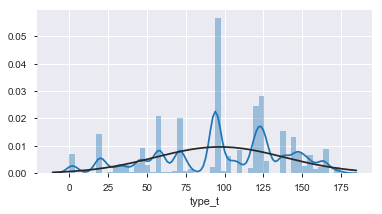

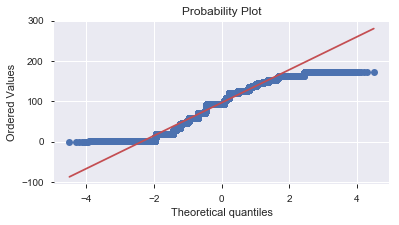

In [319]:
#histogram and normal probability plot for type_t
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(df2['type_t'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(df2['type_t'], plot=plt)

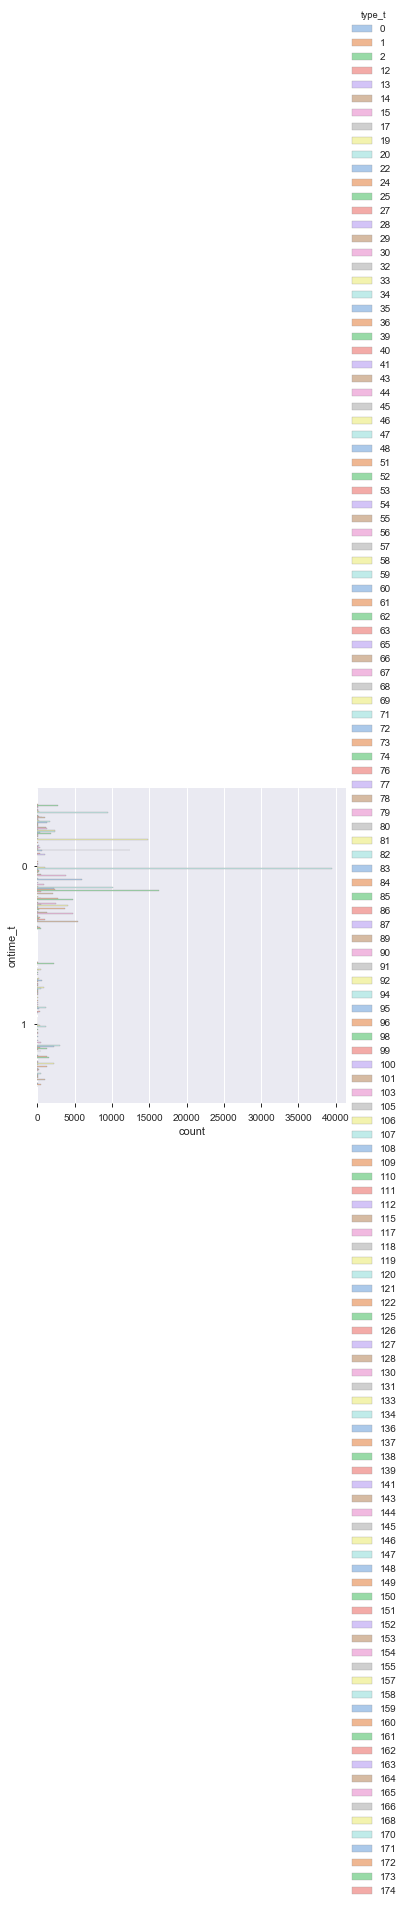

In [320]:
## Barplot and Countplot in Seaborn for type_t
sns.catplot(y="ontime_t", 
            hue="type_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df2);

In [321]:
## creating a dataframe with only the ontime cases
df2_ontime=df2[df2['ontime_t'] == 0]
df2_ontime.head(5)

ontime                source city_council_district fire_district  \
878963  ONTIME  Citizens Connect App                     3             8   
750483  ONTIME       City Worker App                     8             3   
862195  ONTIME  Citizens Connect App                     6             9   
699097  ONTIME      Constituent Call                     5            12   
788396  ONTIME      Constituent Call                     2             6   

                                  subject pwd_district department  \
878963            Public Works Department            7       PWDx   
750483            Public Works Department           1B       PWDx   
862195              Inspectional Services            2        ISD   
699097            Public Works Department            8       PWDx   
788396  Transportation - Traffic Division            5       BTDT   

        neighborhood_services_district police_district                 type  \
878963                               7             C11  Pick up Dead Animal   
750483                              14              A1        CE Collection   
862195                              11             E13      Rodent Activity   
699097                              10             E18  Pick up Dead Animal   
788396                               5              C6   Abandoned Vehicles   

             ...        department_t2  police_district_t  neighborhood_t  \
878963       ...                   15                 11               8   
750483       ...                   15                  1               3   
862195       ...                   11                 13              14   
699097       ...                   15                 18              13   
788396       ...                    5                  6              20   

       ward_t reason_t type_t precinct_t submittedphoto_t close_target_diff  \
878963     31       40    103        146                1                -3   
750483     41       40     20         43                1                -1   
862195     11       16    128        197                0               -25   
699097     33       40    103        187                0                -2   
788396     43       15      2         61                0                -6   

       close_open_diff  
878963               0  
750483               0  
862195               5  
699097               0  
788396              13  

[5 rows x 40 columns]

In [322]:
## creating a dataframe with only the overdue cases
df2_overdue=df2[df2['ontime_t'] == 1]
df2_overdue.head(5)

ontime                source city_council_district fire_district  \
658360  OVERDUE  Citizens Connect App                     2             6   
810508  OVERDUE      Constituent Call                     6             9   
735329  OVERDUE      Constituent Call                     7             4   
695091  OVERDUE  Citizens Connect App                     2             6   
634984  OVERDUE      Constituent Call                     6             9   

                                  subject pwd_district department  \
658360            Public Works Department            5       PWDx   
810508            Public Works Department          10A       PWDx   
735329              Inspectional Services           1C        ISD   
695091  Transportation - Traffic Division            3       BTDT   
634984  Transportation - Traffic Division            2       BTDT   

        neighborhood_services_district police_district  \
658360                               5              C6   
810508                              11             E13   
735329                              14              D4   
695091                               5              C6   
634984                              11             E13   

                               type       ...        department_t2  \
658360         Street Light Outages       ...                   15   
810508          Unshoveled Sidewalk       ...                   15   
735329  Unsafe Dangerous Conditions       ...                   11   
695091           Abandoned Vehicles       ...                    5   
634984           Abandoned Vehicles       ...                    5   

        police_district_t  neighborhood_t ward_t reason_t type_t precinct_t  \
658360                  6              20     42       41    146         53   
810508                 13              14      2       11    164         88   
735329                  4               2     40        8    158         34   
695091                  6               8     43       15      2         67   
634984                 13              14     26       15      2         97   

       submittedphoto_t close_target_diff close_open_diff  
658360                0               133             147  
810508                0                 2               4  
735329                0               265             266  
695091                0                34              53  
634984                0                 6              25  

[5 rows x 40 columns]

In [323]:
## Creating a df3 for the modeling portion of the analysis 
## df3=df_time is the dataframe for all missing closed and target time variables.  
df3=df2

In [324]:
##  Creating a subsample for analysis for the modeling section
data_s=df3.sample(frac=1, random_state=99)
data_s.shape

(207386, 40)

In [325]:
#######################################################################################################

In [248]:
################################### creating the baseline model #######################################